# Preliminary experiments

In [ ]:
%config Completer.use_jedi = False


# imports

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function




%matplotlib inline

# Various
import numpy as np
import pandas as pd
from six.moves import xrange
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time


# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Activation, Masking, BatchNormalization, GRU, Lambda,\
TimeDistributed
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.callbacks import History

from tensorflow.keras import backend as k
from tensorflow.keras import callbacks
from tensorflow import keras

# sklearn
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold
from sklearn import pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Project specific modules
# from losses import weibull_loglik_discrete, weibull_loglik_continuous
# from preprocessing import build_data
# from activations import activate

# math package
import math

In [2]:
tf.__version__

'2.4.1'

In [3]:
from tensorflow import keras

In [4]:
keras.__version__

'2.4.0'

## Utilities

In [5]:
from tqdm import tqdm

def build_data(units, time, x, max_time, is_test, mask_value, original_data, label='linear', **kwargs):
    """
    This function prepares the data by segmenting it into subsequences of length max_time
    by also padding, by pad_value, the time-steps when there is no data.

    :param units: identifier feature
    :param time: time-index feature
    :param x: sensor values (time-series)
    :param max_time: maximum lookback
    :param is_test: (boolean) test set or train set
    :param mask_value: value to pad the sequences
    :param **kwargs: additional arguments that might be used for other datasets
    :return: (ndarray) y. y[0] will be time remaining to an event, y[1] will be event indicator
    """

    # initializing output
    out_y = []

    # number of features/sensors
    d = x.shape[1]

    # A full history of sensor readings to date for each x
    out_x = []
    n_units = set(units)
    # print(n_units)
    for i in tqdm(n_units):
        # When did the engine fail? (Last day + 1 for train data, irrelevant for test.)
        max_unit_time = int(np.max(time[units == i])) + 1

        if is_test:
            start = max_unit_time - 1
        else:
            start = 0
        
        this_x = []

        for j in range(start, max_unit_time):

            engine_x = x[units == i]
            
               
            if is_test:
                original_max = original_data[original_data.unit_number==i].time.max()
                if label == 'linear':
                    out_y.append(original_max - j)
                else:
                    if j <= original_max/2:
                        out_y.append(130) # value taken from Heimes et al. (2008)

                    else:
                        p = (0 - 130) / (original_max - original_max/2)
                        rul = p * j - p * original_max
                        out_y.append(rul)

            else:
                if label == 'linear':
                    out_y.append(max_unit_time - j)
                else:
                    if j <= max_unit_time/2:
                        out_y.append(130) # value taken from Heimes et al. (2008)

                    else:
                        p = (0 - 130) / (max_unit_time - max_unit_time/2)
                        rul = p * j - p * max_unit_time
    #                     out_y.append(max_unit_time - j)
                        out_y.append(rul)

            xtemp = np.zeros((1, max_time, d))
            xtemp += mask_value

            xtemp[:, max_time - min(j, max_time - 1) - 1:max_time, :] = engine_x[max(0, j - max_time + 1):j + 1, :]
            this_x.append(xtemp)

        this_x = np.concatenate(this_x)
        out_x.append(this_x)
    out_x = np.concatenate(out_x)
    out_y = np.array(out_y).reshape(len(out_y), 1) # np.concatenate(out_y) (uncomment when adding event. See comment above)
    return out_x, out_y


## Loss Function

In [6]:
def weibull_ttf(y, u, a, b):
    mttf = a * tf.exp(tf.math.lgamma(1 + 1/b))
      
    return k.square(y - mttf)


def loglik_discrete(y, u, a, b, epsilon=k.epsilon()):
    hazard0 = k.pow((y + epsilon) / a, b)
    hazard1 = k.pow((y + 1.0) / a, b)

    loglikelihoods = u * \
        k.log(k.exp(hazard1 - hazard0) - (1.0 - epsilon)) - hazard1
    return loglikelihoods


def loglik_continuous(y, u, a, b, epsilon=k.epsilon()):
    ya = (y + epsilon) / a
 
    loglikelihoods = u * (k.log(b) + b * k.log(ya)) - k.pow(ya, b)
    return loglikelihoods


class CustomLoss(keras.losses.Loss):
    """ Creates a keras WTTE-loss function.
        - Usage
            :Example:
            .. code-block:: python
               loss = wtte.Loss(kind='discrete').loss_function
               model.compile(loss=loss, optimizer=RMSprop(lr=0.01))
               # And with masking:
               loss = wtte.Loss(kind='discrete',reduce_loss=False).loss_function
               model.compile(loss=loss, optimizer=RMSprop(lr=0.01),
                              sample_weight_mode='temporal')
        .. note::
            With masking keras needs to access each loss-contribution individually.
            Therefore we do not sum/reduce down to scalar (dim 1), instead return a 
            tensor (with reduce_loss=False).
        :param kind:  One of 'discrete' or 'continuous'
        :param reduce_loss: 
        :param clip_prob: Clip likelihood to [log(clip_prob),log(1-clip_prob)]
        :param regularize: Deprecated.
        :param location: Deprecated.
        :param growth: Deprecated.
        :type reduce_loss: Boolean
    """

    def __init__(self,
                 kind,
                 reduce_loss=False):
        super().__init__()
        self.kind = kind
        self.reduce_loss = reduce_loss

    def call(self, y_true, y_pred):
        
#         y, u = tf.unstack(y_true, axis=-1) # (uncomment when adding event)
        y = tf.cast(y_true, tf.float32) # (replace y_true -> y when adding event)
        y = tf.reshape(y, [-1]) # (coment when adding event)
#         u = tf.cast(u, tf.float32) # (uncomment when adding event)
        u = tf.constant(1, dtype=tf.float32) 
        a, b = tf.unstack(y_pred, axis=-1)
        
        if self.kind == 'discrete':
            loglikelihoods = loglik_discrete(y, u, a, b)
        elif self.kind == 'continuous':
            loglikelihoods = loglik_continuous(y, u, a, b)
        elif self.kind == 'mttf':
            loglikelihoods = weibull_ttf(y, u, a, b)
        
           
        if self.reduce_loss:
            loss = -1.0 * (k.mean(loglikelihoods, axis=-1)) # apparently this returns the same as the case below
        else:
            loss = -1.0 * loglikelihoods
        
        return loss

## Activation Layer

In [7]:
class Activate(keras.layers.Layer):
    """ Elementwise computation of alpha and regularized beta.
        Wrapper to `output_lambda` using keras.layers.Activation. 
        See this for details.
        - Usage
            .. code-block:: python
               wtte_activation = wtte.OuputActivation(init_alpha=1.,
                                                 max_beta_value=4.0).activation
               model.add(Dense(2))
               model.add(Activation(wtte_activation))
    """

    def __init__(self, init_alpha=1.0, max_beta_value=1.0):
        super().__init__()
        self.init_alpha = init_alpha
        self.max_beta_value = max_beta_value
        

    def call(self, ab):
        """ (Internal function) Activation wrapper
        :param ab: original tensor with alpha and beta.
        :return ab: return of `output_lambda` with `init_alpha` and `max_beta_value`.
        """
        
        a, b = tf.unstack(ab, axis=-1)
#         print(a)
#         print(b)
        
#         a = k.exp(a)
#         b = k.softplus(b)
        
#         print(a)
#         print(b)
        
        # Implicitly initialize alpha:
        a = self.init_alpha * k.exp(a)

        if self.max_beta_value > 1.05:  # some value >>1.0
            # shift to start around 1.0
            # assuming input is around 0.0
            _shift = np.log(self.max_beta_value - 1.0)

            b = b - _shift

        b = self.max_beta_value * k.sigmoid(b)
        
        
#         a = a * tf.exp(tf.math.lgamma(1 + 1/b))
#         b = tf.repeat(1.0, tf.size(a))
        
        x = k.stack([a, b], axis=-1)
        
        return x

## A simple network

In [8]:
def network(train_X, train_y, test_X, test_y, mask_value, epochs, batch_size, init_alpha):

    k.set_epsilon(1e-10)
    history = History()
    nan_terminator = callbacks.TerminateOnNaN()
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss')
    early_stopping = callbacks.EarlyStopping(patience=10)
#     tensorboard = callbacks.TensorBoard(log_dir = './logs_2D')

    n_features = train_X.shape[-1]

    # Start building our model
    model = Sequential()
    # Mask parts of the lookback period that are all _mask_value_ (i.e., unobserved) so they don't skew the model
    model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
#     model.add(BatchNormalization())
    model.add(GRU(100, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(20, activation='tanh', return_sequences=False))
    model.add(Dense(2))
    custom_activation = Activate()
    model.add(BatchNormalization())
    model.add(Activation(custom_activation))

    
    # Use the discrete log-likelihood for Weibull survival data as our loss function
    rmse = tf.keras.metrics.RootMeanSquaredError()

    model.compile(loss=CustomLoss(kind='continuous', reduce_loss=True), optimizer=Adam(lr=.01, clipvalue=0.5))#, metrics=['mse', rmse]) #CustomLoss(kind='mttf', reduce_loss=False)
    
    model.summary()
    
    model.fit(train_X, train_y,
              epochs=epochs,
              batch_size=batch_size,
              validation_data=(test_X, test_y),
              verbose=1,
              callbacks=[nan_terminator, history, reduce_lr, early_stopping], # , tensorboard
              workers=32)
    

    return model, history

### Weibull specific functions

In [9]:
def weibull_pdf(alpha, beta, t):
    return (beta/alpha) * (t/alpha)**(beta-1)*np.exp(- (t/alpha)**beta)

In [10]:
def weibull_median(alpha, beta):
    return alpha*(-np.log(.5))**(1/beta)

In [11]:
def weibull_mean(alpha, beta):
    return alpha * math.gamma(1 + 1/beta)

In [12]:
def weibull_mode(alpha, beta):
    assert np.all(beta > 1)
    return alpha * ((beta-1)/beta)**(1/beta)

## Dataset 1 - CMAPSS

In [13]:
id_col = 'unit_number'
time_col = 'time'
feature_cols = [ 'op_setting_1', 'op_setting_2', 'op_setting_3'] + ['sensor_measurement_{}'.format(x) for x in range(1,22)]
column_names = [id_col, time_col] + feature_cols

In [14]:
train_x_orig = pd.read_csv('./DataSets/CMAPSS/train_FD001.csv', header=None, sep='\s+', decimal=".")
# train_x_orig.drop(train_x_orig.columns[[-1, -2]], axis=1, inplace=True)
train_x_orig.columns = column_names

test_x_orig = pd.read_csv('./DataSets/CMAPSS/test_FD001.csv', header=None, sep='\s+', decimal=".")
# test_x_orig.drop(test_x_orig.columns[[-1, -2]], axis=1, inplace=True)
test_x_orig.columns = column_names

test_y_orig = pd.read_csv('./DataSets/CMAPSS/RUL_FD001.csv', header=None, names=['T'])
# test_y_orig.drop(test_y_orig.columns[[-1]], axis=1, inplace=True)


# Old import way
# train_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/train.csv', header=None, names=column_names)
# test_x_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_x.csv', header=None, names=column_names)
# test_y_orig = pd.read_csv('https://raw.githubusercontent.com/daynebatten/keras-wtte-rnn/master/test_y.csv', header=None, names=['T'])

In [15]:
test_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1           0.0023        0.0003         100.0   
            2          -0.0027       -0.0003         100.0   
            3           0.0003        0.0001         100.0   
            4           0.0042        0.0000         100.0   
            5           0.0014        0.0000         100.0   
...                        ...           ...           ...   
100         194         0.0049        0.0000         100.0   
            195        -0.0011       -0.0001         100.0   
            196        -0.0006       -0.0003         100.0   
            197        -0.0038        0.0001         100.0   
            198         0.0013        0.0003         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                643.02   
            2                   518.67                641.71   
            3                   518.67                642.46   
            4                   518.67                642.44   
            5                   518.67                642.51   
...                                ...                   ...   
100         194                 518.67                643.24   
            195                 518.67                643.22   
            196                 518.67                643.44   
            197                 518.67                643.26   
            198                 518.67                642.95   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1585.29               1398.21   
            2                  1588.45               1395.42   
            3                  1586.94               1401.34   
            4                  1584.12               1406.42   
            5                  1587.19               1401.92   
...                                ...                   ...   
100         194                1599.45               1415.79   
            195                1595.69               1422.05   
            196                1593.15               1406.82   
            197                1594.99               1419.36   
            198                1601.62               1424.99   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         194                  14.62                 21.61   
            195                  14.62                 21.61   
            196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   553.90  ...                 521.72   
            2                   554.85  ...                 522.16   
            3                   554.11  ...                 521.97   
            4                   554.07  ...                 521.38   
            5                   554.16  ...                 522.15   
...                                ...  ...                    ...   
100         194                 553.41  ...                 520.69   
            195                 553.22  ...                 521.05   
            

In [16]:
train_x_orig.set_index(['unit_number', 'time'], verify_integrity=True)

op_setting_1  op_setting_2  op_setting_3  \
unit_number time                                             
1           1          -0.0007       -0.0004         100.0   
            2           0.0019       -0.0003         100.0   
            3          -0.0043        0.0003         100.0   
            4           0.0007        0.0000         100.0   
            5          -0.0019       -0.0002         100.0   
...                        ...           ...           ...   
100         196        -0.0004       -0.0003         100.0   
            197        -0.0016       -0.0005         100.0   
            198         0.0004        0.0000         100.0   
            199        -0.0011        0.0003         100.0   
            200        -0.0032       -0.0005         100.0   

                  sensor_measurement_1  sensor_measurement_2  \
unit_number time                                               
1           1                   518.67                641.82   
            2                   518.67                642.15   
            3                   518.67                642.35   
            4                   518.67                642.35   
            5                   518.67                642.37   
...                                ...                   ...   
100         196                 518.67                643.49   
            197                 518.67                643.54   
            198                 518.67                643.42   
            199                 518.67                643.23   
            200                 518.67                643.85   

                  sensor_measurement_3  sensor_measurement_4  \
unit_number time                                               
1           1                  1589.70               1400.60   
            2                  1591.82               1403.14   
            3                  1587.99               1404.20   
            4                  1582.79               1401.87   
            5                  1582.85               1406.22   
...                                ...                   ...   
100         196                1597.98               1428.63   
            197                1604.50               1433.58   
            198                1602.46               1428.18   
            199                1605.26               1426.53   
            200                1600.38               1432.14   

                  sensor_measurement_5  sensor_measurement_6  \
unit_number time                                               
1           1                    14.62                 21.61   
            2                    14.62                 21.61   
            3                    14.62                 21.61   
            4                    14.62                 21.61   
            5                    14.62                 21.61   
...                                ...                   ...   
100         196                  14.62                 21.61   
            197                  14.62                 21.61   
            198                  14.62                 21.61   
            199                  14.62                 21.61   
            200                  14.62                 21.61   

                  sensor_measurement_7  ...  sensor_measurement_12  \
unit_number time                        ...                          
1           1                   554.36  ...                 521.66   
            2                   553.75  ...                 522.28   
            3                   554.26  ...                 522.42   
            4                   554.45  ...                 522.86   
            5                   554.00  ...                 522.19   
...                                ...  ...                    ...   
100         196                 551.43  ...                 519.49   
            197                 550.86  ...                 519.68   
            

In [17]:
train_x_orig

unit_number  time  op_setting_1  op_setting_2  op_setting_3  \
0                1     1       -0.0007       -0.0004         100.0   
1                1     2        0.0019       -0.0003         100.0   
2                1     3       -0.0043        0.0003         100.0   
3                1     4        0.0007        0.0000         100.0   
4                1     5       -0.0019       -0.0002         100.0   
...            ...   ...           ...           ...           ...   
20626          100   196       -0.0004       -0.0003         100.0   
20627          100   197       -0.0016       -0.0005         100.0   
20628          100   198        0.0004        0.0000         100.0   
20629          100   199       -0.0011        0.0003         100.0   
20630          100   200       -0.0032       -0.0005         100.0   

       sensor_measurement_1  sensor_measurement_2  sensor_measurement_3  \
0                    518.67                641.82               1589.70   
1                    518.67                642.15               1591.82   
2                    518.67                642.35               1587.99   
3                    518.67                642.35               1582.79   
4                    518.67                642.37               1582.85   
...                     ...                   ...                   ...   
20626                518.67                643.49               1597.98   
20627                518.67                643.54               1604.50   
20628                518.67                643.42               1602.46   
20629                518.67                643.23               1605.26   
20630                518.67                643.85               1600.38   

       sensor_measurement_4  sensor_measurement_5  ...  sensor_measurement_12  \
0                   1400.60                 14.62  ...                 521.66   
1                   1403.14                 14.62  ...                 522.28   
2                   1404.20                 14.62  ...                 522.42   
3                   1401.87                 14.62  ...                 522.86   
4                   1406.22                 14.62  ...                 522.19   
...                     ...                   ...  ...                    ...   
20626               1428.63                 14.62  ...                 519.49   
20627               1433.58                 14.62  ...                 519.68   
20628               1428.18                 14.62  ...                 520.01   
20629               1426.53                 14.62  ...                 519.67   
20630               1432.14                 14.62  ...                 519.30   

       sensor_measurement_13  sensor_measurement_14  sensor_measurement_15  \
0                    2388.02                8138.62                 8.4195   
1                    2388.07                8131.49                 8.4318   
2                    2388.03                8133.23                 8.4178   
3                    2388.08                8133.83                 8.3682   
4                    2388.04                8133.80                 8.4294   
...                      ...                    ...                    ...   
20626                2388.26                8137.60                 8.4956   
20627                2388.22                8136.50                 8.5139   
20628                2388.24                8141.05                 8.5646   
20629                2388.23                8139.29                 8.5389   
20630                2388.26                8137.33                 8.5036   

       sensor_measurement_16  sensor_measurement_17  sensor_measurement_18  \
0                       0.03                    392                   2388   
1                       0.03                    392                   2388   
2                       0.03                    390                   2388   
3                       0.03               

In [18]:
train_x_orig[train_x_orig.unit_number.isin([0,1,2])].index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            469, 470, 471, 472, 473, 474, 475, 476, 477, 478],
           dtype='int64', length=479)

### Data pre-processing

In [19]:
# Make engine numbers and days zero-indexed, for everybody's sanity
train_x_orig.iloc[:, 0:2] -= 1
test_x_orig.iloc[:, 0:2] -= 1

In [20]:
# always observed in our case
# test_y_orig.set_index(np.arange(1, test_y_orig.shape[0]+1), inplace=True)
# test_y_orig['E'] = 1 # (uncomment when adding event)

In [21]:
test_y_orig

T
0   112
1    98
2    69
3    82
4    91
..  ...
95  137
96   82
97   59
98  117
99   20

[100 rows x 1 columns]

In [22]:
train_x_orig

unit_number  time  op_setting_1  op_setting_2  op_setting_3  \
0                0     0       -0.0007       -0.0004         100.0   
1                0     1        0.0019       -0.0003         100.0   
2                0     2       -0.0043        0.0003         100.0   
3                0     3        0.0007        0.0000         100.0   
4                0     4       -0.0019       -0.0002         100.0   
...            ...   ...           ...           ...           ...   
20626           99   195       -0.0004       -0.0003         100.0   
20627           99   196       -0.0016       -0.0005         100.0   
20628           99   197        0.0004        0.0000         100.0   
20629           99   198       -0.0011        0.0003         100.0   
20630           99   199       -0.0032       -0.0005         100.0   

       sensor_measurement_1  sensor_measurement_2  sensor_measurement_3  \
0                    518.67                641.82               1589.70   
1                    518.67                642.15               1591.82   
2                    518.67                642.35               1587.99   
3                    518.67                642.35               1582.79   
4                    518.67                642.37               1582.85   
...                     ...                   ...                   ...   
20626                518.67                643.49               1597.98   
20627                518.67                643.54               1604.50   
20628                518.67                643.42               1602.46   
20629                518.67                643.23               1605.26   
20630                518.67                643.85               1600.38   

       sensor_measurement_4  sensor_measurement_5  ...  sensor_measurement_12  \
0                   1400.60                 14.62  ...                 521.66   
1                   1403.14                 14.62  ...                 522.28   
2                   1404.20                 14.62  ...                 522.42   
3                   1401.87                 14.62  ...                 522.86   
4                   1406.22                 14.62  ...                 522.19   
...                     ...                   ...  ...                    ...   
20626               1428.63                 14.62  ...                 519.49   
20627               1433.58                 14.62  ...                 519.68   
20628               1428.18                 14.62  ...                 520.01   
20629               1426.53                 14.62  ...                 519.67   
20630               1432.14                 14.62  ...                 519.30   

       sensor_measurement_13  sensor_measurement_14  sensor_measurement_15  \
0                    2388.02                8138.62                 8.4195   
1                    2388.07                8131.49                 8.4318   
2                    2388.03                8133.23                 8.4178   
3                    2388.08                8133.83                 8.3682   
4                    2388.04                8133.80                 8.4294   
...                      ...                    ...                    ...   
20626                2388.26                8137.60                 8.4956   
20627                2388.22                8136.50                 8.5139   
20628                2388.24                8141.05                 8.5646   
20629                2388.23                8139.29                 8.5389   
20630                2388.26                8137.33                 8.5036   

       sensor_measurement_16  sensor_measurement_17  sensor_measurement_18  \
0                       0.03                    392                   2388   
1                       0.03                    392                   2388   
2                       0.03                    390                   2388   
3                       0.03               

In [23]:
test_x_orig.head()

unit_number  time  op_setting_1  op_setting_2  op_setting_3  \
0            0     0        0.0023        0.0003         100.0   
1            0     1       -0.0027       -0.0003         100.0   
2            0     2        0.0003        0.0001         100.0   
3            0     3        0.0042        0.0000         100.0   
4            0     4        0.0014        0.0000         100.0   

   sensor_measurement_1  sensor_measurement_2  sensor_measurement_3  \
0                518.67                643.02               1585.29   
1                518.67                641.71               1588.45   
2                518.67                642.46               1586.94   
3                518.67                642.44               1584.12   
4                518.67                642.51               1587.19   

   sensor_measurement_4  sensor_measurement_5  ...  sensor_measurement_12  \
0               1398.21                 14.62  ...                 521.72   
1               1395.42                 14.62  ...                 522.16   
2               1401.34                 14.62  ...                 521.97   
3               1406.42                 14.62  ...                 521.38   
4               1401.92                 14.62  ...                 522.15   

   sensor_measurement_13  sensor_measurement_14  sensor_measurement_15  \
0                2388.03                8125.55                 8.4052   
1                2388.06                8139.62                 8.3803   
2                2388.03                8130.10                 8.4441   
3                2388.05                8132.90                 8.3917   
4                2388.03                8129.54                 8.4031   

   sensor_measurement_16  sensor_measurement_17  sensor_measurement_18  \
0                   0.03                    392                   2388   
1                   0.03                    393                   2388   
2                   0.03                    393                   2388   
3                   0.03                    391                   2388   
4                   0.03                    390                   2388   

   sensor_measurement_19  sensor_measurement_20  sensor_measurement_21  
0                  100.0                  38.86                23.3735  
1                  100.0                  39.02                23.3916  
2                  100.0                  39.08                23.4166  
3                  100.0                  39.00                23.3737  
4                  100.0                  38.99                23.4130  

[5 rows x 26 columns]

In [24]:
train_x_orig.shape

(20631, 26)

In [25]:
test_x_orig.shape

(13096, 26)

***

***

### K-fold CV

In [31]:
try:
    del model
except NameError:
    pass

In [32]:
k.clear_session()

In [33]:
# parameters

max_time = 100 
mask_value = -99
cv = 2
shuffle = True
random_state = 21

epochs = 2
batch_size = 64

In [34]:
kf = KFold(n_splits=cv, shuffle=shuffle, random_state=random_state)

  0%|          | 0/50 [00:00<?, ?it/s]

 Starting CV with: CV = 2, shuffle = True, random_state = 21 
 and model parameters: epochs = 2, batch_size = 64, max_time = 100, mask_value = -99
Fold: 1


100%|██████████| 50/50 [00:00<00:00, 1262.90it/s]


train_x (10259, 100, 17) train_y (10259, 1) test_x (50, 100, 17) test_y (50, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 17)          0         
_________________________________________________________________
gru (GRU)                    (None, None, 100)         35700     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 100)         400       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          22800     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 50)          200       
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                4320      
__________________________________________

100%|██████████| 50/50 [00:00<00:00, 1275.98it/s]


train_x (10372, 100, 17) train_y (10372, 1) test_x (50, 100, 17) test_y (50, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 17)          0         
_________________________________________________________________
gru (GRU)                    (None, None, 100)         35700     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 100)         400       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          22800     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 50)          200       
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                4320      
__________________________________________

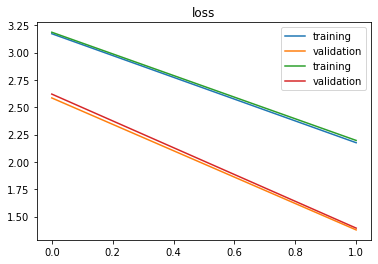

In [35]:
print(f' Starting CV with: CV = {cv}, shuffle = {shuffle}, random_state = {random_state} \n and model parameters: epochs = {epochs}, batch_size =\
 {batch_size}, max_time = {max_time}, mask_value = {mask_value}')

rmse_train = []
r2_train = []
mae_train = []

rmse_test = []
r2_test = []
mae_test = []

train_all = []
test_all = []

file = 'RUL_SA_prelim_results_cmapss_1st_linear.csv'
columns = ['fold', 'rmse_train', 'mae_train', 'r2_train', 'rmse_test', 'mae_test', 'r2_test']
results = pd.DataFrame(columns=columns)

fold_count = 0
      
start = time.time()

for train_units, test_units in kf.split(train_x_orig.unit_number.unique()):
    
    fold_count+= 1
    print(f'Fold: {fold_count}')
    tf.random.set_seed(fold_count)
    
#     print(len(train_units))
#     print(len(test_units))
#     print(train_units)
#     print(test_units)
    
    
    
    # Selecting data
    train_index = train_x_orig[train_x_orig.unit_number.isin(train_units)].index
    test_index = train_x_orig[train_x_orig.unit_number.isin(test_units)].index # careful this was wrongly test_x_orig. It should be train_x_orig

    X_train = train_x_orig.iloc[train_index]
    X_test_or = train_x_orig.iloc[test_index] # careful this was wrongly test_x_orig. It should be train_x_orig
    
    X_train.reset_index(drop=True, inplace=True)
    X_test = X_test_or.reset_index(drop=True, inplace=False) # changed for debugging
    
    
    # Truncating test data randomly
    X_test_trunc = []
    test_y = []
    max_cycle = []
    test_index = [] # for debugging purposes
    temp_or_test_cycles = []
    for i in set(X_test.unit_number.unique()):
        np.random.seed(i)
#         print(i)
        temp_df = X_test[X_test.unit_number==i]
        temp_df.reset_index(drop=True, inplace=True) # important
        length = temp_df.shape[0]
        temp_or_test_cycles.append(length)
        level = np.random.choice(np.arange(5, 96), 1)[0]  
        r = np.int(length*(1-level/100))
        test_index.append(X_test_or[X_test_or.unit_number==i].index.tolist()[:r+1]) # check this with train_x_orig instead of X_test_or (probably it's the same)
        temp_df = temp_df.truncate(after=r)
        max_cycle.append(temp_df.shape[0])
        X_test_trunc.append(temp_df)
#         if max_cycle[-1] <= length/2:
#             test_y.append(130) # value taken from Heimes et al. (2008)

#         else:
#             p = (0 - 130) / (length - length/2)
#             rul = p * max_cycle[-1] - p * length
#             test_y.append(rul)
    test_index = [item for sublist in test_index for item in sublist]
#     print('\n')
#     print(len(test_index))
#     print(test_index)
    X_test_trunc = pd.concat(X_test_trunc)
    X_test_trunc.reset_index(drop=True, inplace=True)
#     print(X_test_trunc.shape)
#     test_y_rul = np.array(test_y) # commented for debugging
#     test_y_rul = test_y_rul.reshape(test_y_rul.shape[0], 1) 
#     test_y = test_y_rul # (comment out when not using event)
#     test_y_event = np.repeat(1, test_y_rul.shape[0]).reshape(test_y_rul.shape[0], 1) # (uncomment when adding event)
#     test_y = np.concatenate([test_y_rul, test_y_event], axis=1) # (uncomment when adding event)
   
    # Pre-processing data
    scaler=pipeline.Pipeline(steps=[
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())])

    train = X_train.copy()
    train = np.concatenate([train[['unit_number', 'time']], scaler.fit_transform(train[feature_cols])], axis=1)
    
    test = X_test_trunc.copy()
    test = np.concatenate([test[['unit_number', 'time']], scaler.transform(test[feature_cols])], axis=1)
    
    
    # Preparing data for the RNN (numpy arrays)
    train_x, train_y = build_data(units=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time,
                                  is_test=False, mask_value=mask_value, original_data=None, label='nonlinear')

    test_x, test_y = build_data(units=test[:, 0], time=test[:, 1], x=test[:, 2:], max_time=max_time,
                       is_test=True, mask_value=mask_value, original_data=X_test_or, label='nonlinear') 
     
    # initialization
    tte_mean_train = np.nanmean(train_y)#[:, 0]) # (uncomment when adding event)
    mean_u = 1.0 #np.nanmean(train_y[:, 1]) # (uncomment when adding event)

    # Initialization value for alpha-bias
#     init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0))
#     init_alpha = init_alpha / mean_u
    # print('tte_mean_train', tte_mean_train, 'init_alpha: ', init_alpha, 'mean uncensored train: ', mean_u)
    init_alpha = None

    print('train_x', train_x.shape, 'train_y', train_y.shape, 'test_x', test_x.shape, 'test_y', test_y.shape)
    
    # training
    model, history = network(train_x, train_y, test_x, test_y, mask_value, epochs, batch_size, init_alpha)
    
    plt.plot(history.history['loss'],    label='training')
    plt.plot(history.history['val_loss'],label='validation')
    plt.title('loss')
    plt.legend()
    
    # predicting the rul on the train fold
    train_predict = model.predict(train_x)
    train_predict = np.resize(train_predict, (train_x.shape[0], 2))
    train_result = np.concatenate((train_y, train_predict), axis=1)
    train_results_df = pd.DataFrame(train_result, columns=['T', 'alpha', 'beta']) # (add 'E' for event)
    train_results_df['unit_number'] = train_x_orig.iloc[train_index]['unit_number'].to_numpy()
#     train_results_df['unit_number'] += 1
    train_results_df['time'] = train_x_orig.iloc[train_index]['time'].to_numpy()
#     train_results_df['time'] += 1
    
    train_results_df['predicted_mu'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
#     train_results_df['predicted_median'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
#     train_results_df['predicted_mode'] = train_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

    
    # predicting the rul on the test fold
    test_predict = model.predict(test_x)
    test_predict = np.resize(test_predict, (test_x.shape[0], 2))
    test_result = np.concatenate((test_y, test_predict), axis=1)
    test_results_df = pd.DataFrame(test_result, columns=['T',  'alpha', 'beta']) # (add 'E' for event)
#     print(test_results_df.shape)
#     test_results_df['unit_number'] = train_x_orig.iloc[test_index]['unit_number'].to_numpy() # Note the train_x_orig
#     test_results_df['time'] = train_x_orig.iloc[test_index]['time'].to_numpy()
    
    test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
#     test_results_df['predicted_median'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_median(row[0], row[1]), axis=1)
#     test_results_df['predicted_mode'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mode(row[0], row[1]), axis=1)

    train_all.append(train_results_df)
    test_all.append(test_results_df)
    
    # performance evaluation
    # train:
    rmse_train.append(np.sqrt(mean_squared_error(train_results_df['predicted_mu'], train_results_df['T'])))
    mae_train.append((mean_absolute_error(train_results_df['predicted_mu'], train_results_df['T'])))
    r2_train.append(r2_score(train_results_df['predicted_mu'], train_results_df['T']))
    
    # test:
    rmse_test.append(np.sqrt(mean_squared_error(test_results_df['predicted_mu'], test_results_df['T'])))
    mae_test.append((mean_absolute_error(test_results_df['predicted_mu'], test_results_df['T'])))
    r2_test.append(r2_score(test_results_df['predicted_mu'], test_results_df['T']))
    
    # registering results
    results['fold'] = [fold_count]
    results['rmse_train'] = [rmse_train[-1]]
    results['mae_train'] = [mae_train[-1]]
    results['r2_train'] = [r2_train[-1]]
    results['rmse_test'] = [rmse_test[-1]]
    results['mae_test'] = [mae_test[-1]]
    results['r2_test'] = [r2_test[-1]]   
    
    print(results)
    
    if os.path.isfile(file):
        results.to_csv('./' + file, mode='a', index=False, header=False)
    else:
        results.to_csv('./' + file, mode='w', index=False, header=True)
    
    k.clear_session()
    del model
    
#     break

end = time.time()
print(f'Elapsed time: {(end - start)/60} minutes')

In [94]:
train_all

[           T       alpha      beta  unit_number  time  predicted_mu
 0      130.0  225.384445  0.741117            0     0    271.033182
 1      130.0   22.803499  0.349771            0     1    114.943495
 2      130.0    0.978462  0.209507            0     2     80.107406
 3      130.0    0.756208  0.210045            0     3     60.663527
 4      130.0   44.019203  0.566205            0     4     71.745042
 ...      ...         ...       ...          ...   ...           ...
 10254    6.5   39.972069  0.848767           99   195     43.527321
 10255    5.2   40.370110  0.848933           99   196     43.955373
 10256    3.9   38.014442  0.849878           99   197     41.361704
 10257    2.6   37.119446  0.852141           99   198     40.321102
 10258    1.3   32.822025  0.853747           99   199     35.611457
 
 [10259 rows x 6 columns],
                 T      alpha      beta  unit_number  time  predicted_mu
 0      130.000000  34.299164  0.545602            1     0     59.1251

In [103]:
train_all[0].iloc[i]['predicted_mu']

271.0331820869582

In [104]:
train_all[1].iloc[i]['predicted_mu']

59.12515914735983

In [105]:
np.mean([train_all[0].iloc[i]['predicted_mu'], train_all[1].iloc[0]['predicted_mu']])

165.07917061715904

In [111]:
train_results_df.shape

(10372, 6)

In [107]:
mean_a_b = []
std_a_b = []

for i in range(train_all[0].shape[0]):
#     print(i)
    mean_a_b.append(np.mean([train_all[0].iloc[i]['predicted_mu'], train_all[1].iloc[i]['predicted_mu']]))
    std_a_b.append(np.std([train_all[0].iloc[i]['predicted_mu'], train_all[1].iloc[i]['predicted_mu']]))
    

In [112]:
mean_a_b.shape

(10259,)

In [109]:
mean_a_b = np.array(mean_a_b)
std_a_b = np.array(std_a_b)
div_a_b_up = mean_a_b + 2*std_a_b
div_a_b_do = mean_a_b - 2*std_a_b

In [110]:
mean_train_df = pd.DataFrame()
mean_train_df['unit_number'] = train_results_df['unit_number']
mean_train_df['time'] = train_results_df['time']
mean_train_df['mean'] = mean_a_b
mean_train_df['up'] = div_a_b_up
mean_train_df['do'] = div_a_b_do

ValueError: Length of values (10259) does not match length of index (10372)

In [30]:
max_cycle

[113, 92, 119, 73, 60, 176, 18, 150, 134, 25]

In [193]:
test_results_df.unit_number.unique()

array([34, 42, 11, 46, 81, 85, 23, 93, 62, 31])

In [137]:
test_results_df

T       alpha      beta  predicted_mu
0   98.347826  119.484360  0.997352    119.618816
1  130.000000  128.264496  0.997388    128.406886
2   78.461538  106.507690  0.997295    106.630156
3  130.000000  129.292007  0.997389    129.435466
4  130.000000  128.572510  0.997389    128.715196
5   96.352941  125.241463  0.997370    125.381422
6  130.000000  129.801620  0.997386    129.945836
7  109.053708  116.846703  0.997357    116.977971
8   59.913043   85.248291  0.997198     85.349854
9  130.000000  128.953247  0.997378    129.096940

In [125]:
np.sqrt(mean_squared_error(test_results_df['predicted_mu'], test_results_df['T']))

24.698624003751497

In [126]:
train_results_df

T       alpha      beta  unit_number  time  predicted_mu
0      130.000000  128.727158  0.995224            0     0    128.989575
1      130.000000  127.181038  0.997311            0     1    127.326400
2      130.000000  129.480362  0.997365            0     2    129.625348
3      130.000000  129.470352  0.997377            0     3    129.614681
4      130.000000  129.018921  0.997384            0     4    129.162366
...           ...         ...       ...          ...   ...           ...
21792    8.552632   18.222399  0.996630           99   147     18.248535
21793    6.842105   17.711758  0.996619           99   148     17.737242
21794    5.131579   15.549798  0.996516           99   149     15.572864
21795    3.421053   15.020833  0.996510           99   150     15.043148
21796    1.710526   14.422970  0.996482           99   151     14.444569

[21797 rows x 6 columns]

In [127]:
np.sqrt(mean_squared_error(train_results_df['predicted_mu'], train_results_df['T']))

10.223932680138091

In [705]:
train_results_df.iloc[:, 3] += 1

In [706]:
train_results_df.iloc[:, 5] += 1

In [29]:
train_results_df

T       alpha      beta  unit_number  time  predicted_mu
0      130.0  133.922546  0.992325            0     0    134.363755
1      130.0  138.883011  0.992435            0     1    139.333903
2      130.0  134.149185  0.995223            0     2    134.422690
3      130.0  131.667786  0.996136            0     3    131.884537
4      130.0  130.685059  0.996182            0     4    130.897591
...      ...         ...       ...          ...   ...           ...
18592    6.5    4.537479  0.994633           99   195      4.547885
18593    5.2    3.944496  0.994573           99   196      3.953645
18594    3.9    3.413302  0.994447           99   197      3.421404
18595    2.6    3.362139  0.994434           99   198      3.370138
18596    1.3    2.840694  0.994352           99   199      2.847554

[18597 rows x 6 columns]

In [708]:
max_time

50

In [35]:
test_x_orig

unit_number  time  op_setting_1  op_setting_2  op_setting_3  \
0                0     0        0.0023        0.0003         100.0   
1                0     1       -0.0027       -0.0003         100.0   
2                0     2        0.0003        0.0001         100.0   
3                0     3        0.0042        0.0000         100.0   
4                0     4        0.0014        0.0000         100.0   
...            ...   ...           ...           ...           ...   
13091           99   193        0.0049        0.0000         100.0   
13092           99   194       -0.0011       -0.0001         100.0   
13093           99   195       -0.0006       -0.0003         100.0   
13094           99   196       -0.0038        0.0001         100.0   
13095           99   197        0.0013        0.0003         100.0   

       sensor_measurement_1  sensor_measurement_2  sensor_measurement_3  \
0                    518.67                643.02               1585.29   
1                    518.67                641.71               1588.45   
2                    518.67                642.46               1586.94   
3                    518.67                642.44               1584.12   
4                    518.67                642.51               1587.19   
...                     ...                   ...                   ...   
13091                518.67                643.24               1599.45   
13092                518.67                643.22               1595.69   
13093                518.67                643.44               1593.15   
13094                518.67                643.26               1594.99   
13095                518.67                642.95               1601.62   

       sensor_measurement_4  sensor_measurement_5  ...  sensor_measurement_12  \
0                   1398.21                 14.62  ...                 521.72   
1                   1395.42                 14.62  ...                 522.16   
2                   1401.34                 14.62  ...                 521.97   
3                   1406.42                 14.62  ...                 521.38   
4                   1401.92                 14.62  ...                 522.15   
...                     ...                   ...  ...                    ...   
13091               1415.79                 14.62  ...                 520.69   
13092               1422.05                 14.62  ...                 521.05   
13093               1406.82                 14.62  ...                 521.18   
13094               1419.36                 14.62  ...                 521.33   
13095               1424.99                 14.62  ...                 521.07   

       sensor_measurement_13  sensor_measurement_14  sensor_measurement_15  \
0                    2388.03                8125.55                 8.4052   
1                    2388.06                8139.62                 8.3803   
2                    2388.03                8130.10                 8.4441   
3                    2388.05                8132.90                 8.3917   
4                    2388.03                8129.54                 8.4031   
...                      ...                    ...                    ...   
13091                2388.00                8213.28                 8.4715   
13092                2388.09                8210.85                 8.4512   
13093                2388.04                8217.24                 8.4569   
13094                2388.08                8220.48                 8.4711   
13095                2388.05                8214.64                 8.4903   

       sensor_measurement_16  sensor_measurement_17  sensor_measurement_18  \
0                       0.03                    392                   2388   
1                       0.03                    393                   2388   
2                       0.03                    393                   2388   
3                       0.03               

In [67]:
test_or = test_x_orig.copy()
test_or = np.concatenate([test_or[['unit_number', 'time']], scaler.transform(test_or[feature_cols])], axis=1)


# Preparing data for the RNN (numpy arrays)
test_or, _ = build_data(units=test_or[:, 0], time=test_or[:, 1], x=test_or[:, 2:], max_time=max_time,
                   is_test=True, mask_value=mask_value, original_data=test_x_orig)


100%|██████████| 100/100 [00:00<00:00, 1144.32it/s]


In [68]:
test_predict_or = model.predict(test_or)
test_predict_or = np.resize(test_predict_or, (test_or.shape[0], 2))
test_result_or = np.concatenate((test_y_orig, test_predict_or), axis=1)
test_results_df_or = pd.DataFrame(test_result_or, columns=['T', 'alpha', 'beta'])
test_results_df_or['unit_number'] = np.arange(1, test_results_df_or.shape[0]+1)

test_results_df_or['predicted_mu'] = test_results_df_or[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)

In [69]:
test_results_df

T       alpha      beta  predicted_mu
0   98.347826  107.352814  0.999998    107.352914
1  130.000000  135.433105  0.999998    135.433235
2   78.461538   94.444717  0.999998     94.444801
3  130.000000  139.397736  0.999998    139.397866
4  130.000000  138.068985  0.999998    138.069110
5   96.352941  109.175110  0.999998    109.175209
6  130.000000  137.400391  0.999998    137.400515
7  109.053708  102.019119  0.999998    102.019212
8   59.913043   76.020439  0.999998     76.020508
9  130.000000  137.207184  0.999998    137.207308

In [72]:
np.sqrt(mean_squared_error(test_results_df_or['predicted_mu'], test_results_df_or['T']))

22.138316858521872

Some plotting

In [40]:
def plot_weibull_predictions(results_df, unit):

#     fig, axarr = plt.subplots(3, figsize=(30,20))
    
    plt.figure(figsize=(30,10))

    t=np.arange(0,400)

    palette = sns.color_palette("RdBu_r", results_df.shape[0] + 1)
    color_dict = dict(enumerate(palette))

#     ax=axarr[0]
    
#     median_predictions = weibull_median(results_df['alpha'], results_df['beta'])
    mean_predictions = results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)
#     mode_predictions = weibull_mode(results_df['alpha'], results_df['beta'])
    x = results_df['time']
    
    plt.plot(x, results_df['T'], label='survival_time', color='black')

#     ax.plot(x, median_predictions, label='median_prediction')
    plt.plot(x, mean_predictions, label='mean_prediction')
#     ax.plot(x, mode_predictions, label='mode_prediction')
#     ax.set_title('MAP prediction Vs. true')
    

    plt.legend()
    
#     ax=axarr[1]
#     sns.distplot(results_df['T'] - mode_predictions, ax=ax)
#     ax.set_title('Error')

#     ax.plot(x, results_df['alpha'], label='alpha')
#     ax.legend()
    
#     ax = axarr[2]
#     ax.plot(x, results_df['beta'], label='beta')
#     ax.legend()
    
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.suptitle(unit)
    plt.show()

In [41]:
for unit_number, grp in test_results_df.groupby('unit_number'):
    plot_weibull_predictions(grp, unit_number)

KeyError: 'unit_number'

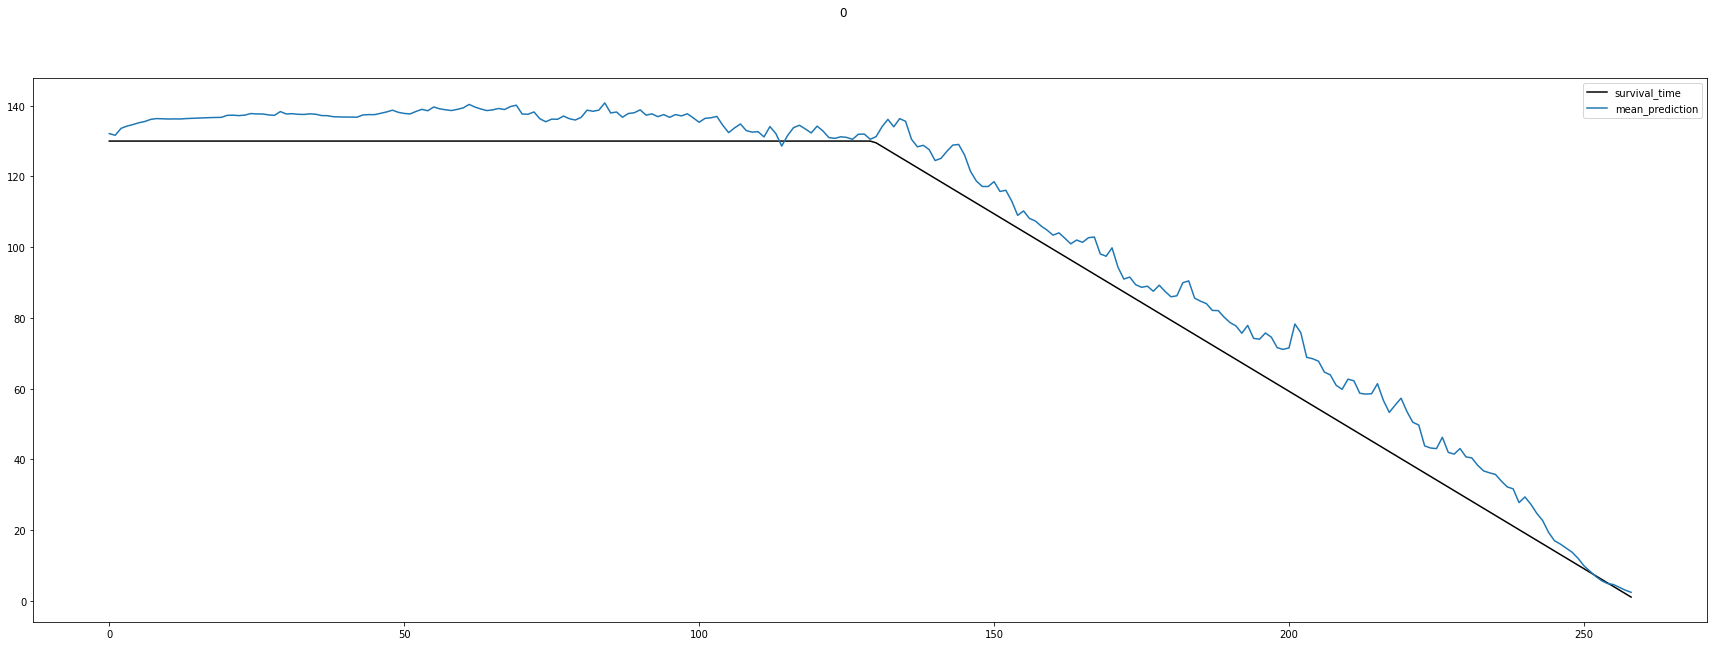

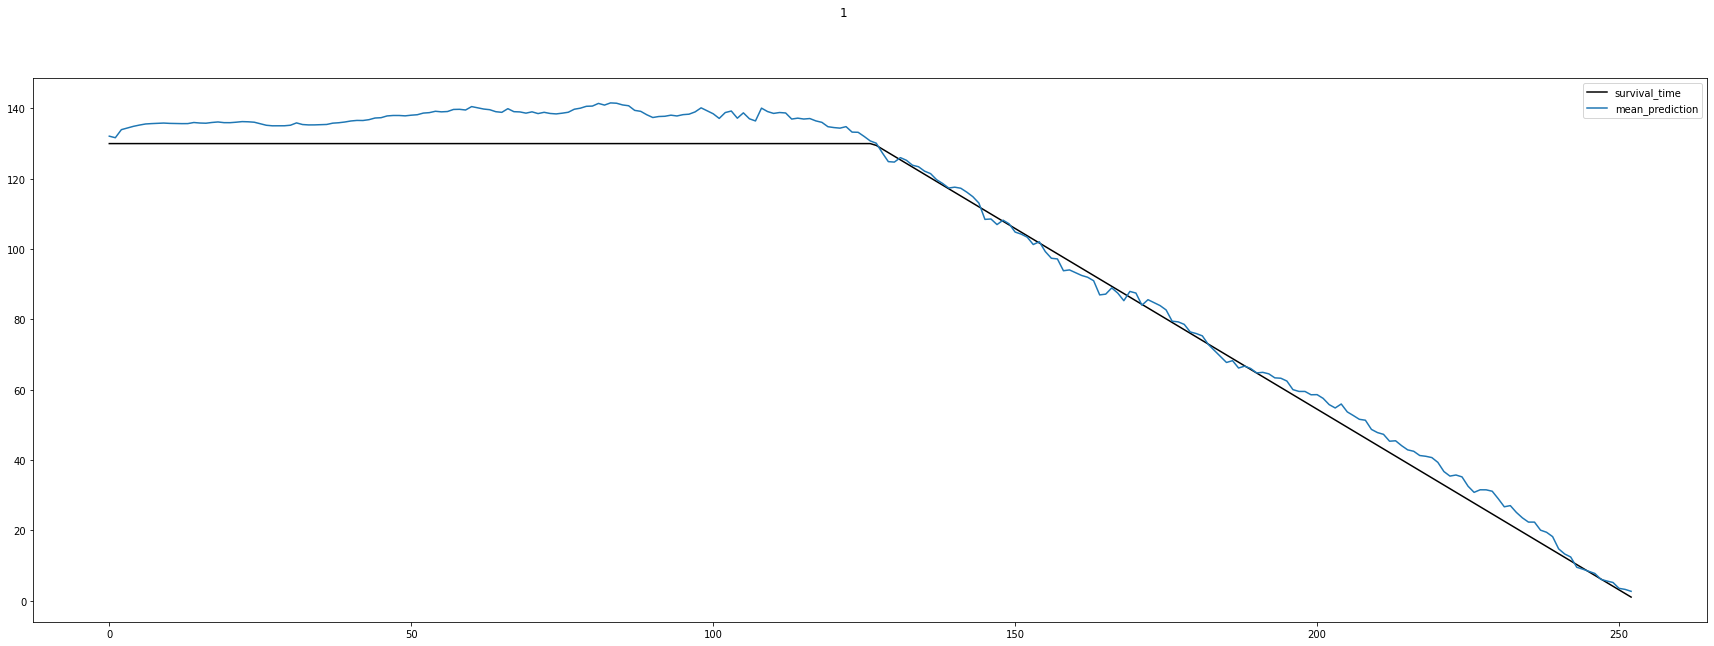

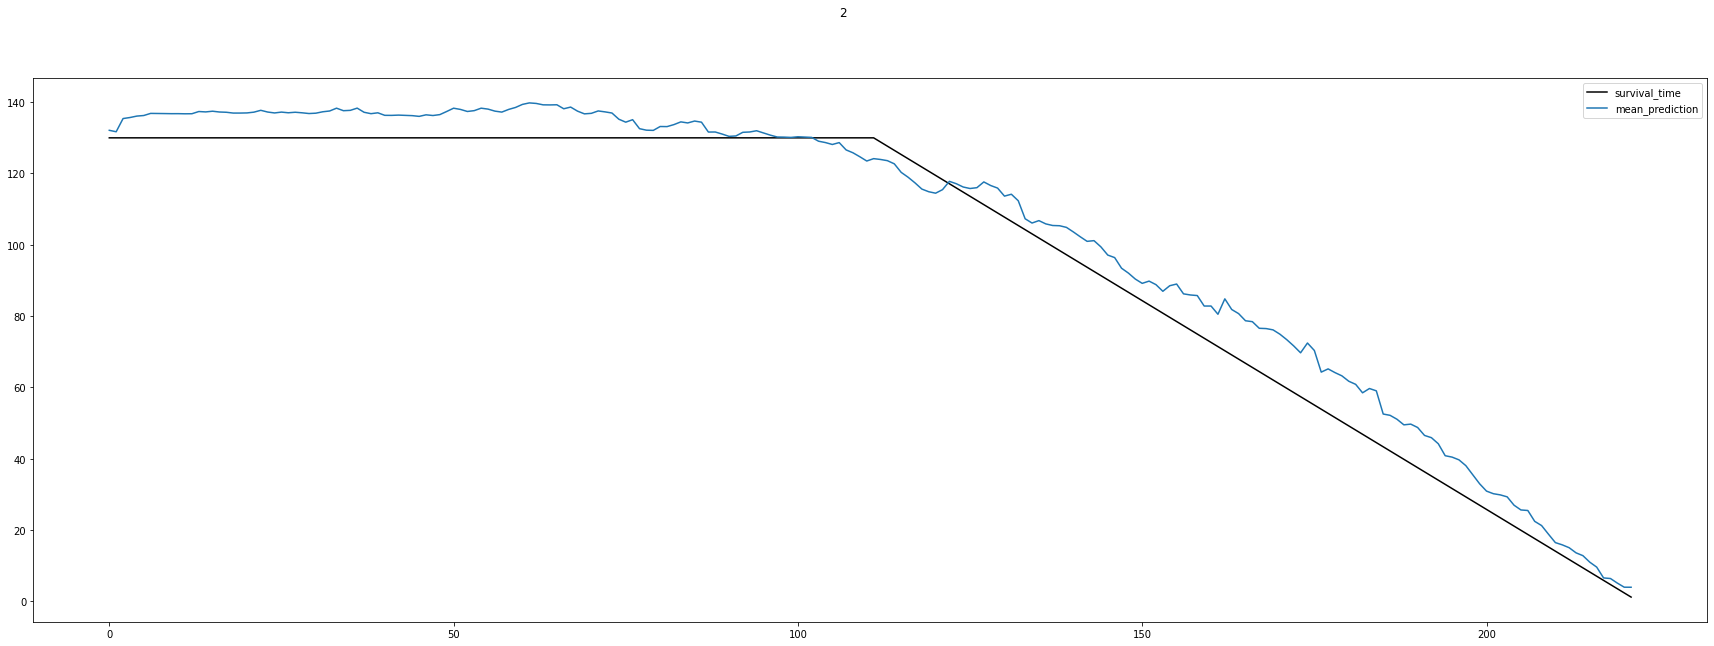

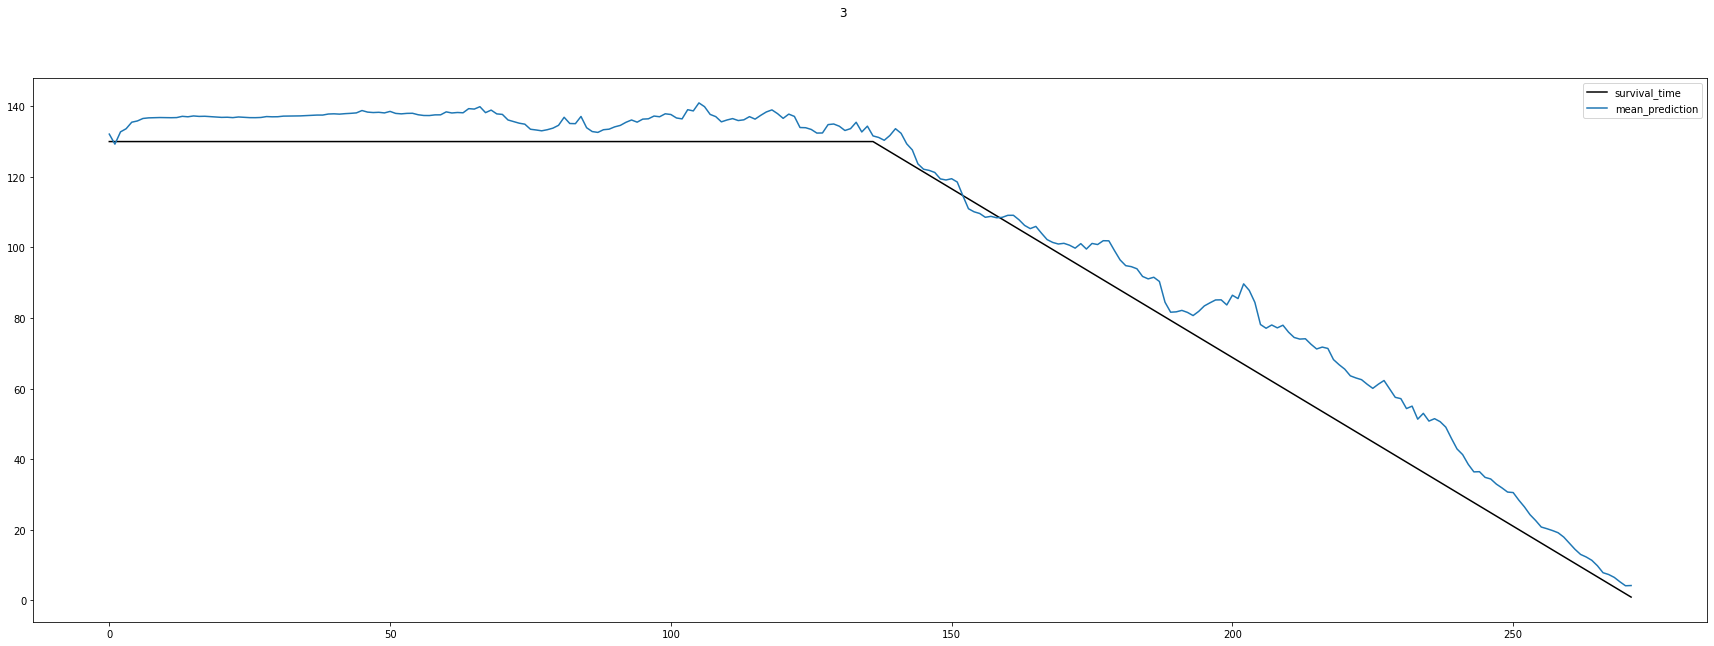

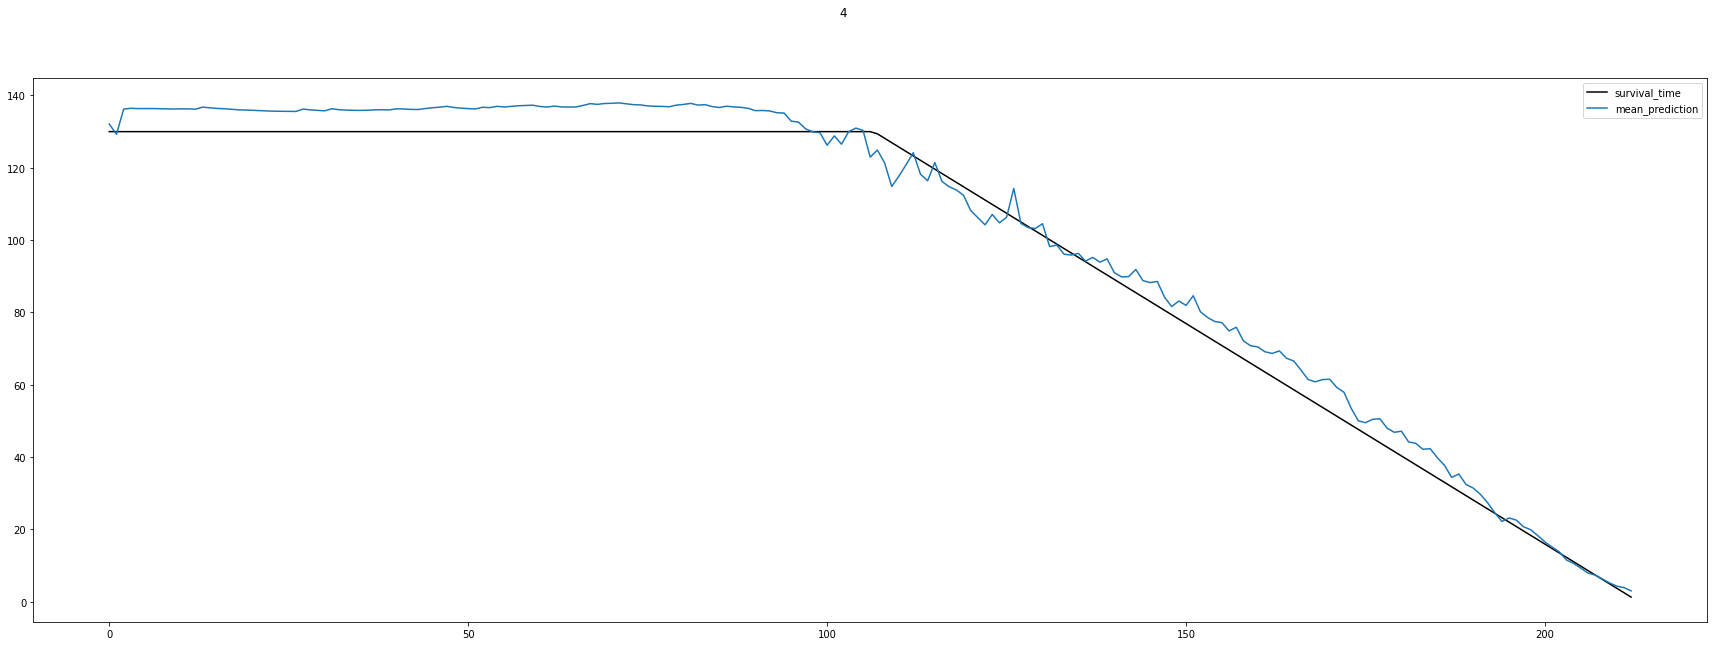

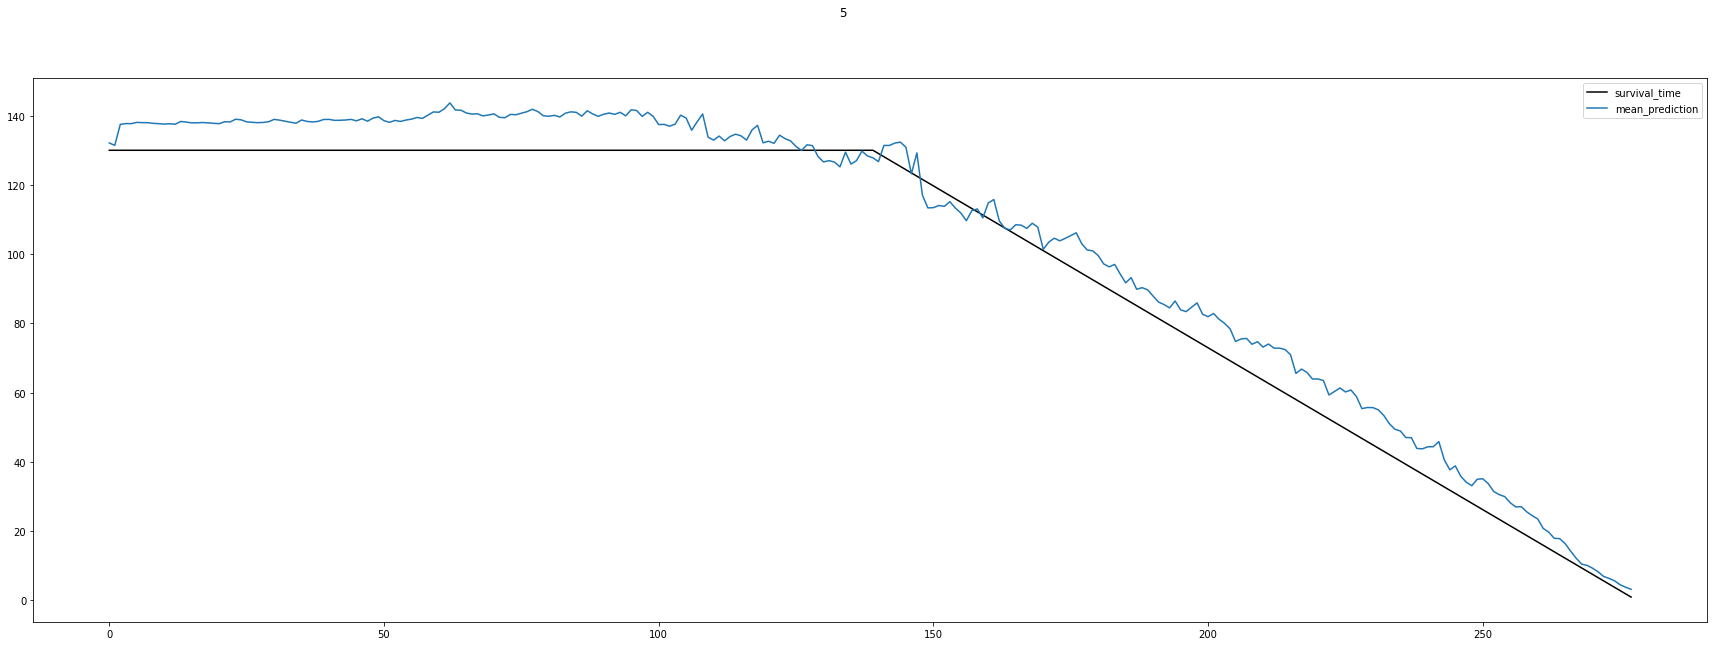

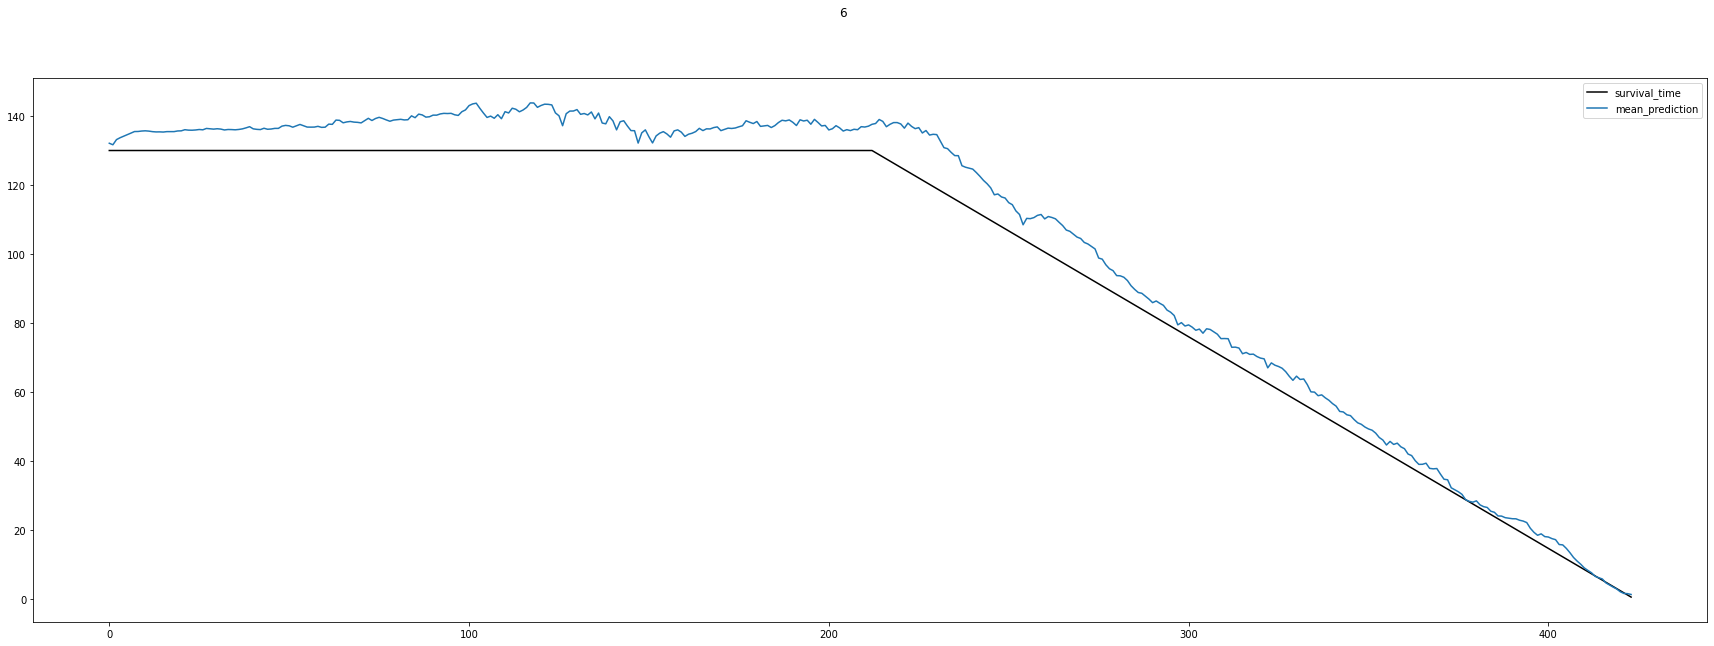

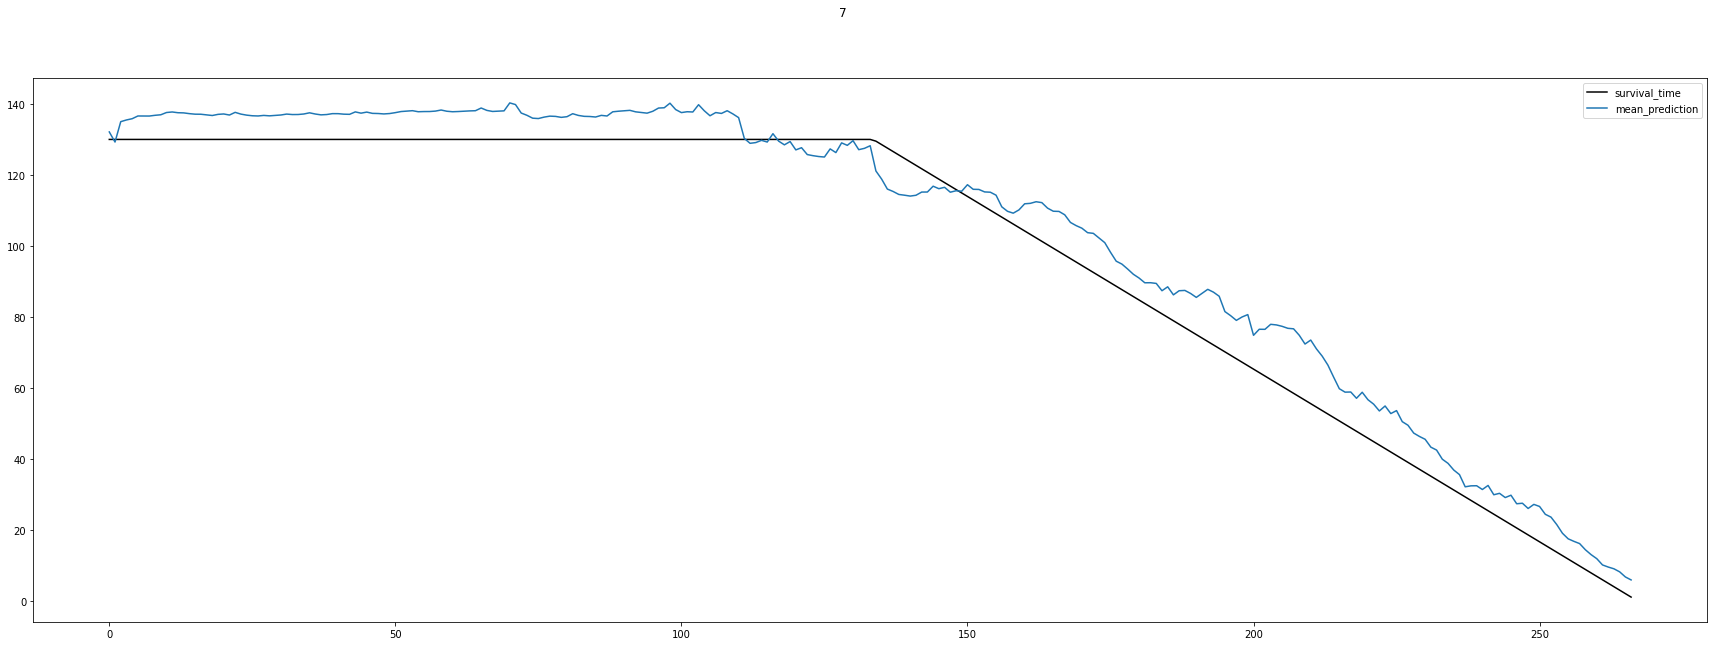

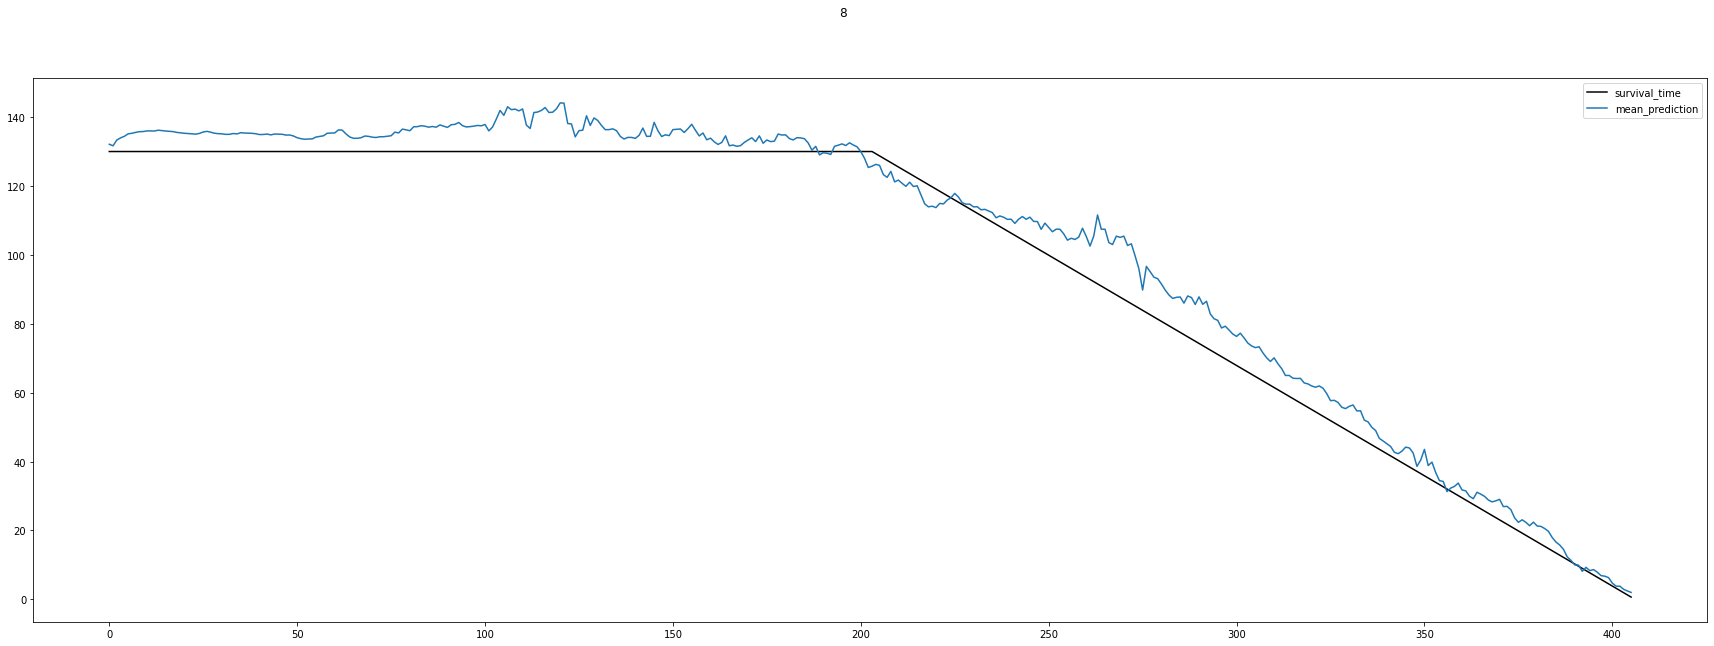

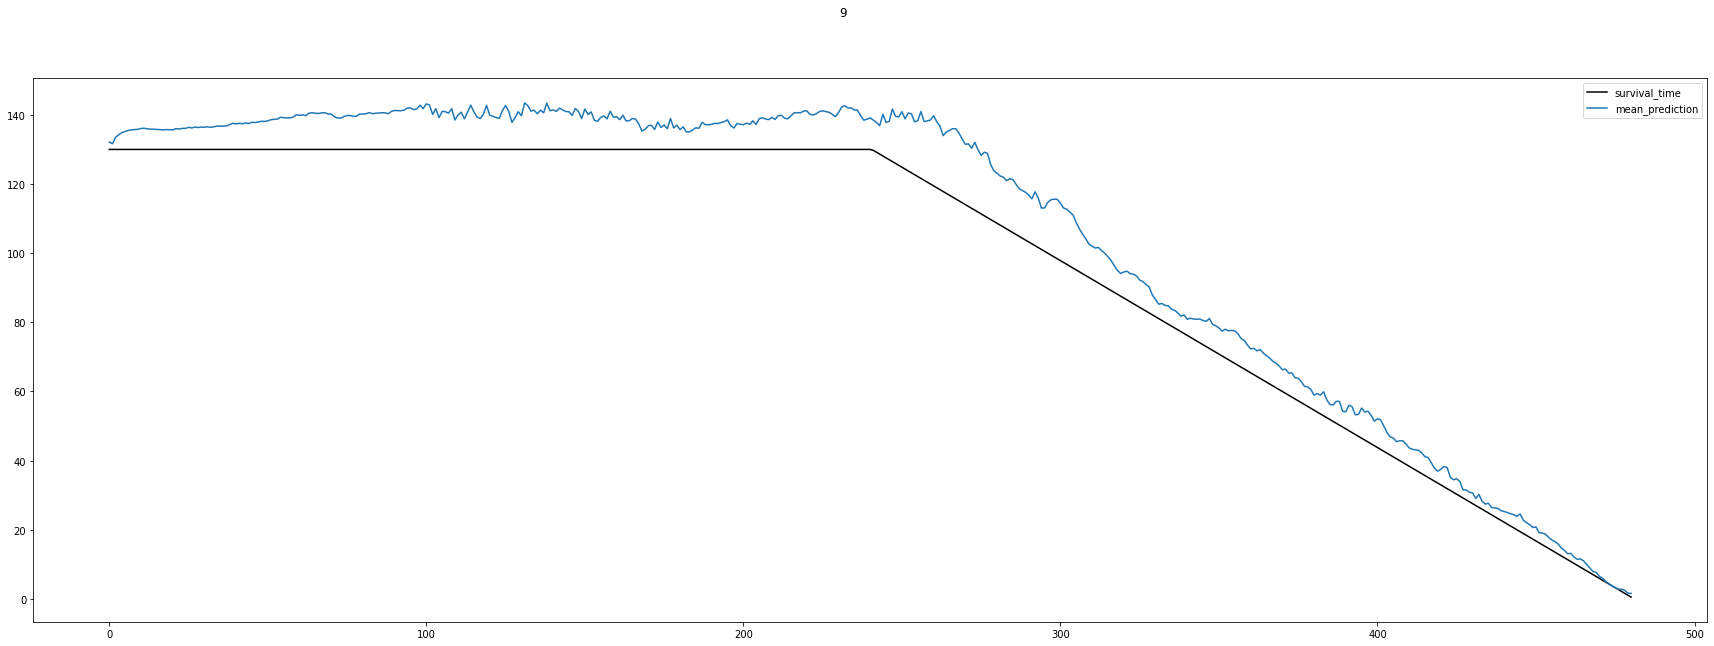

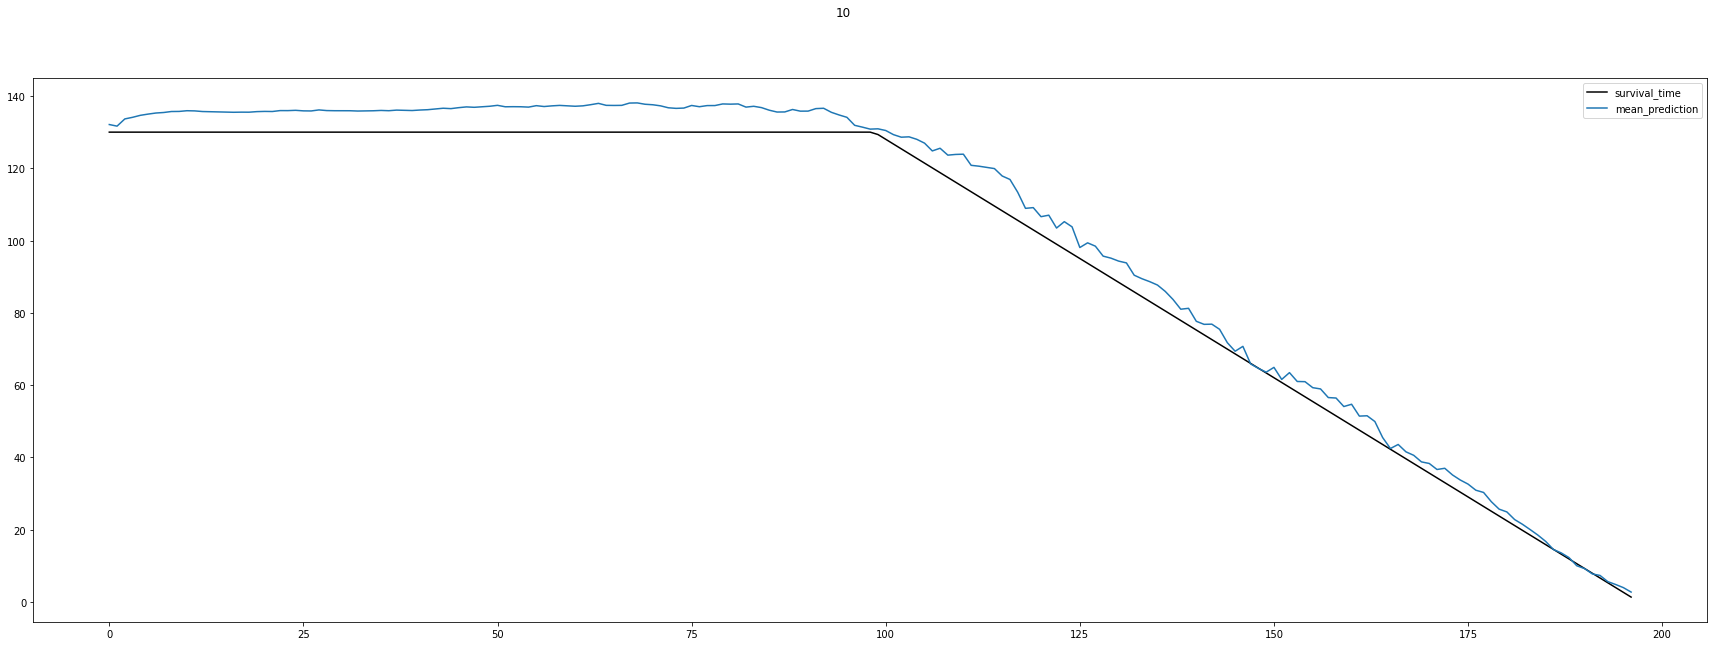

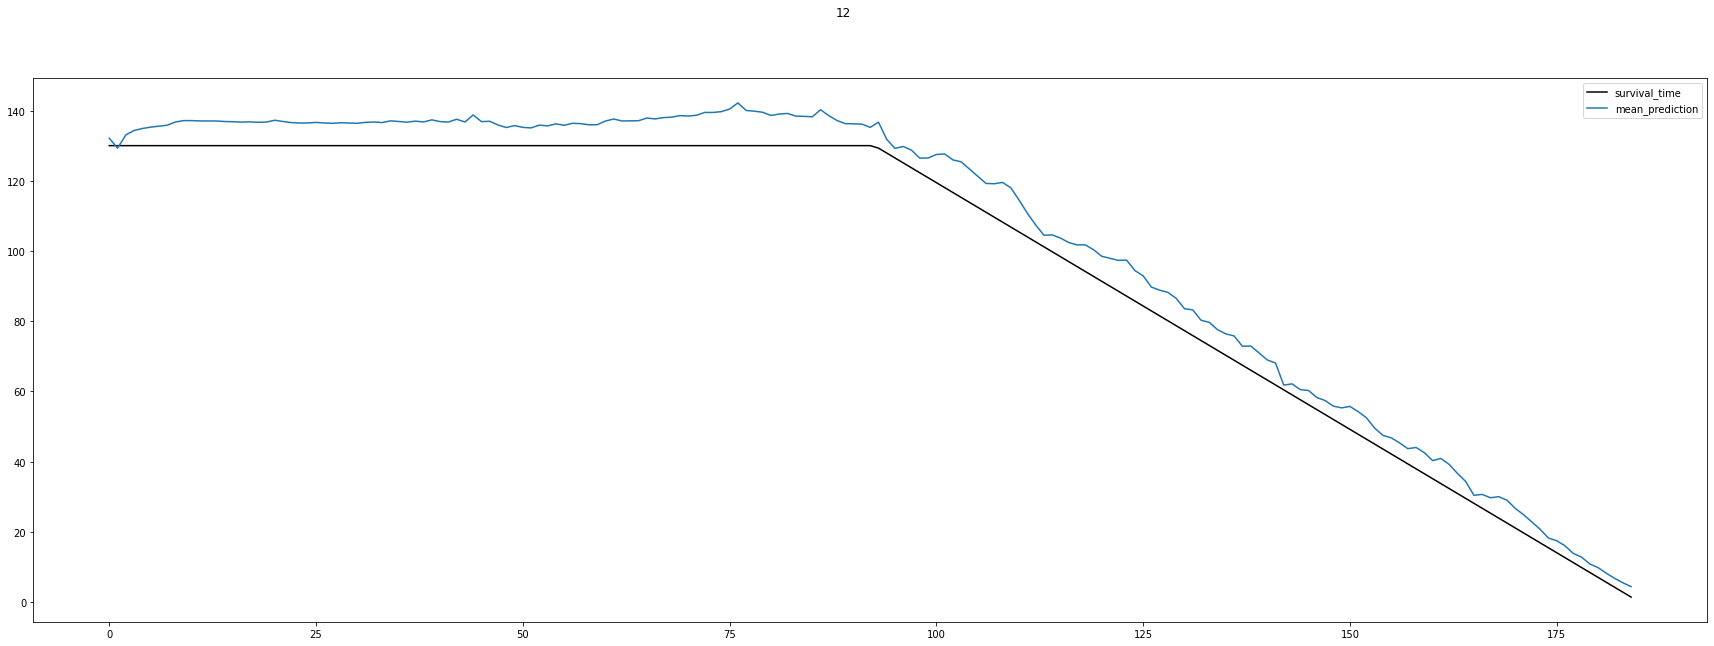

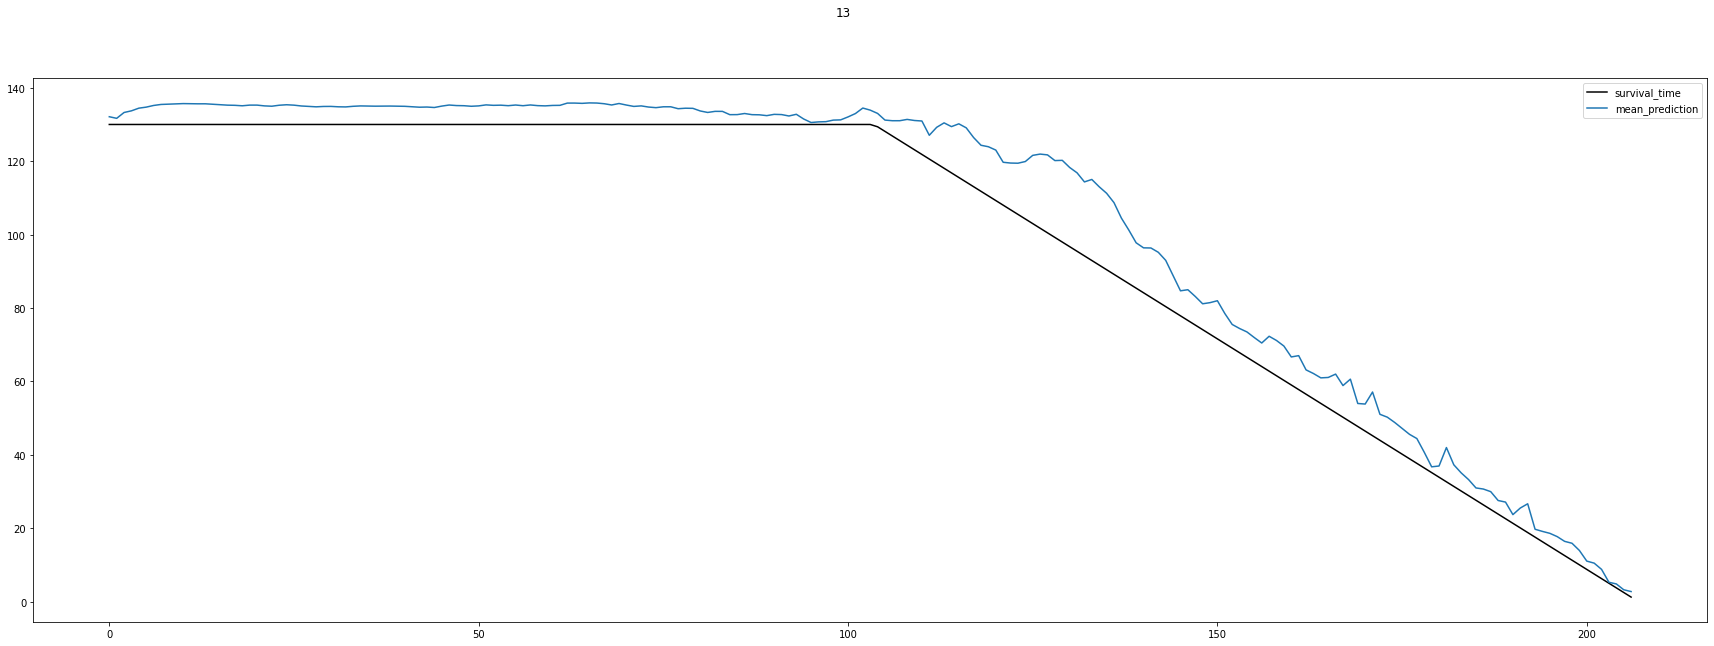

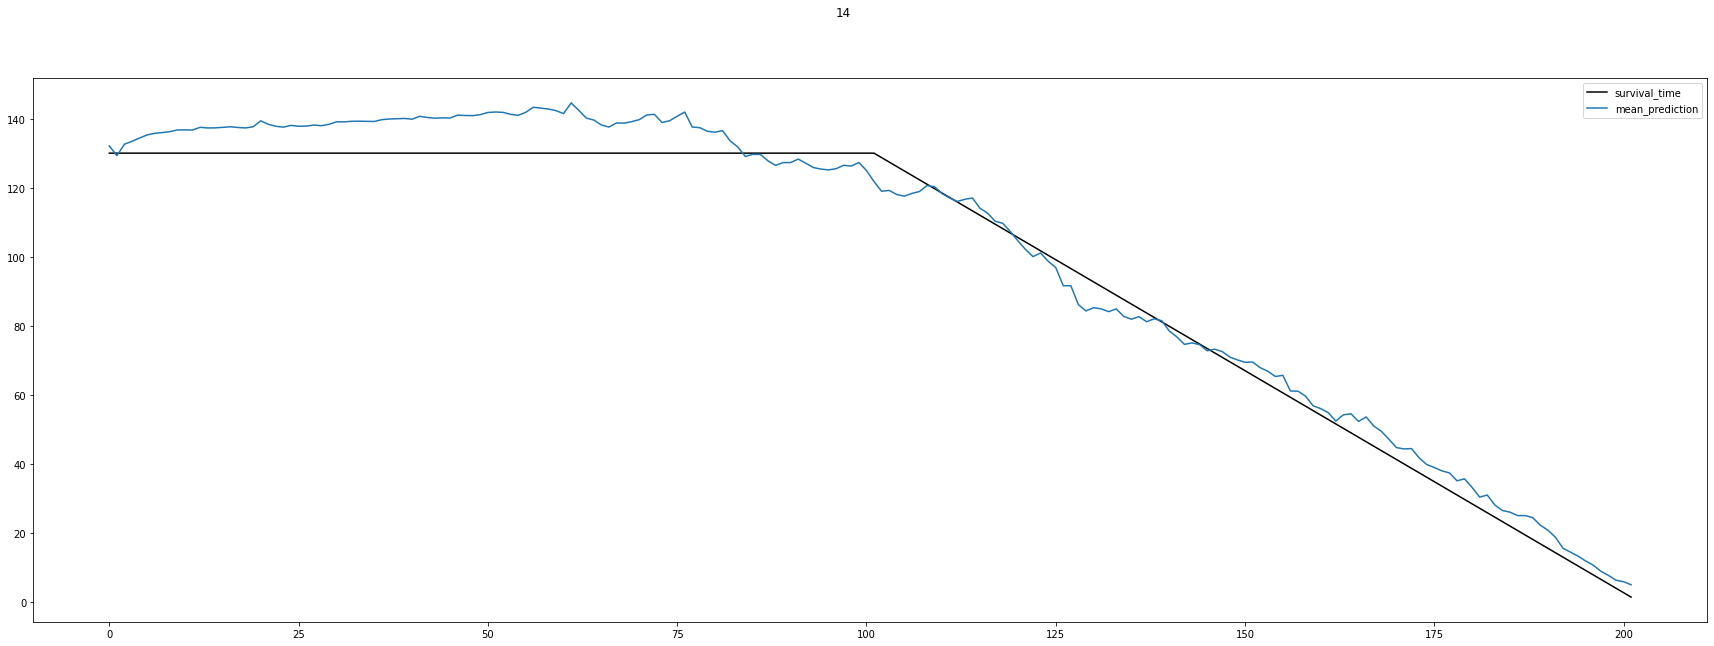

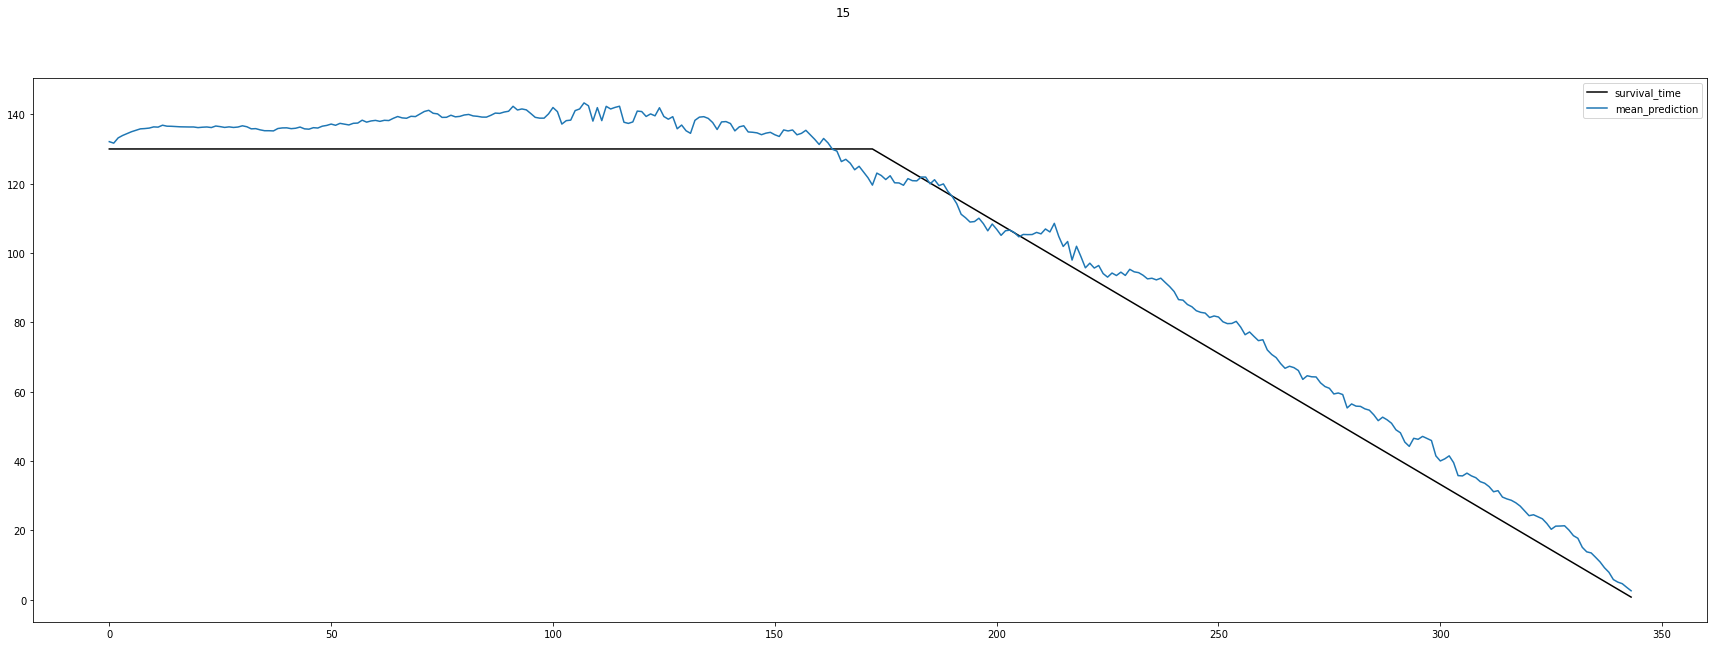

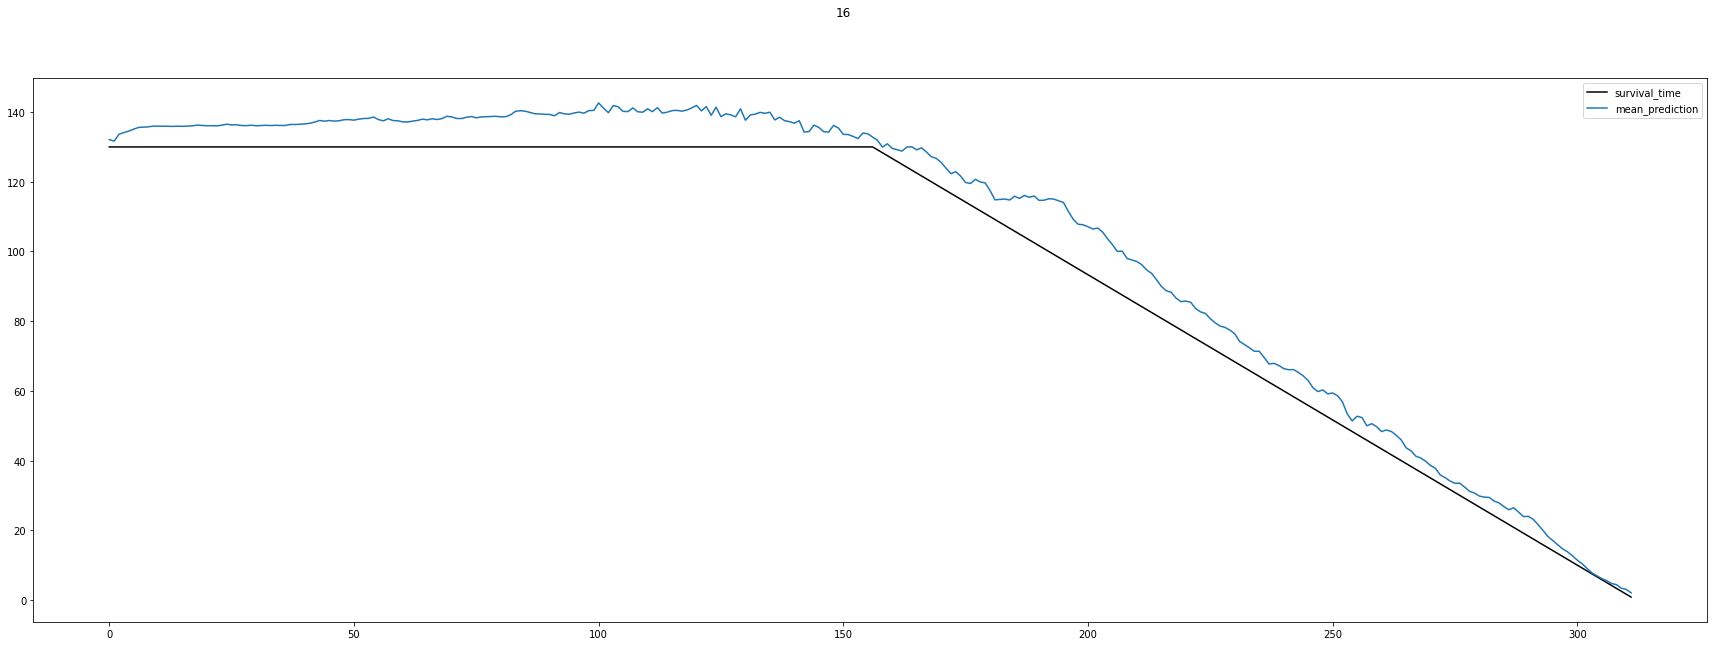

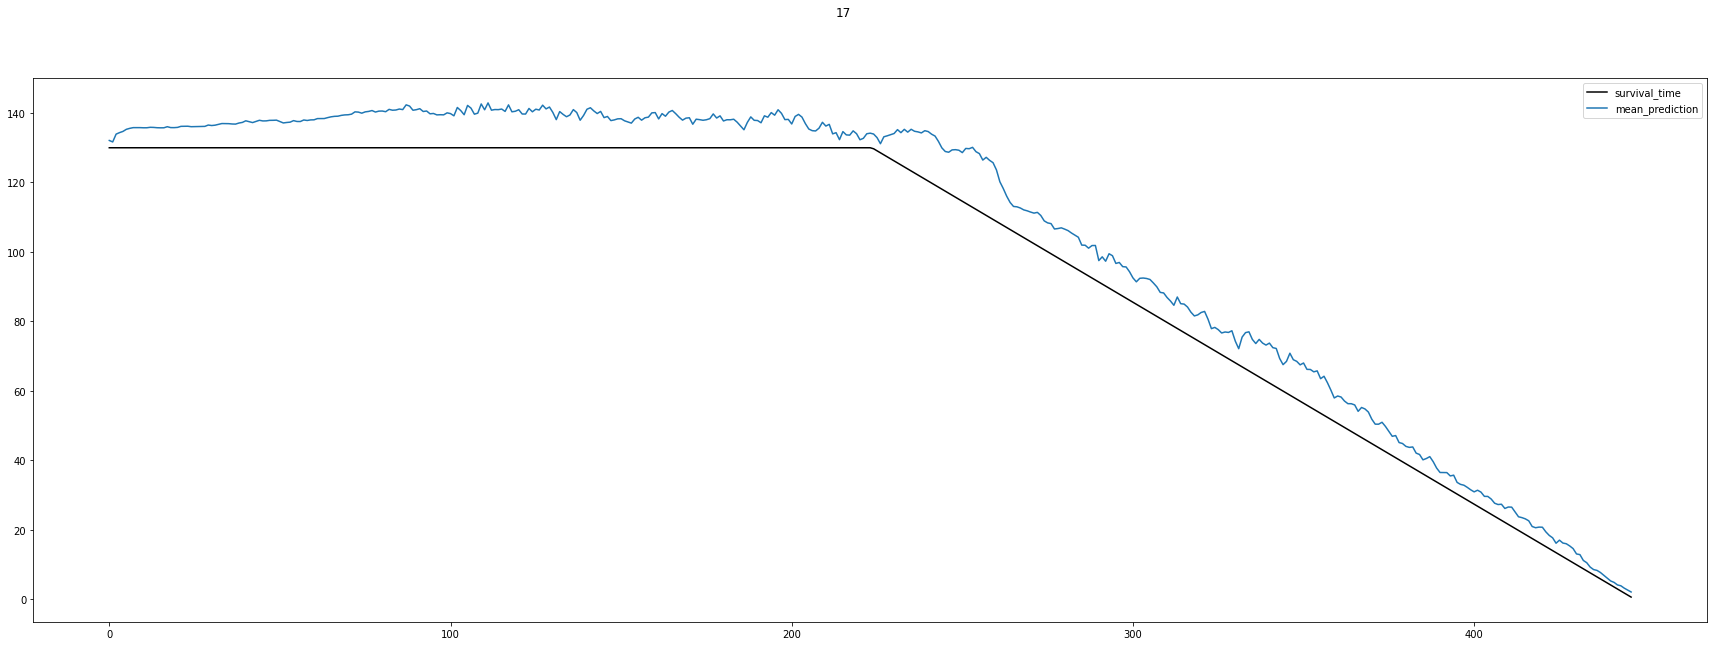

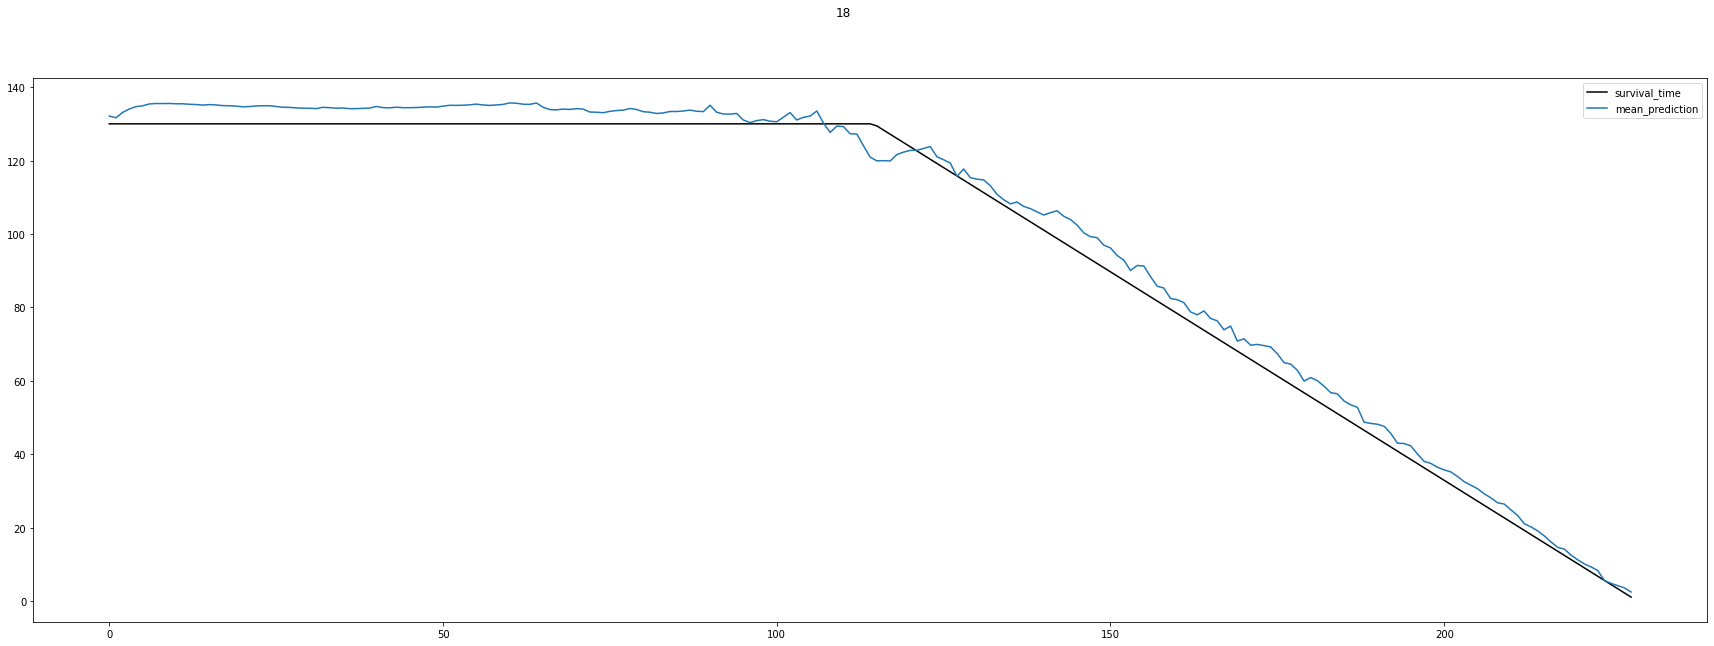

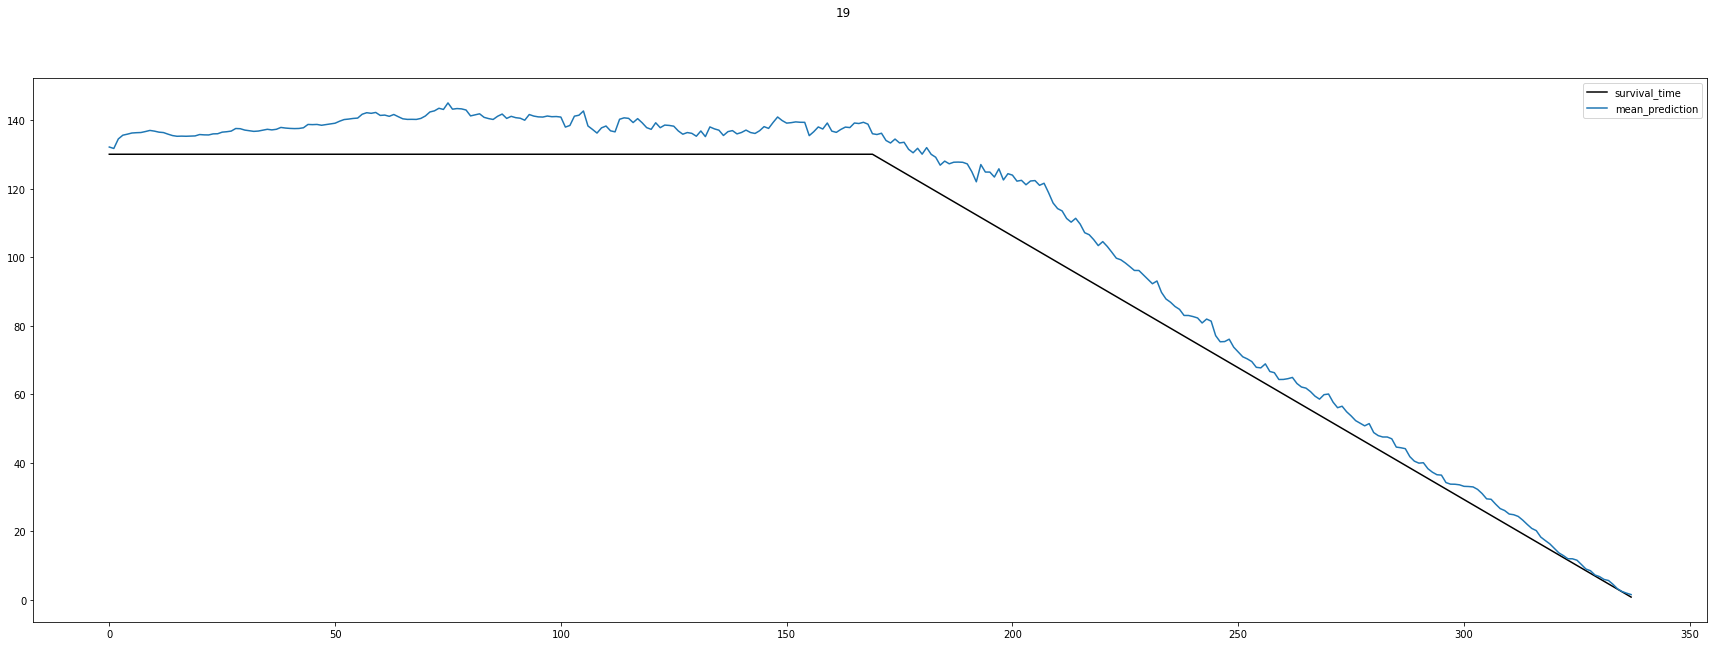

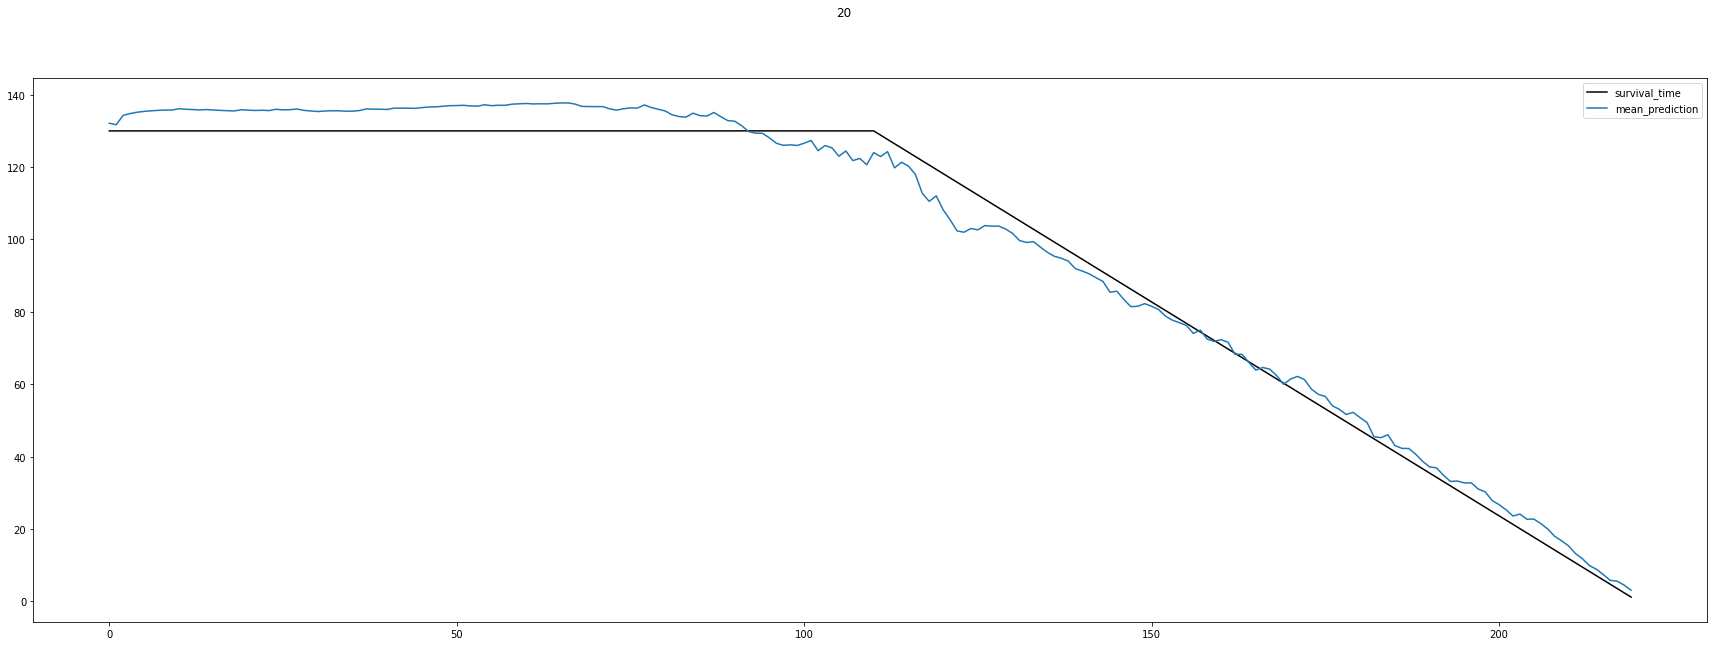

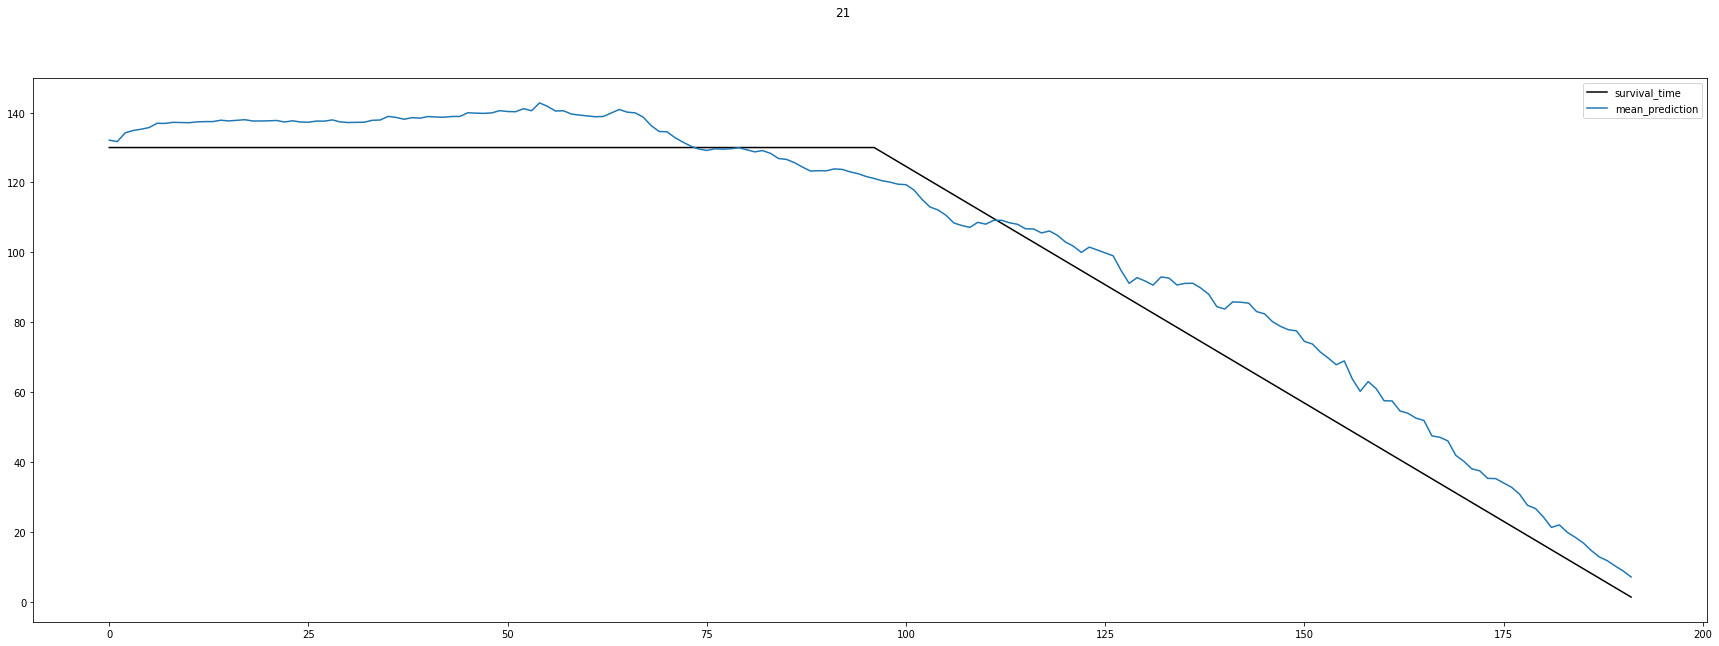

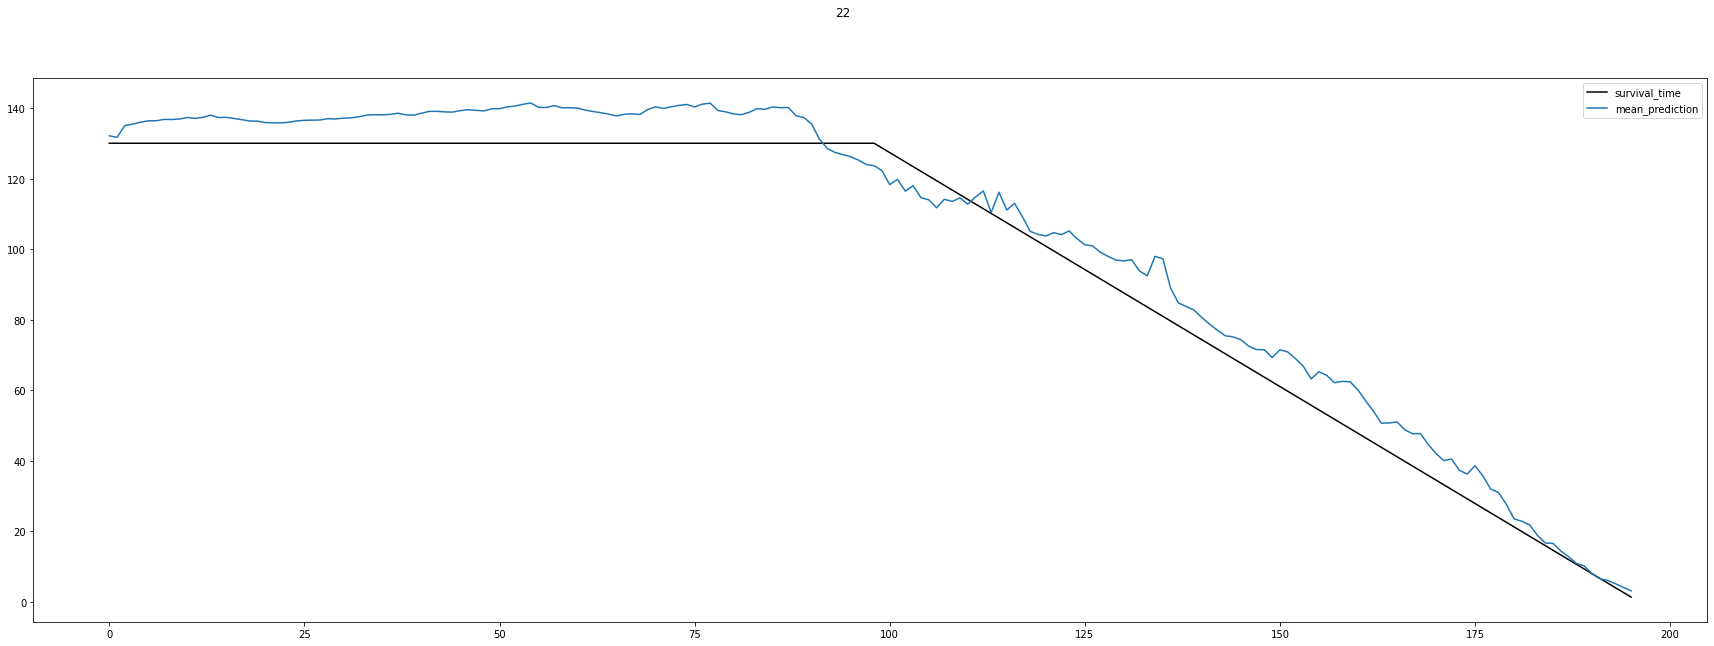

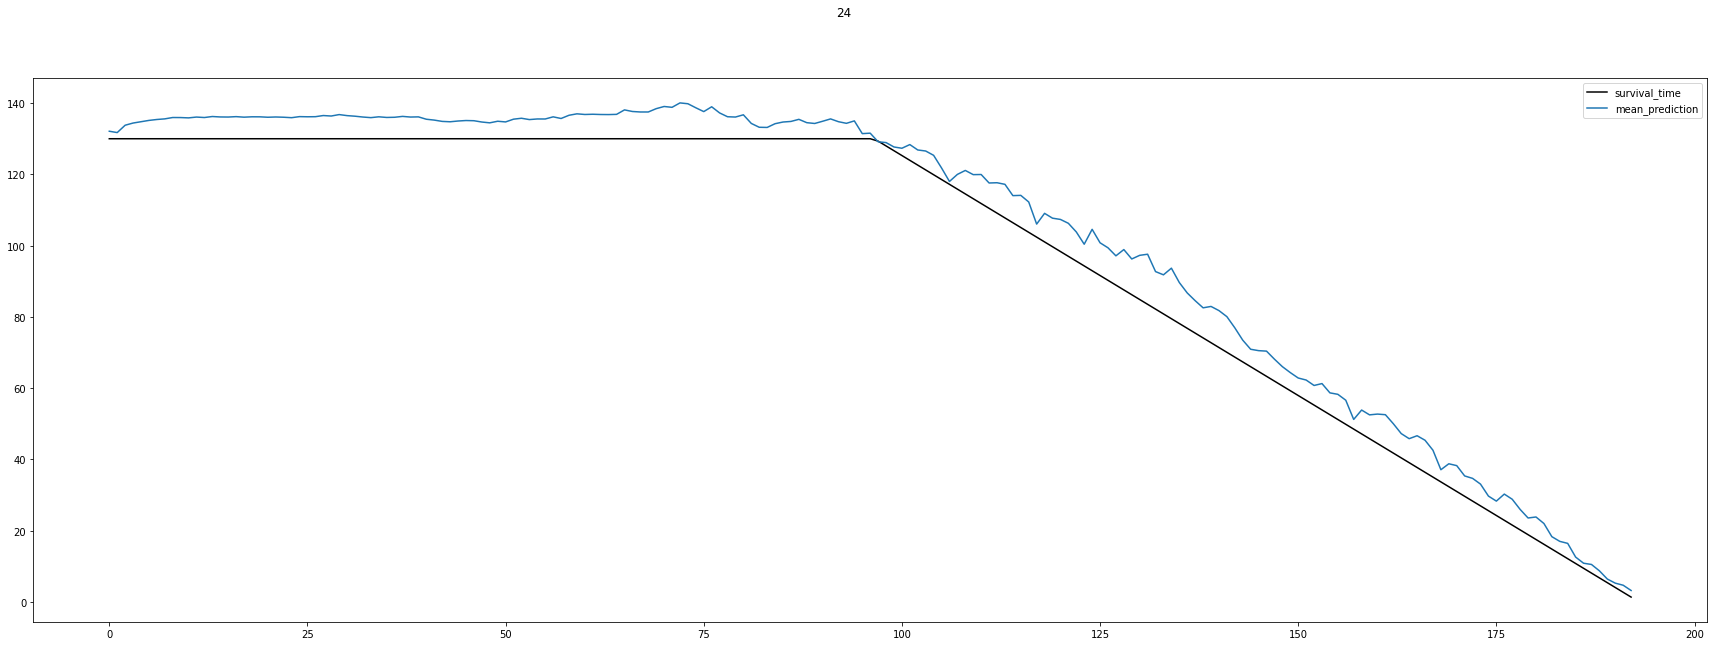

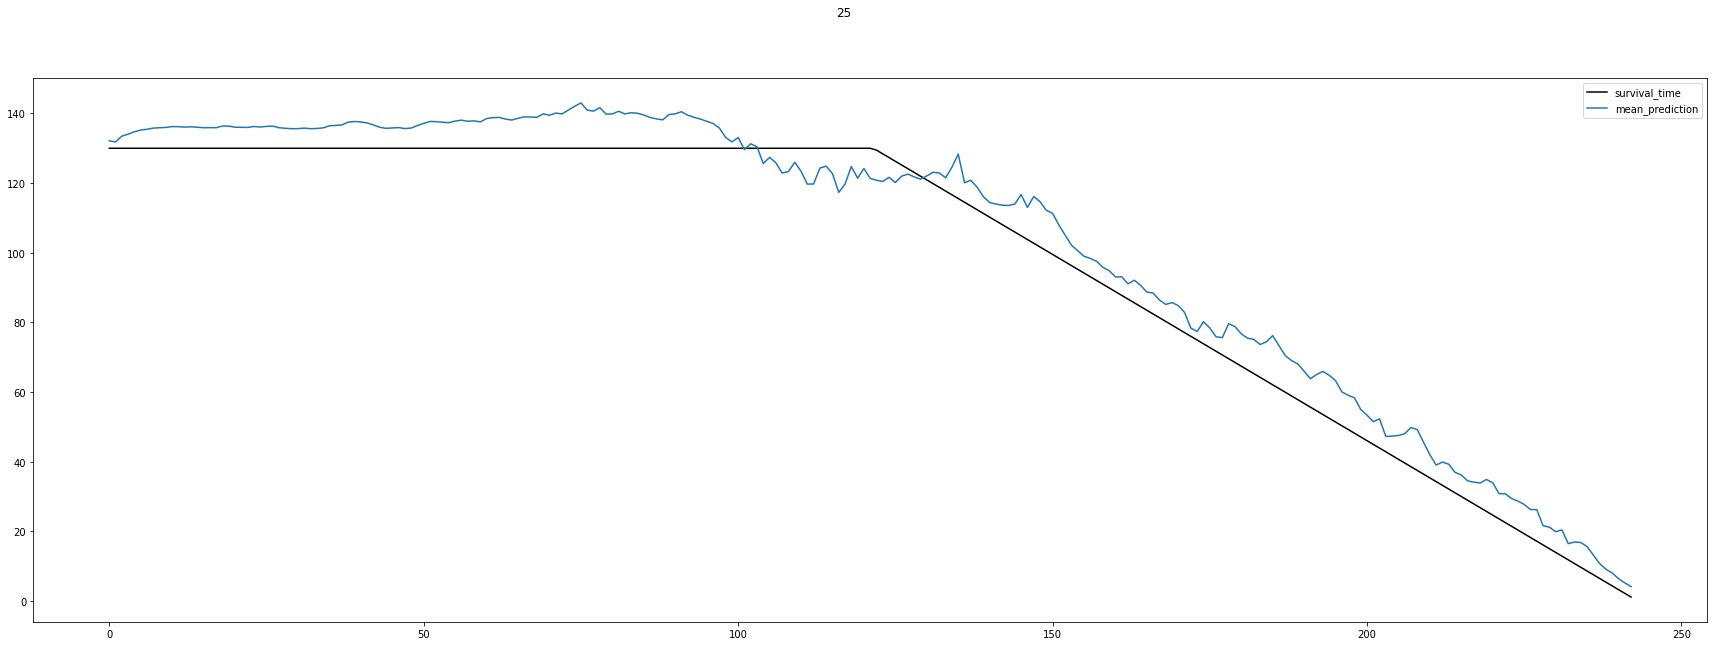

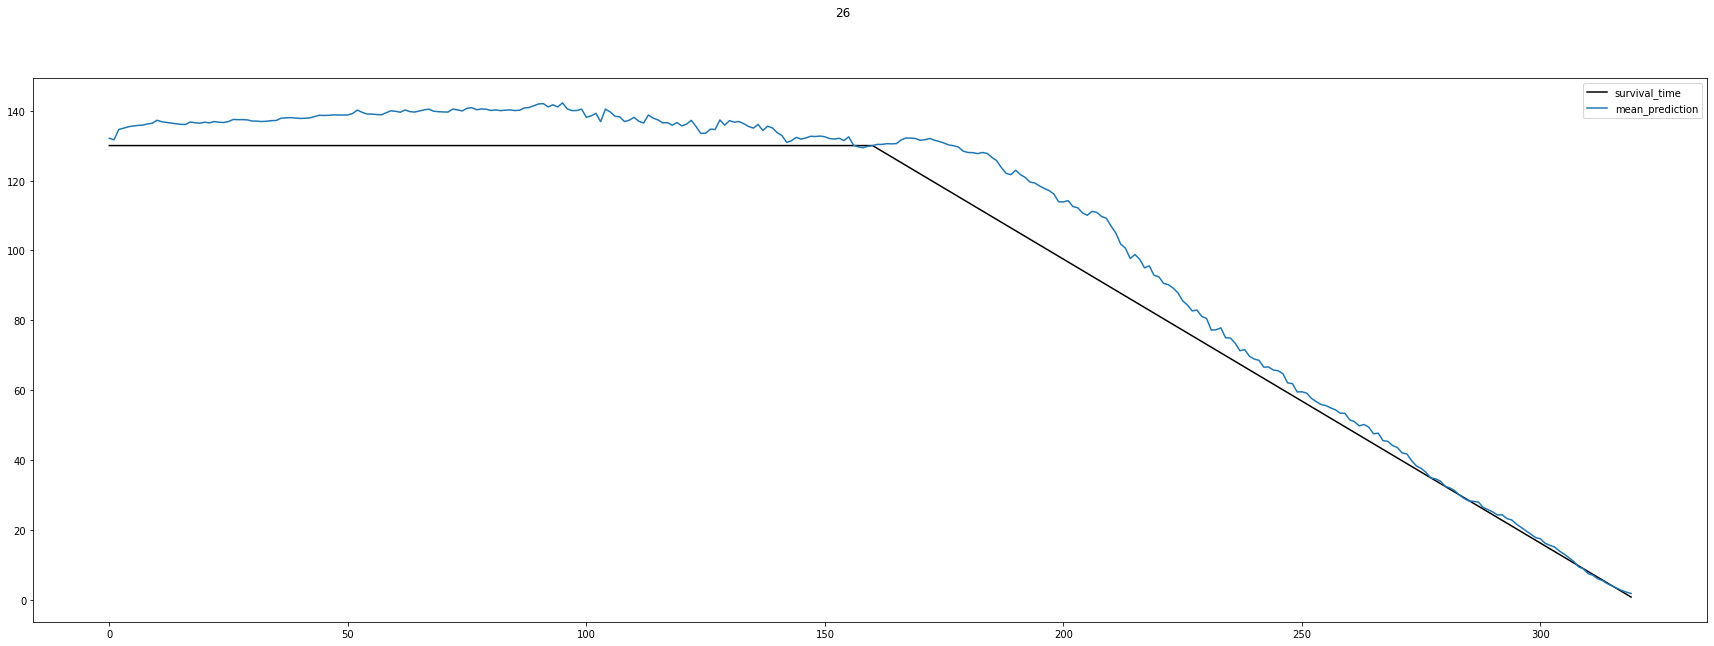

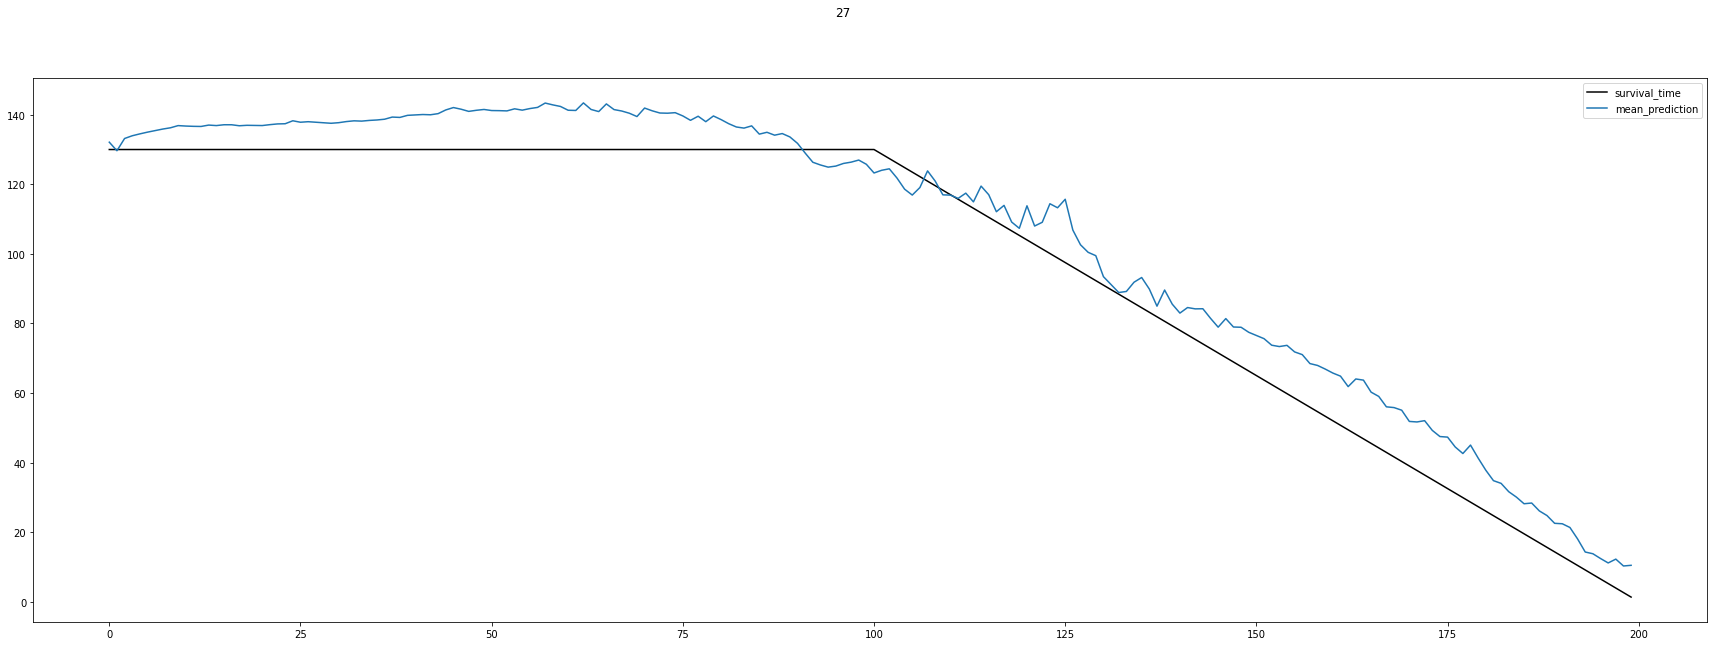

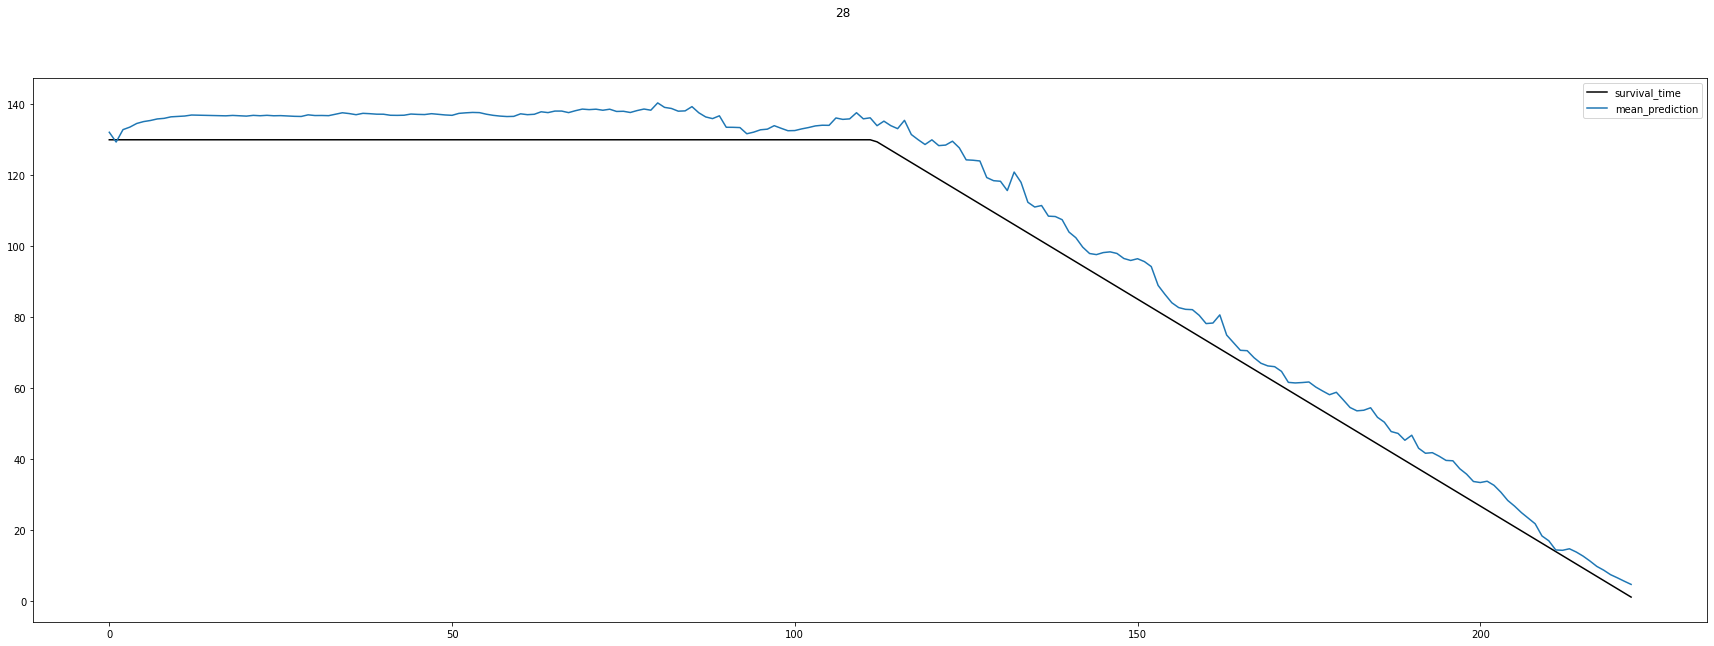

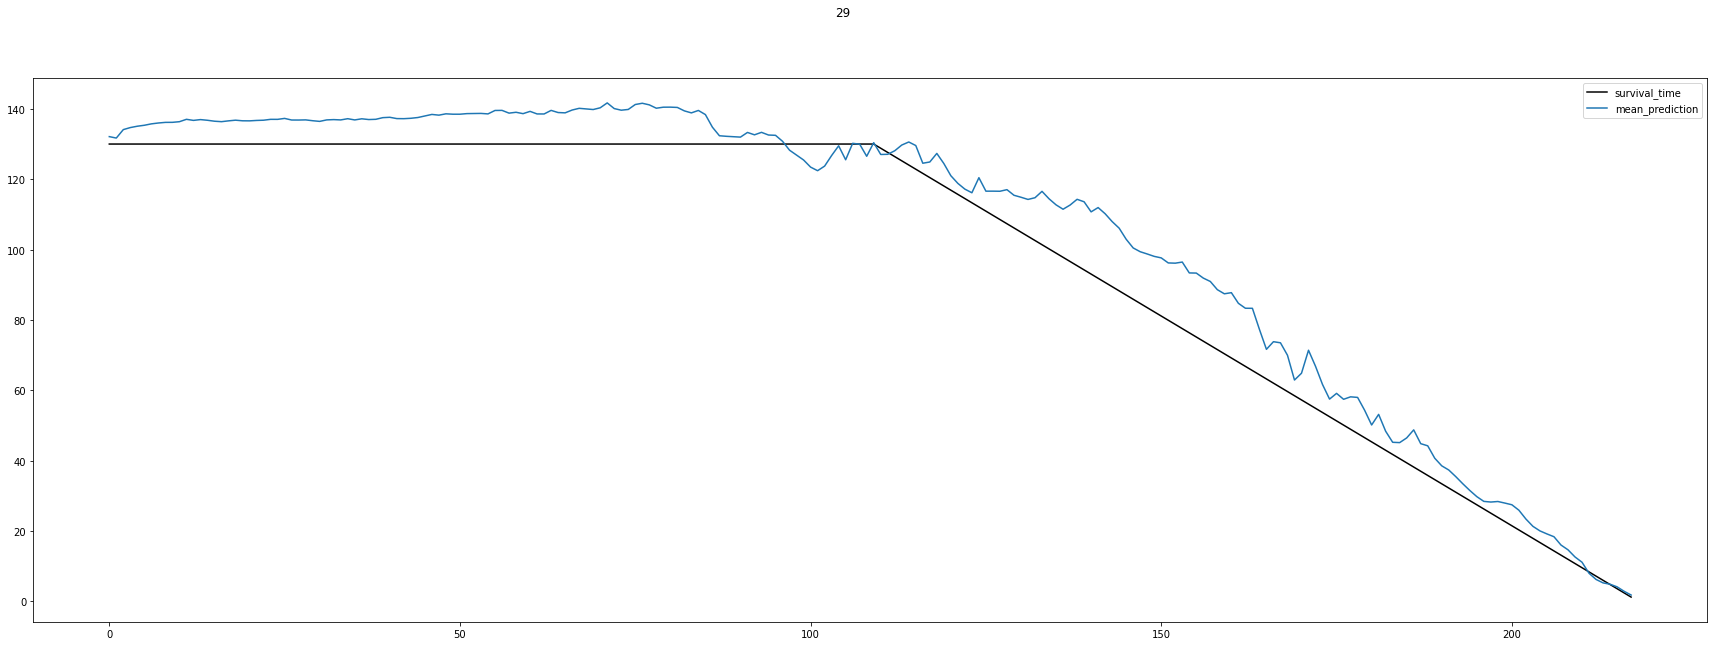

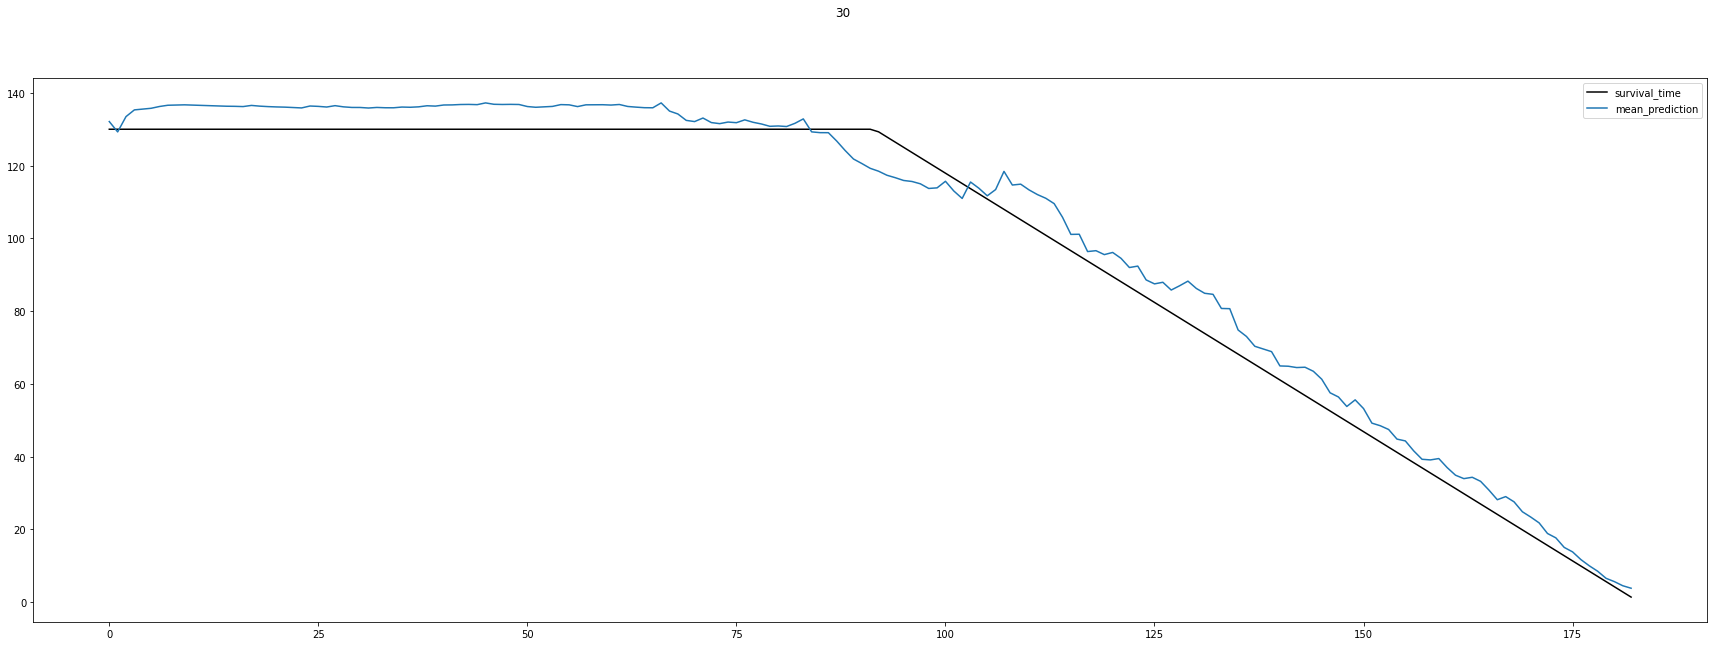

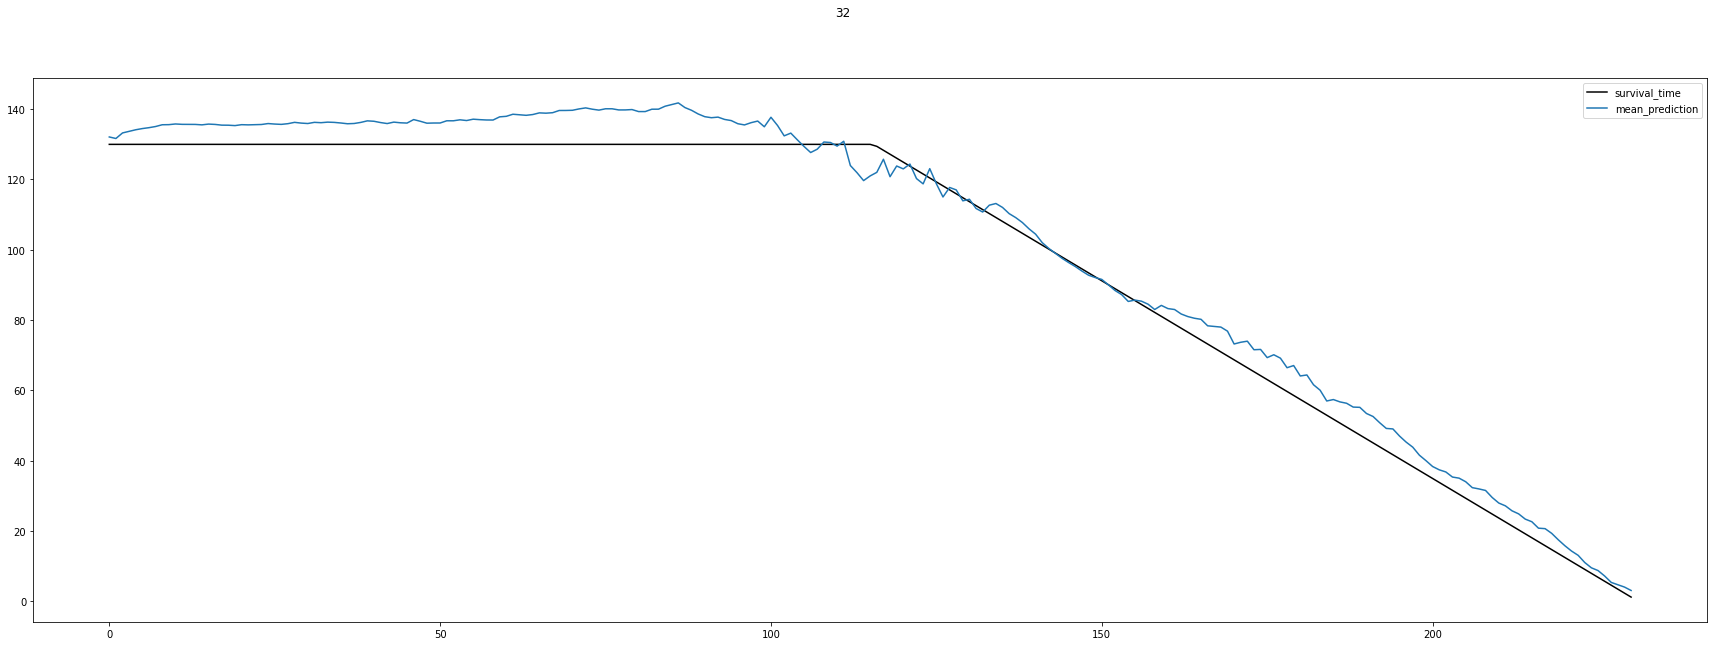

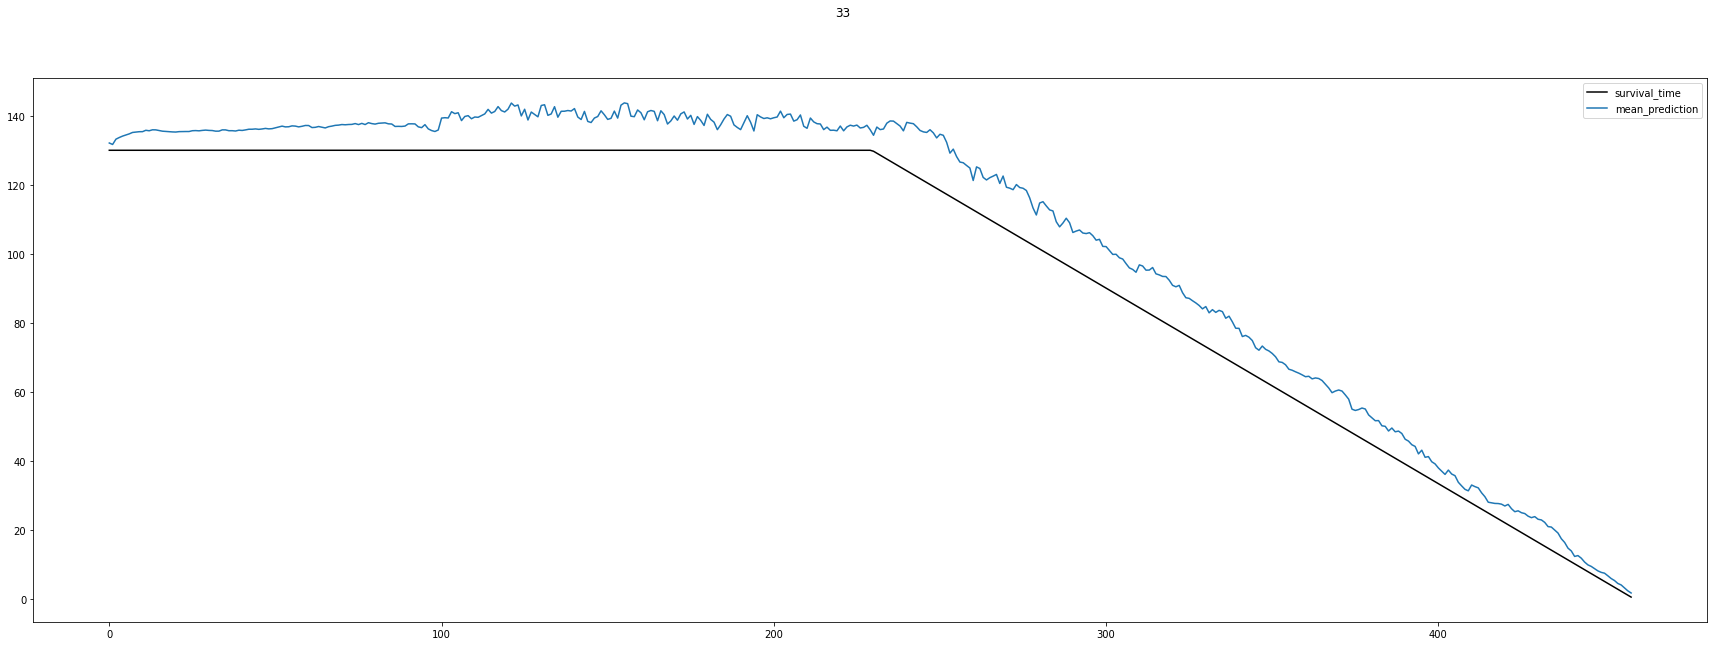

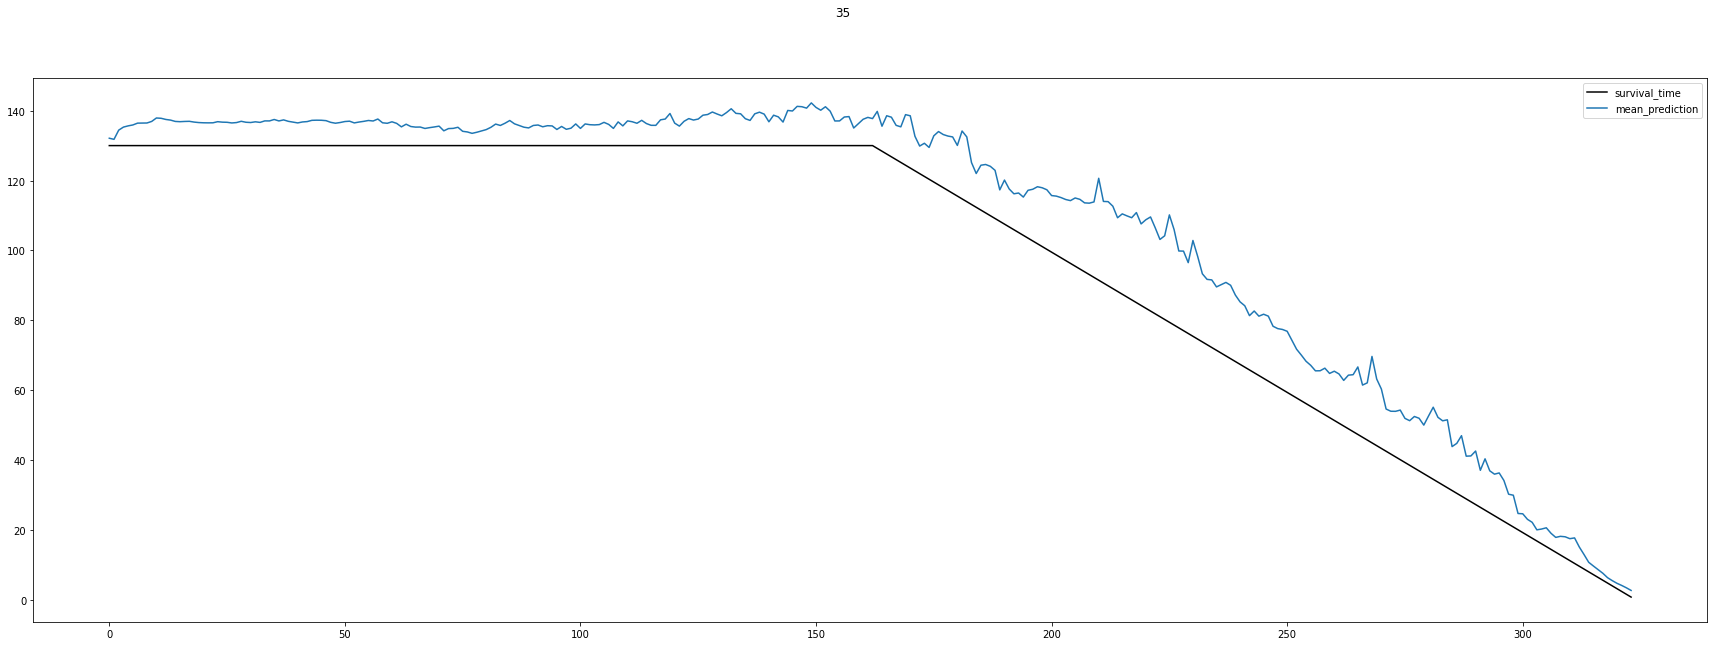

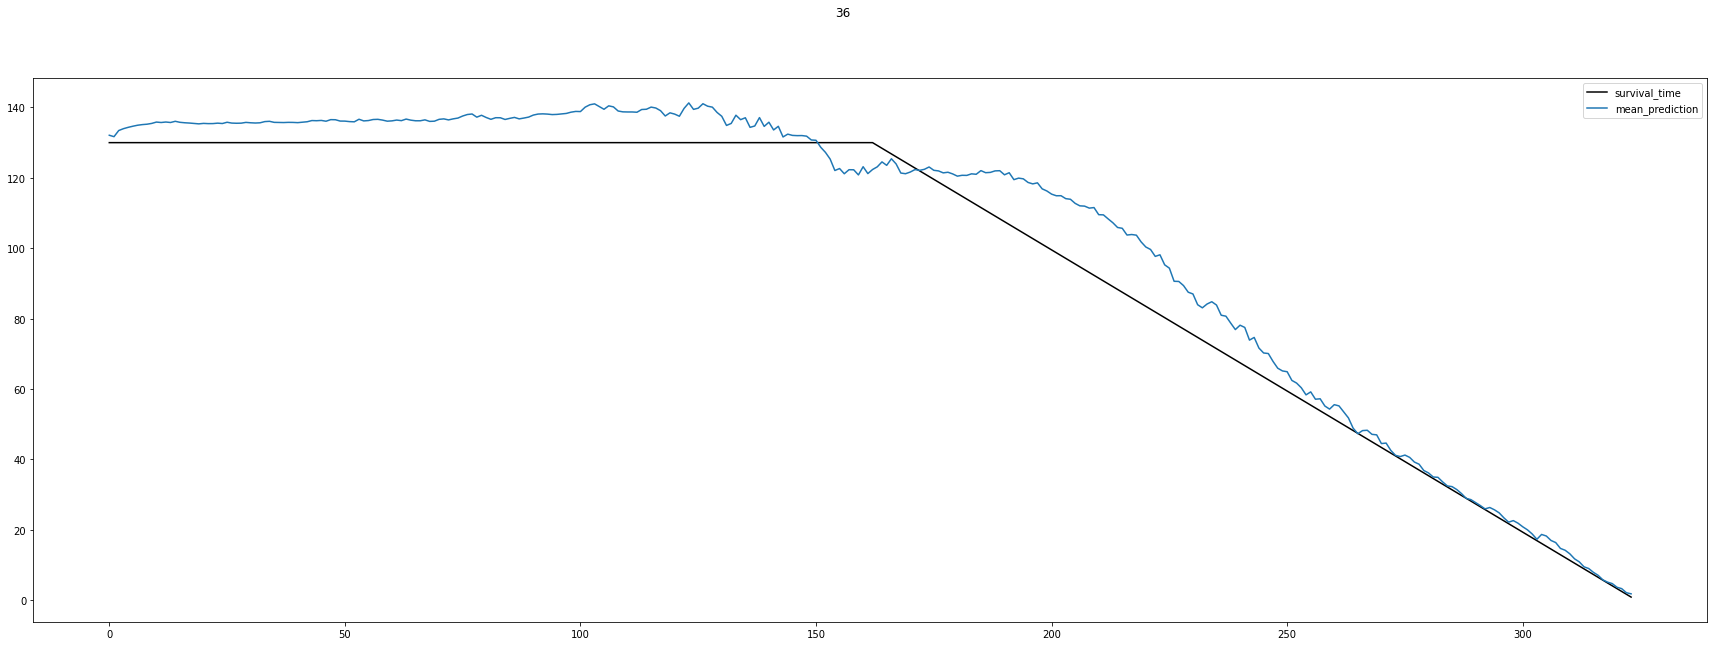

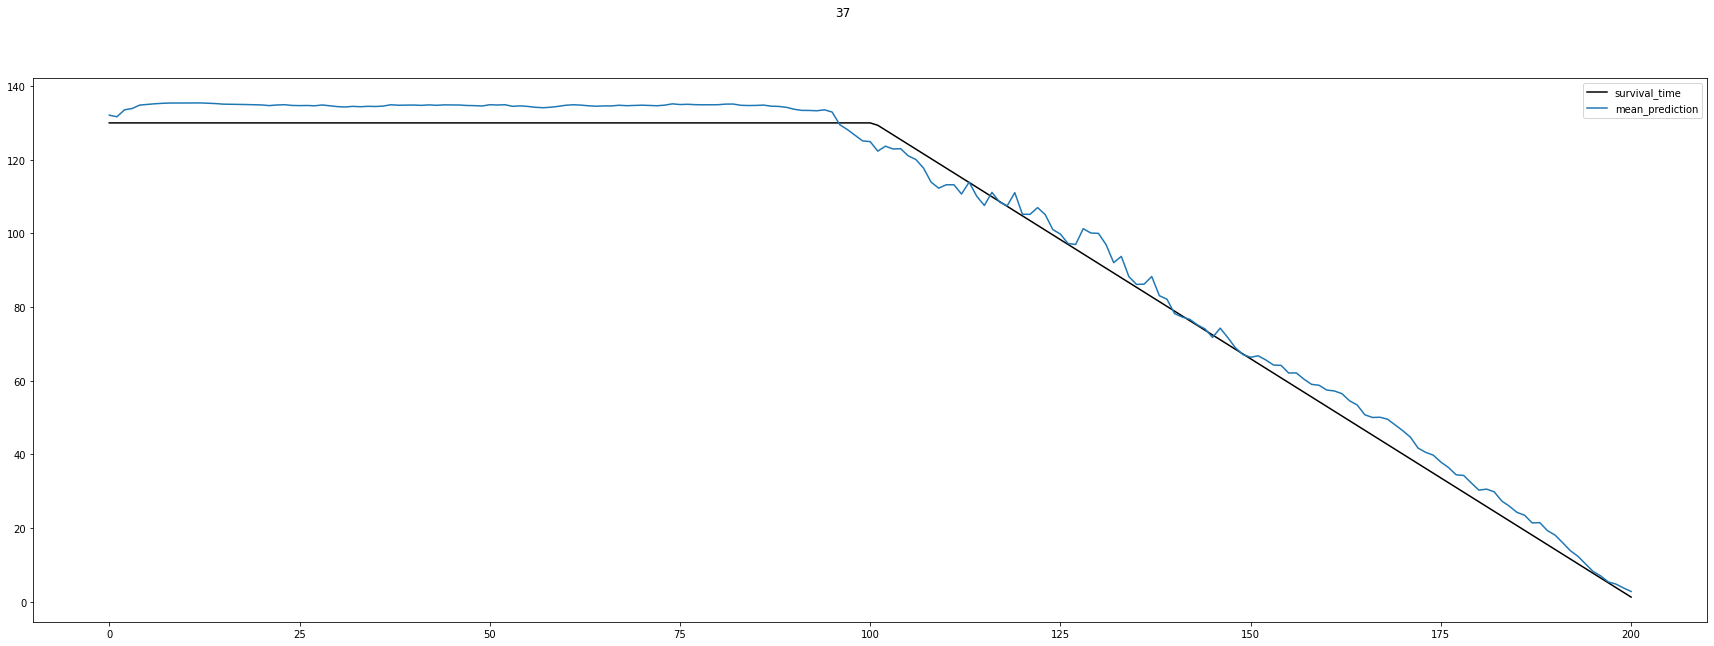

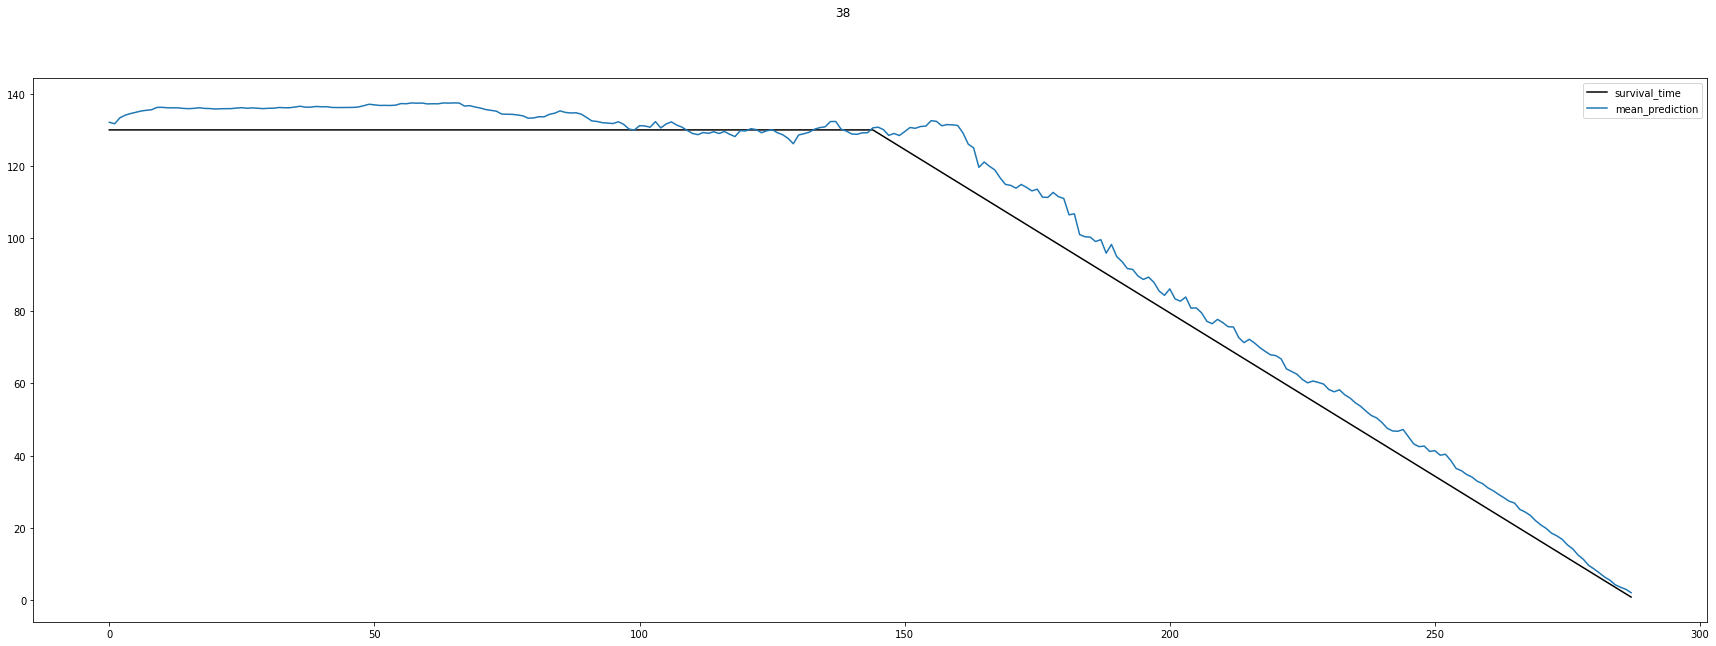

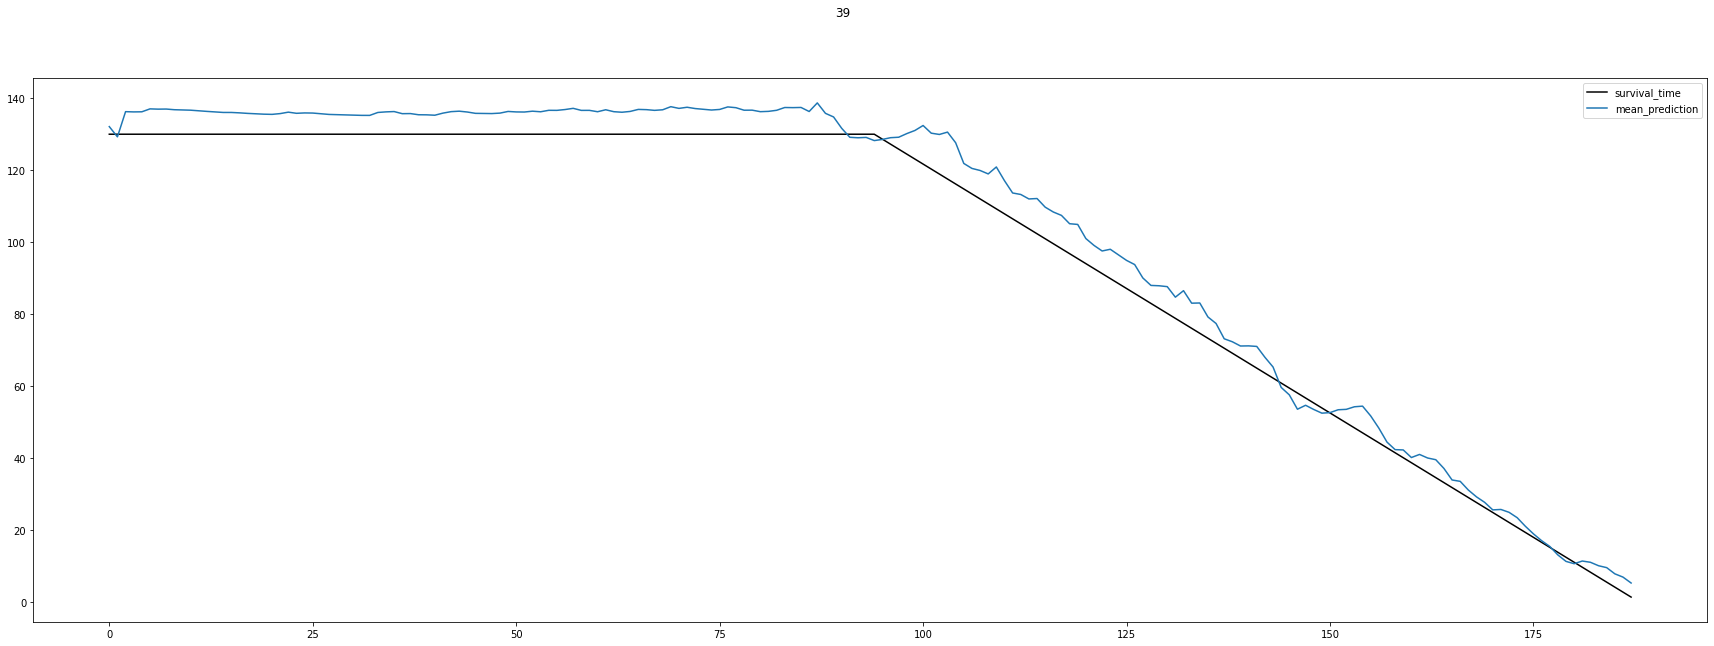

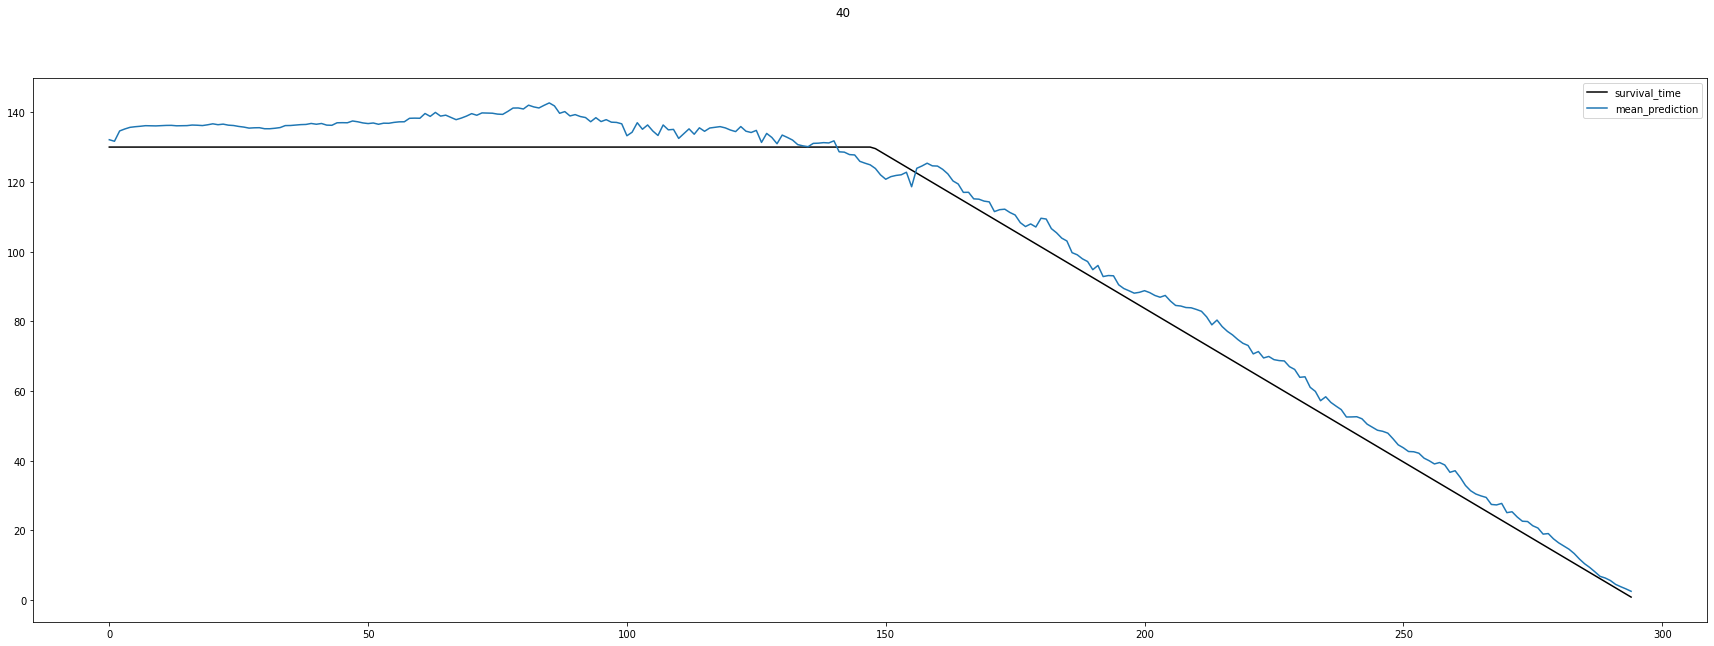

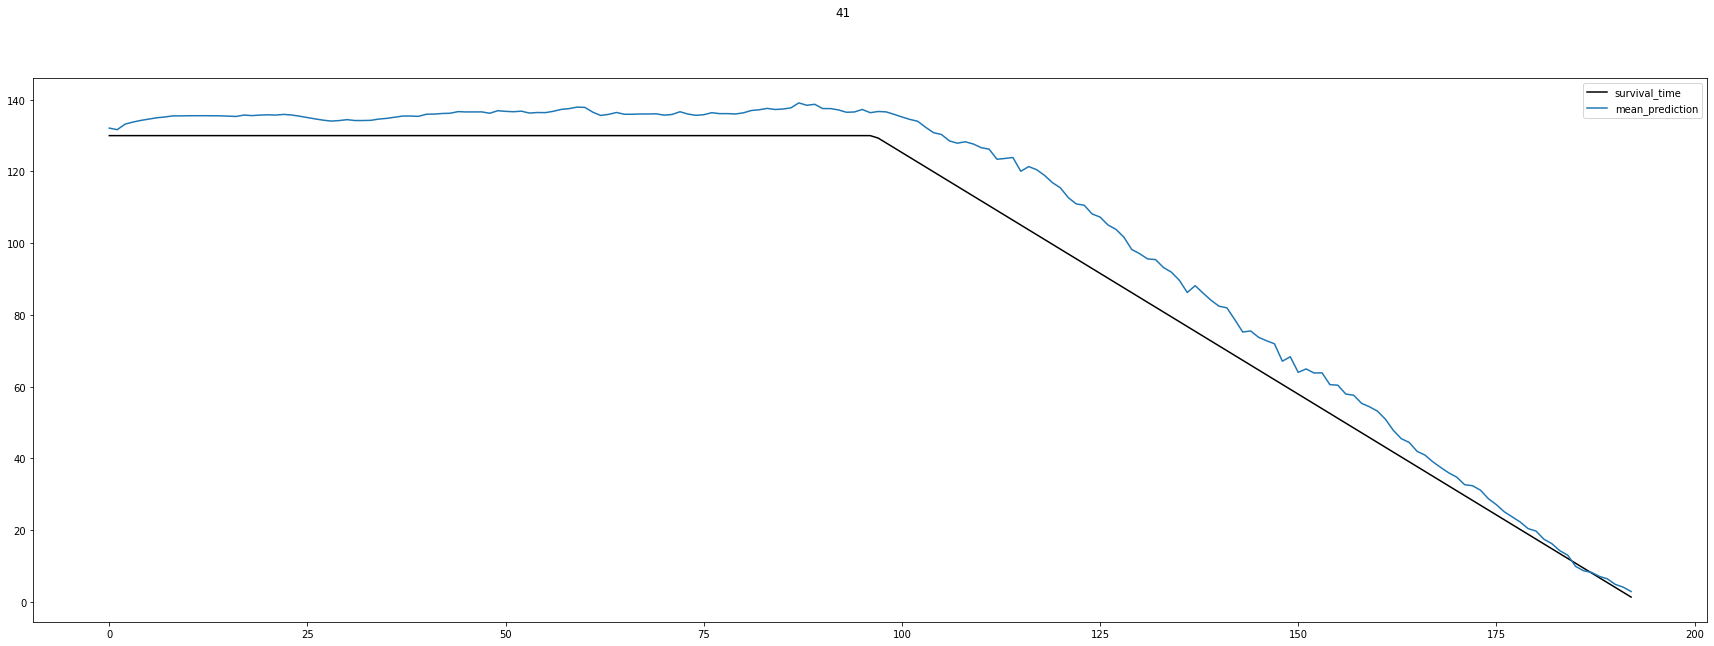

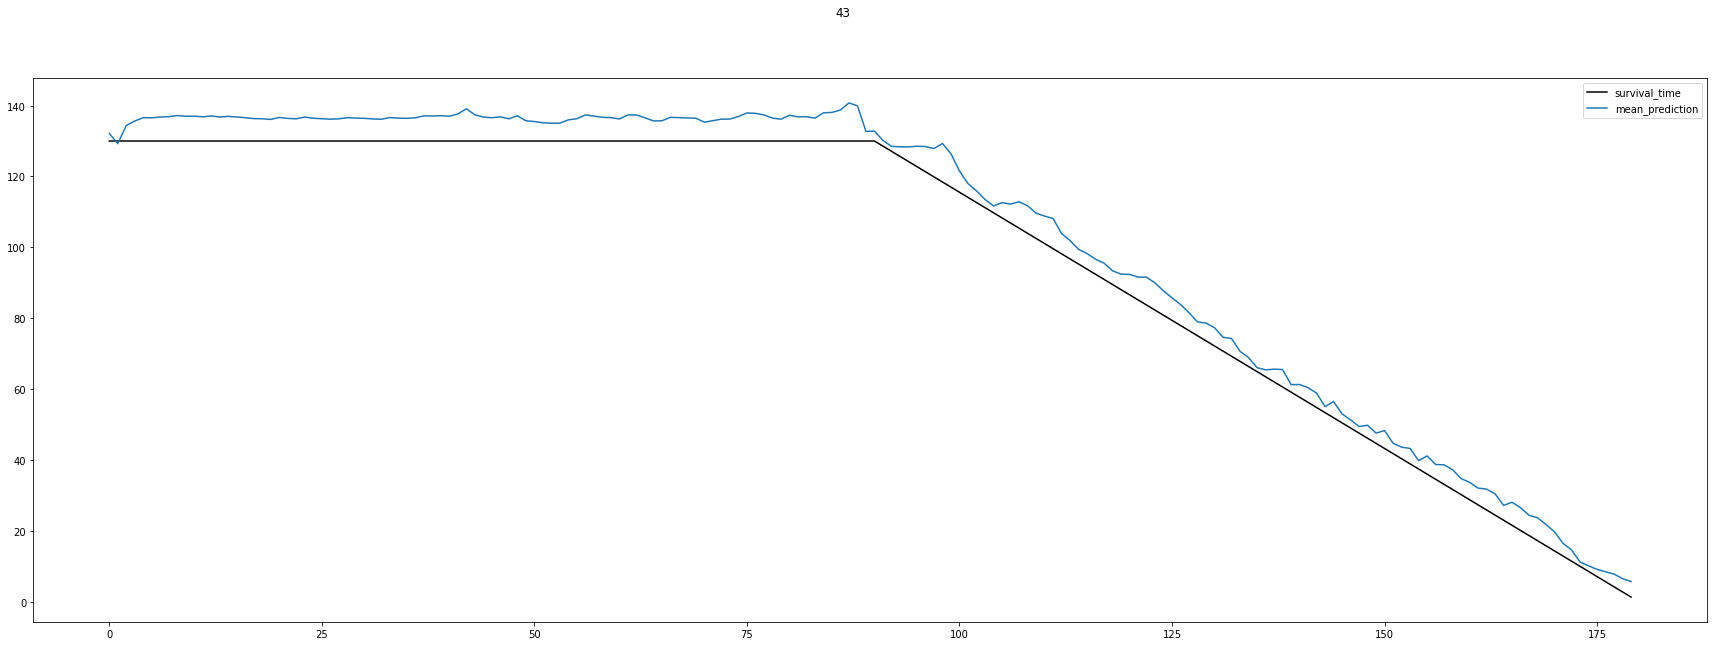

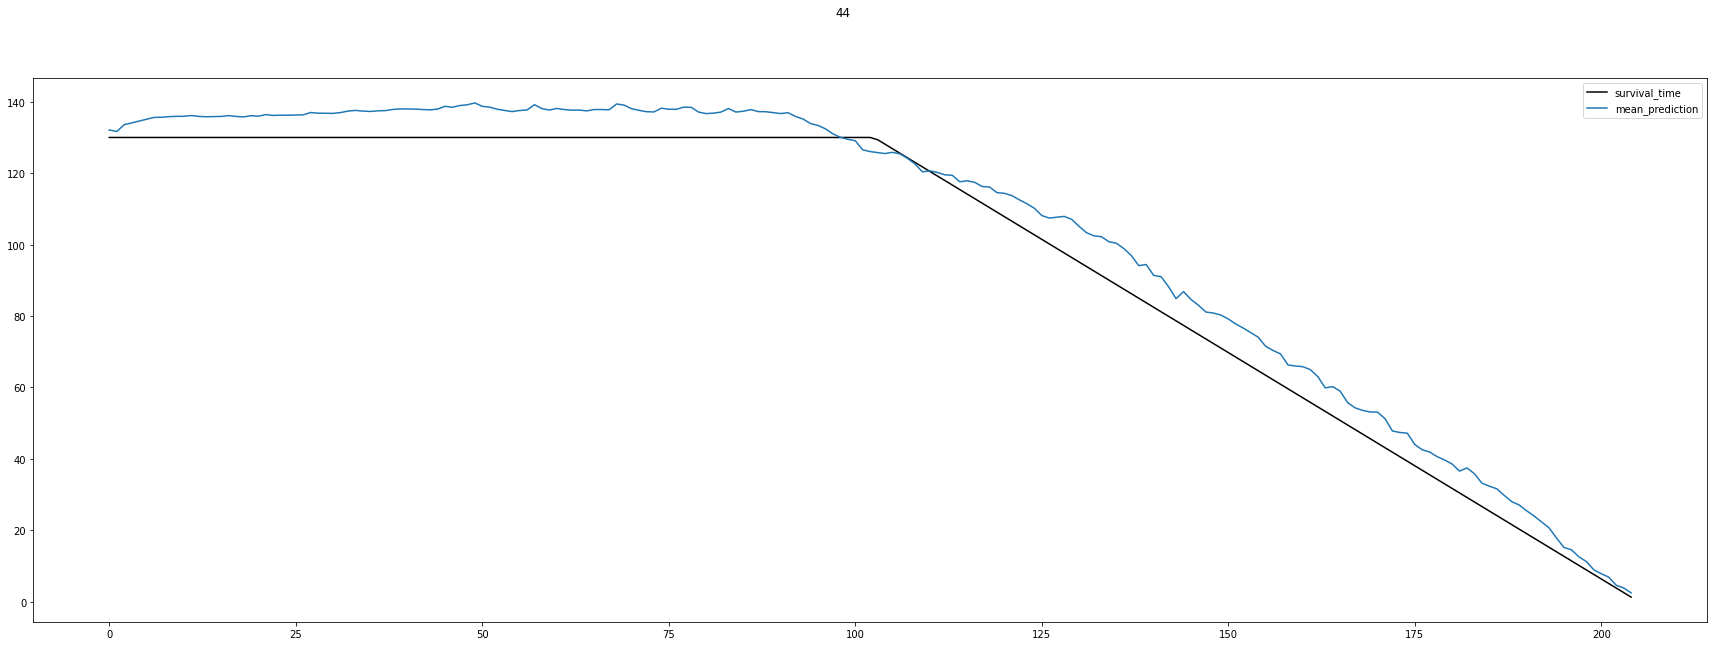

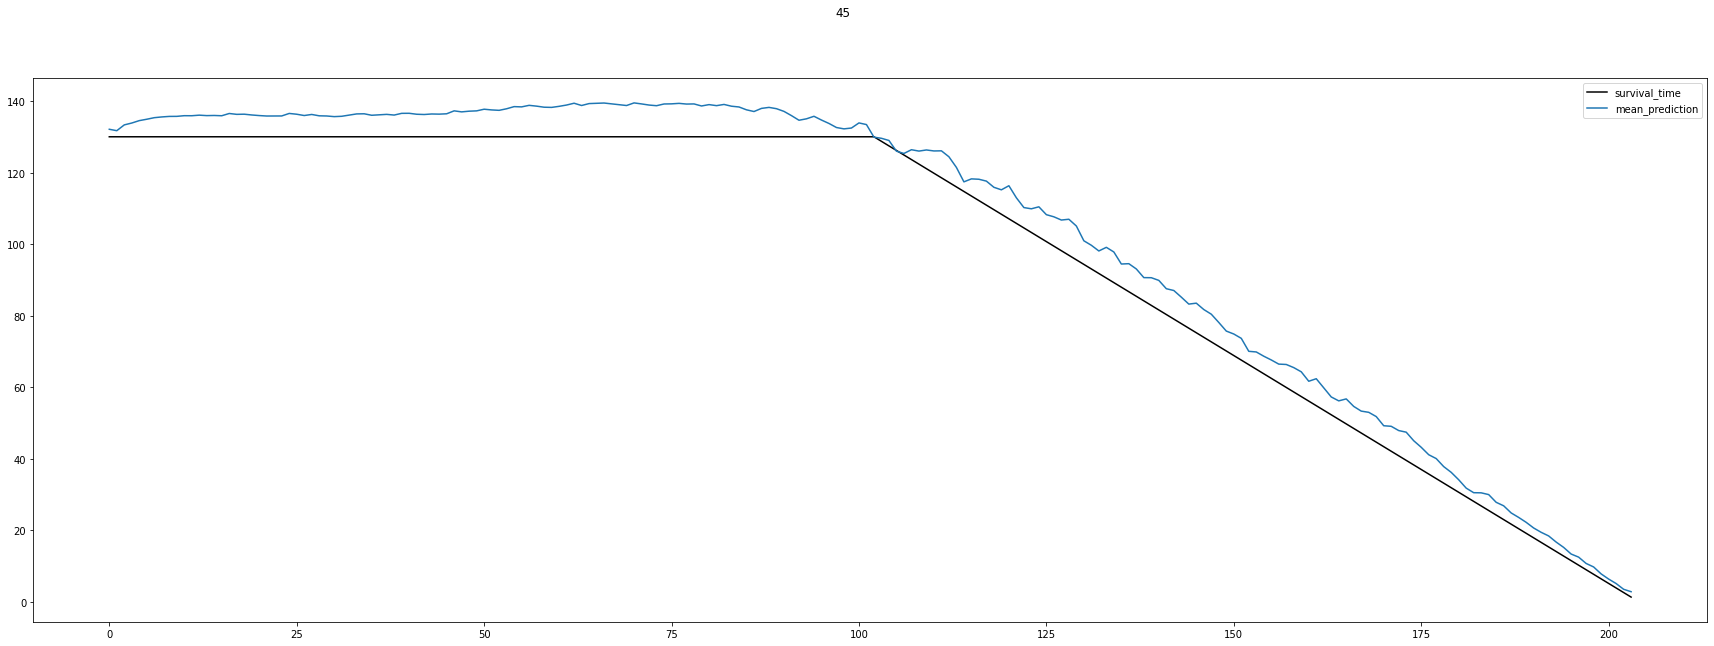

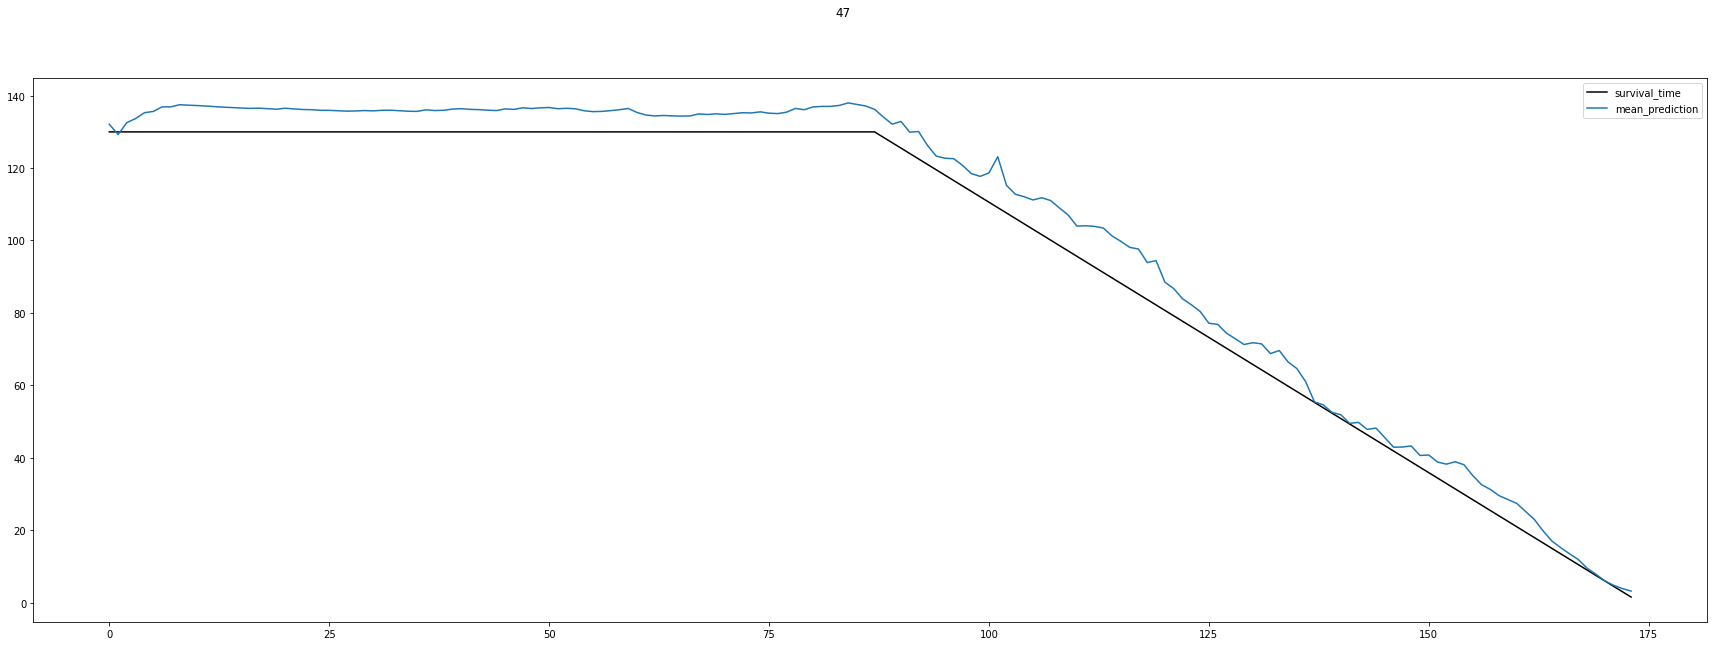

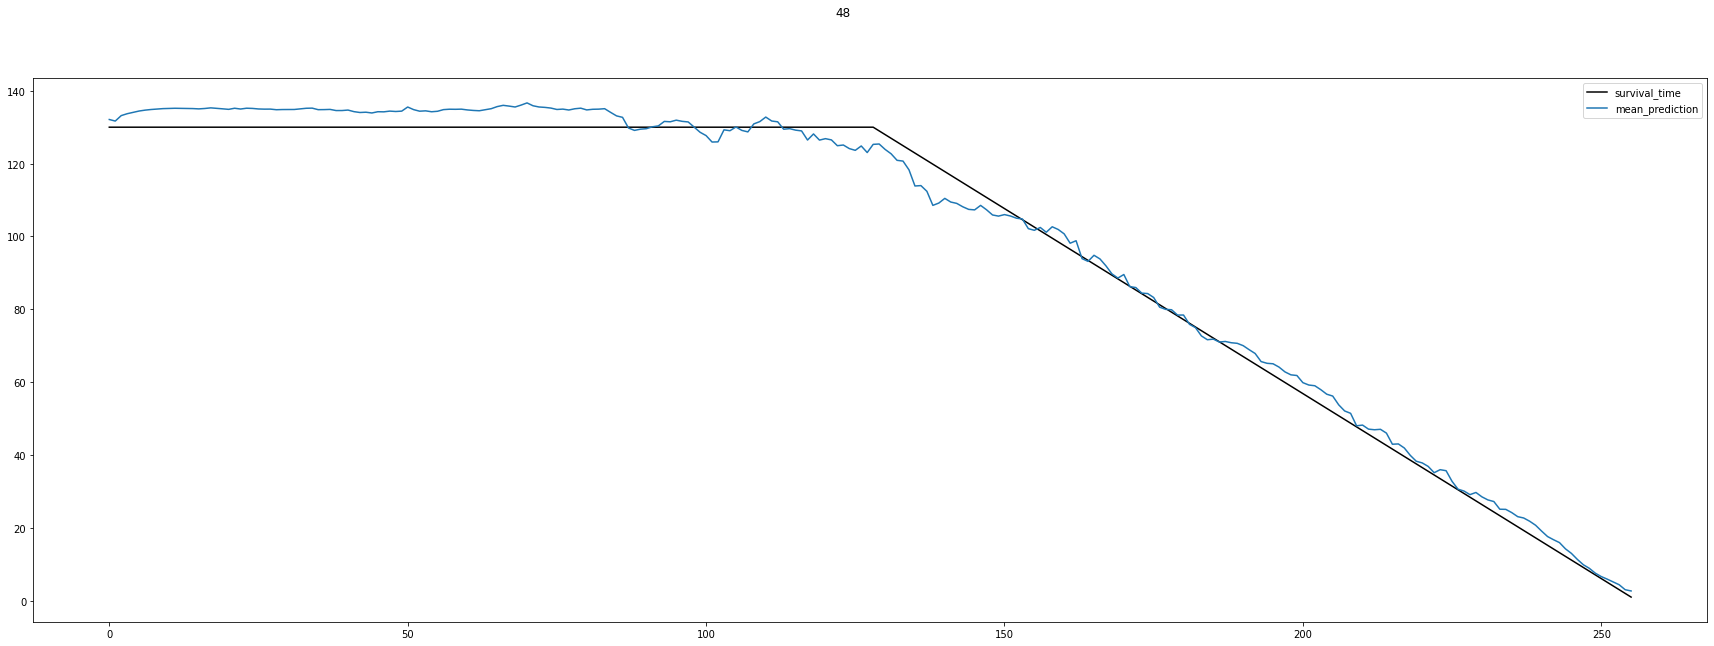

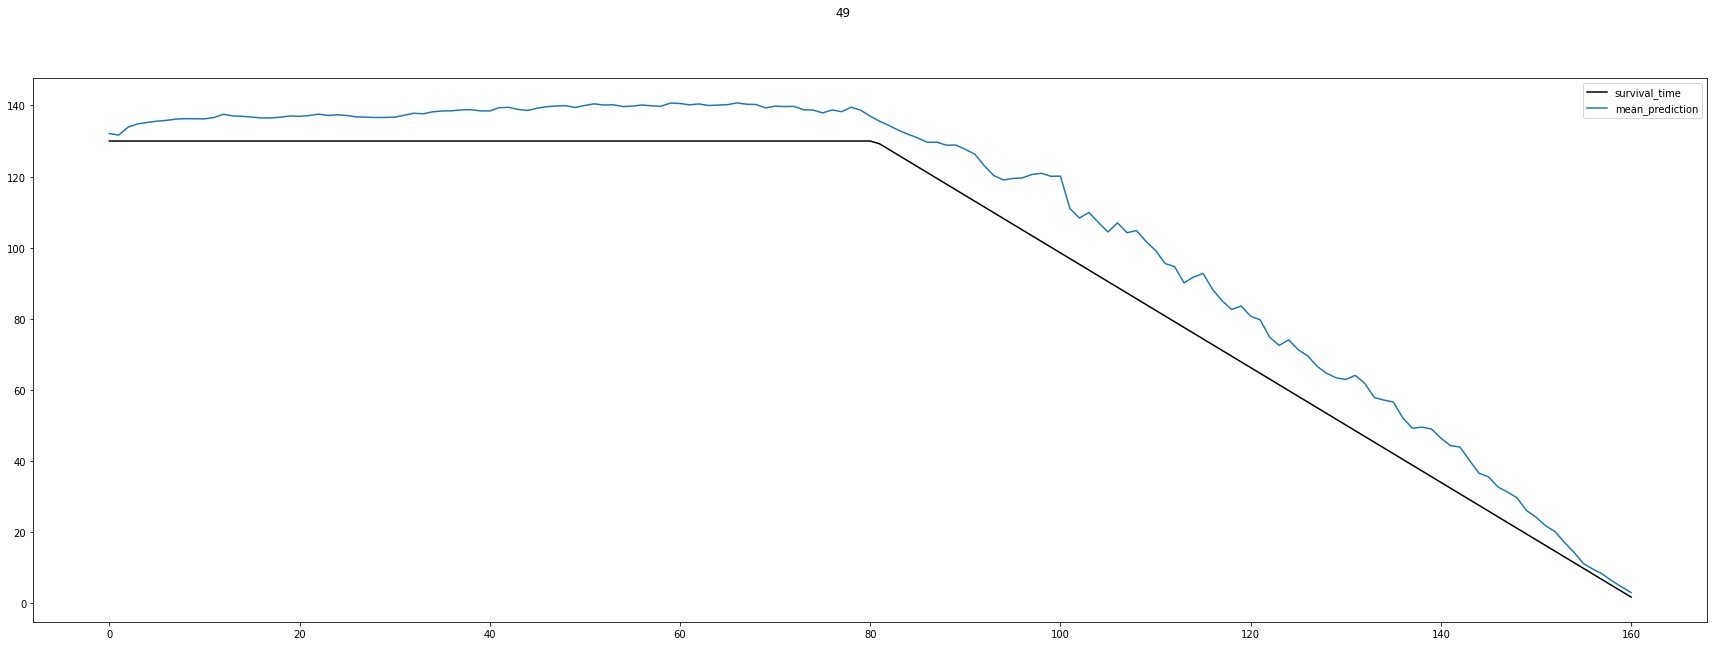

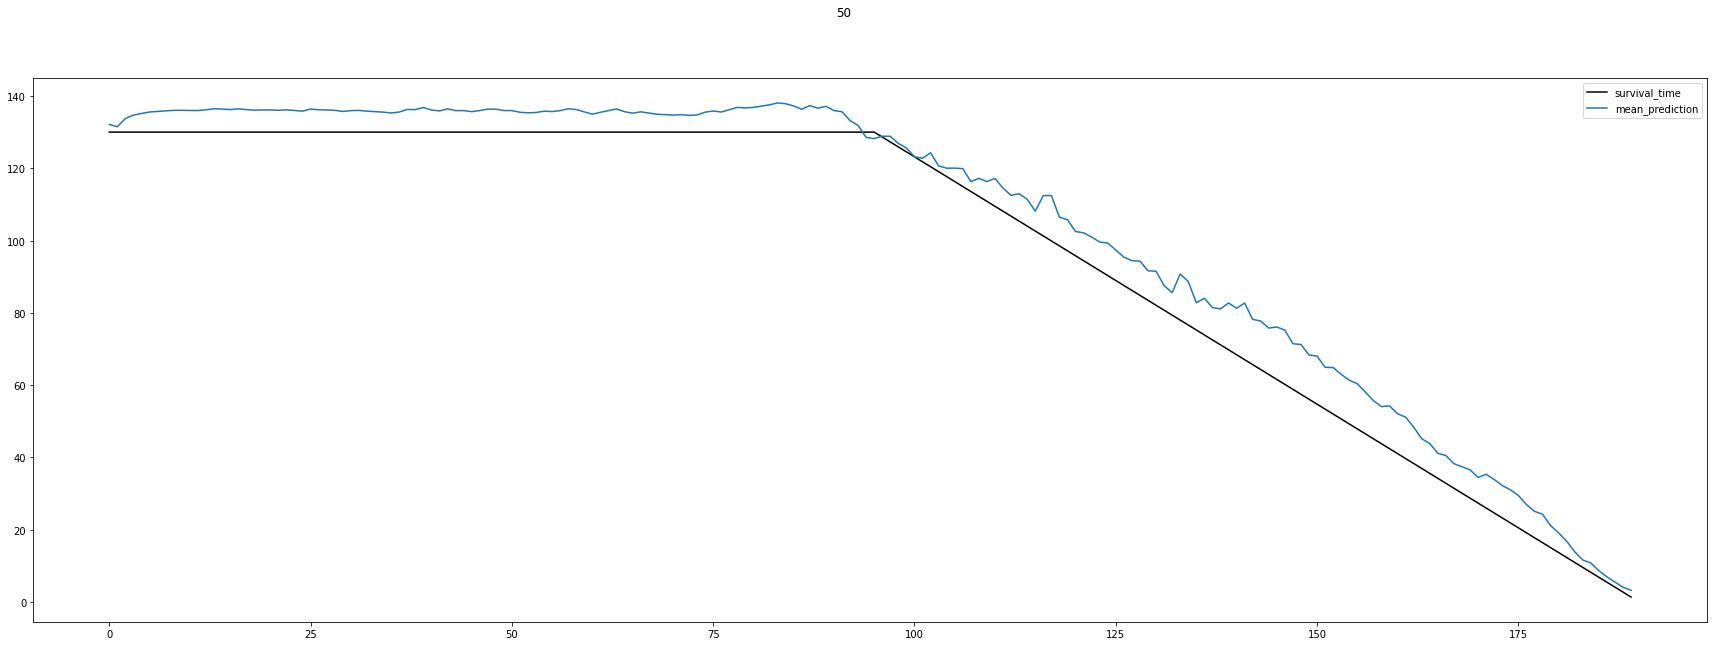

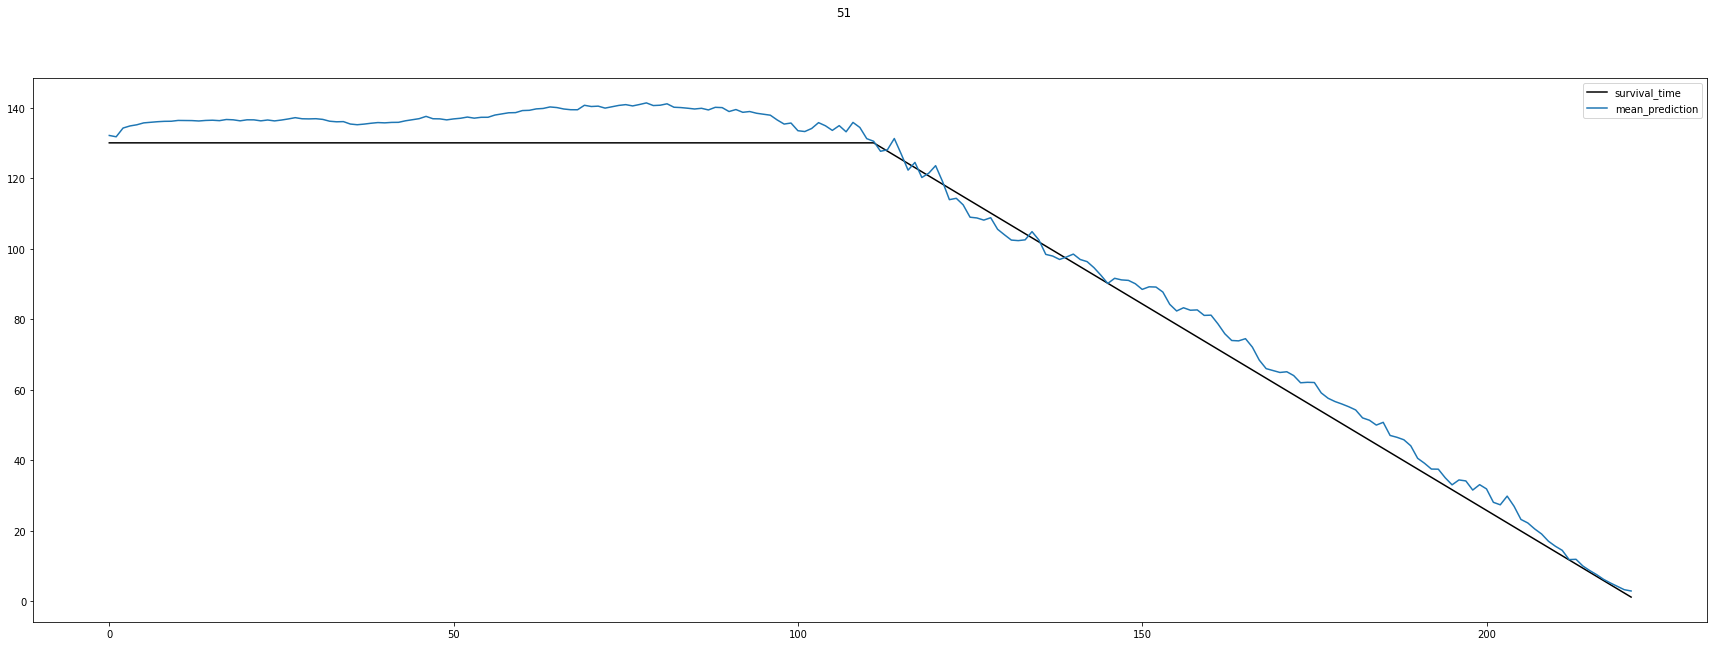

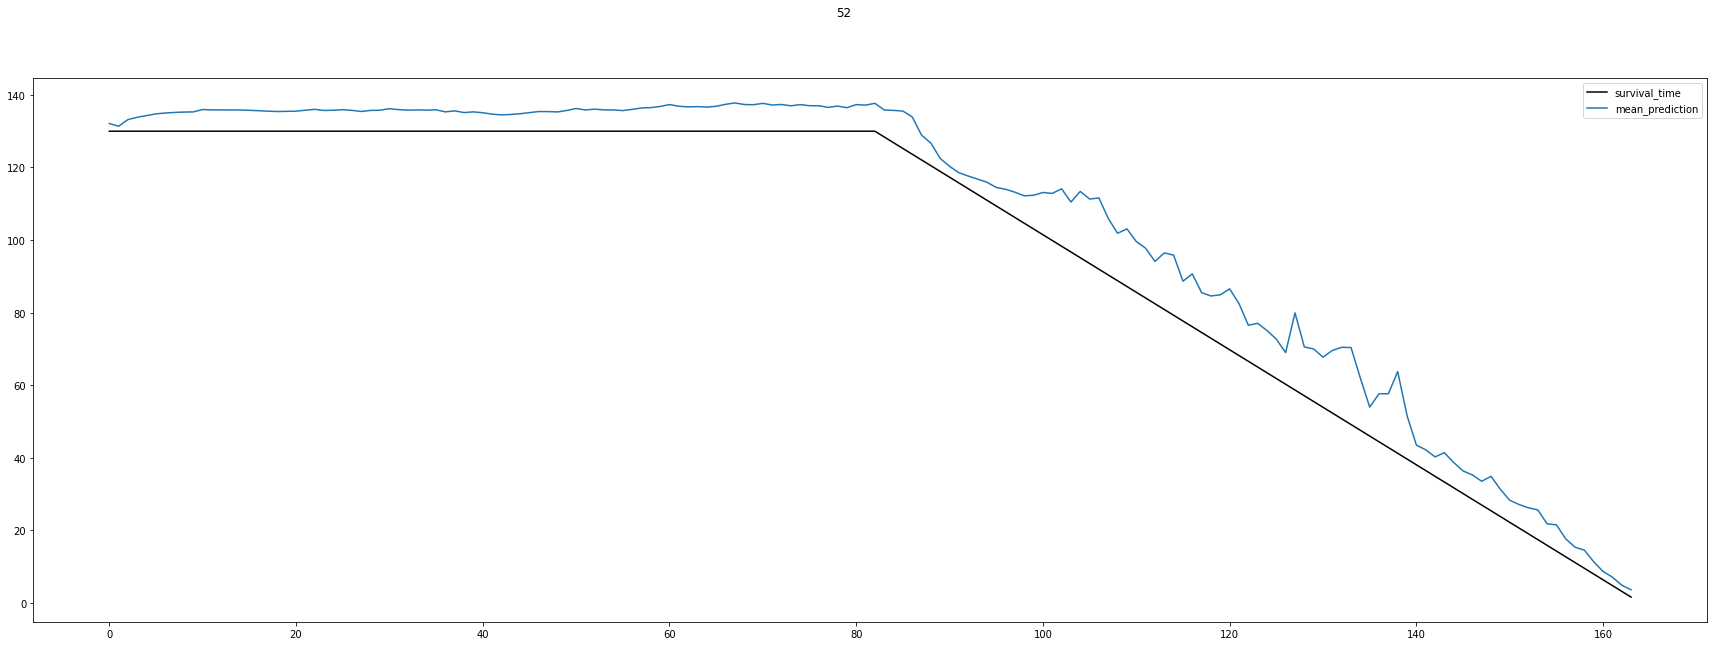

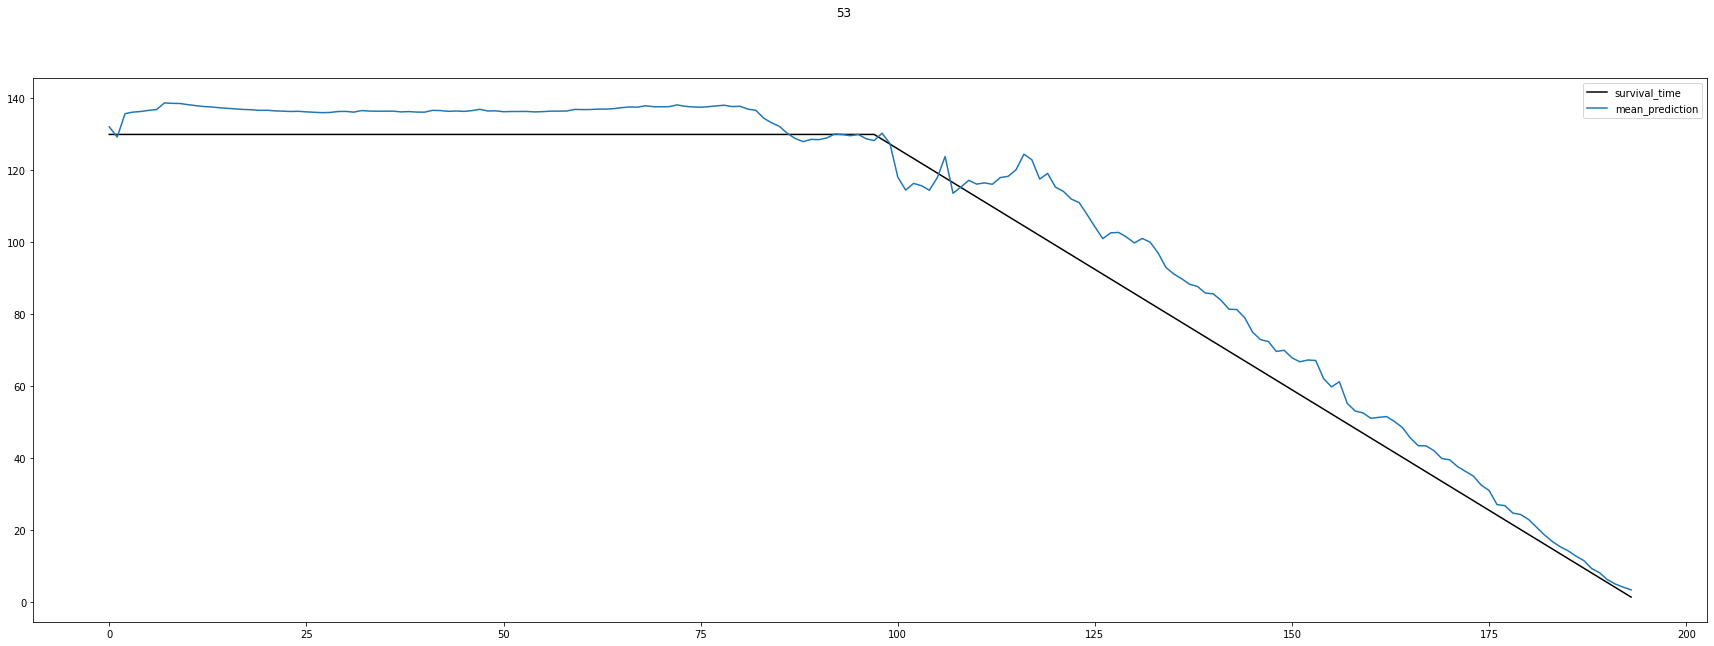

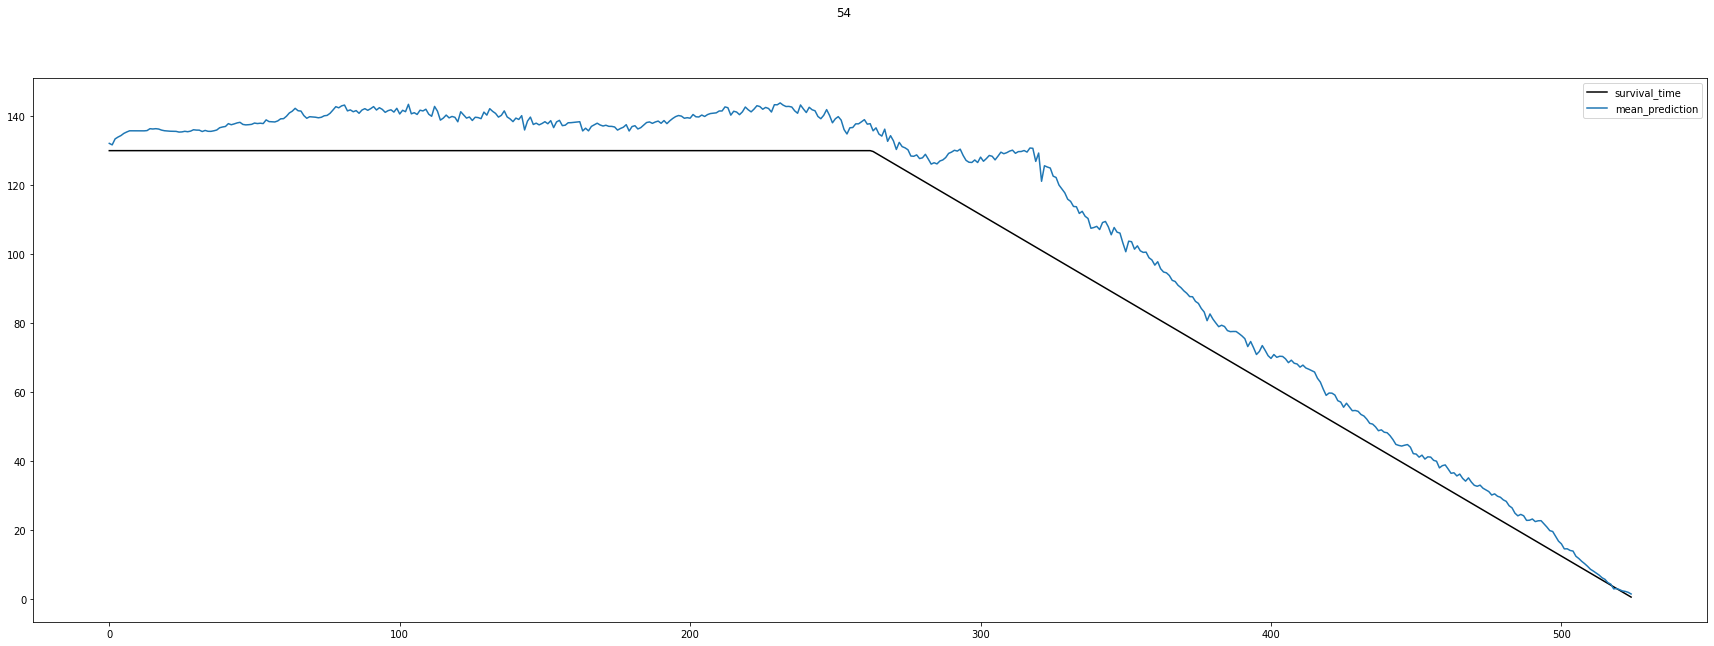

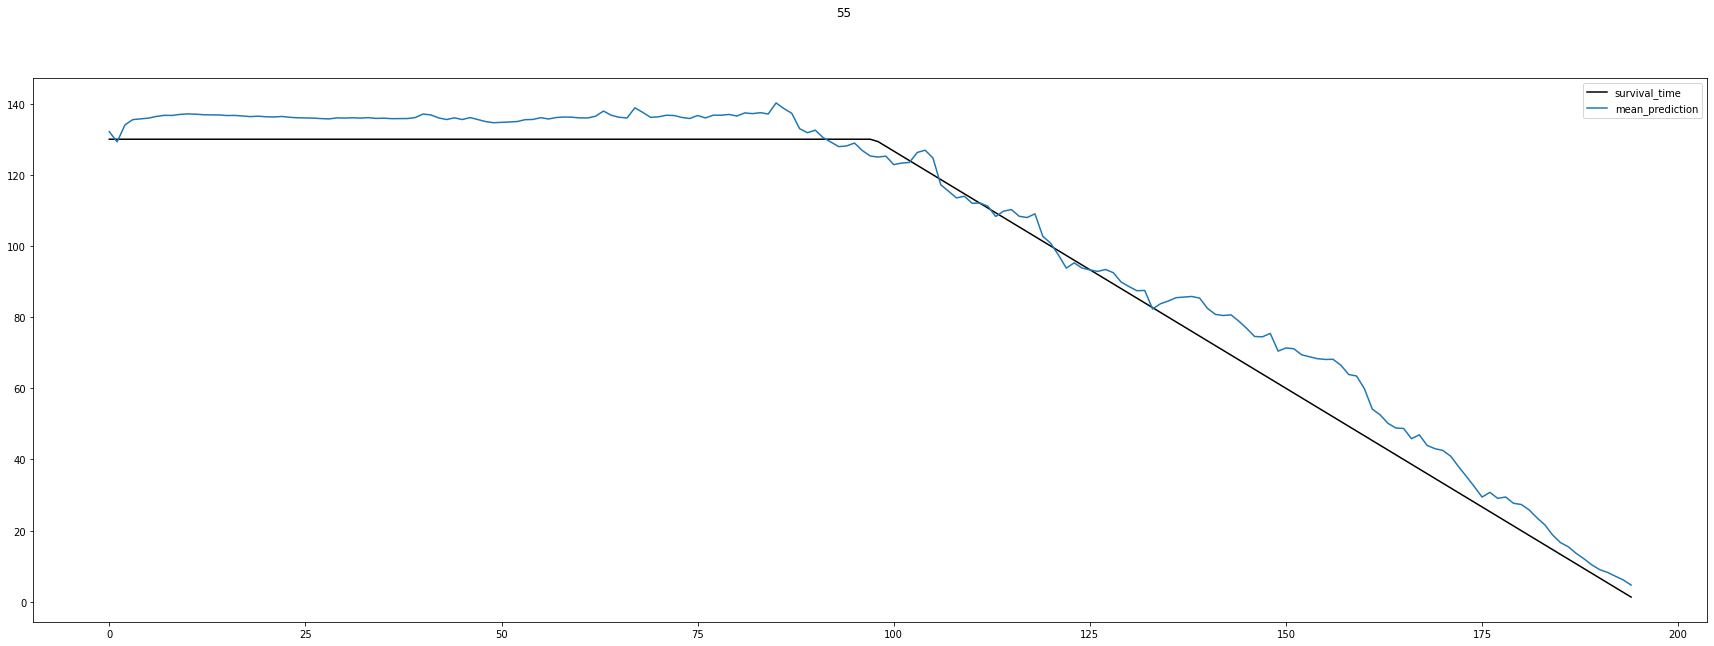

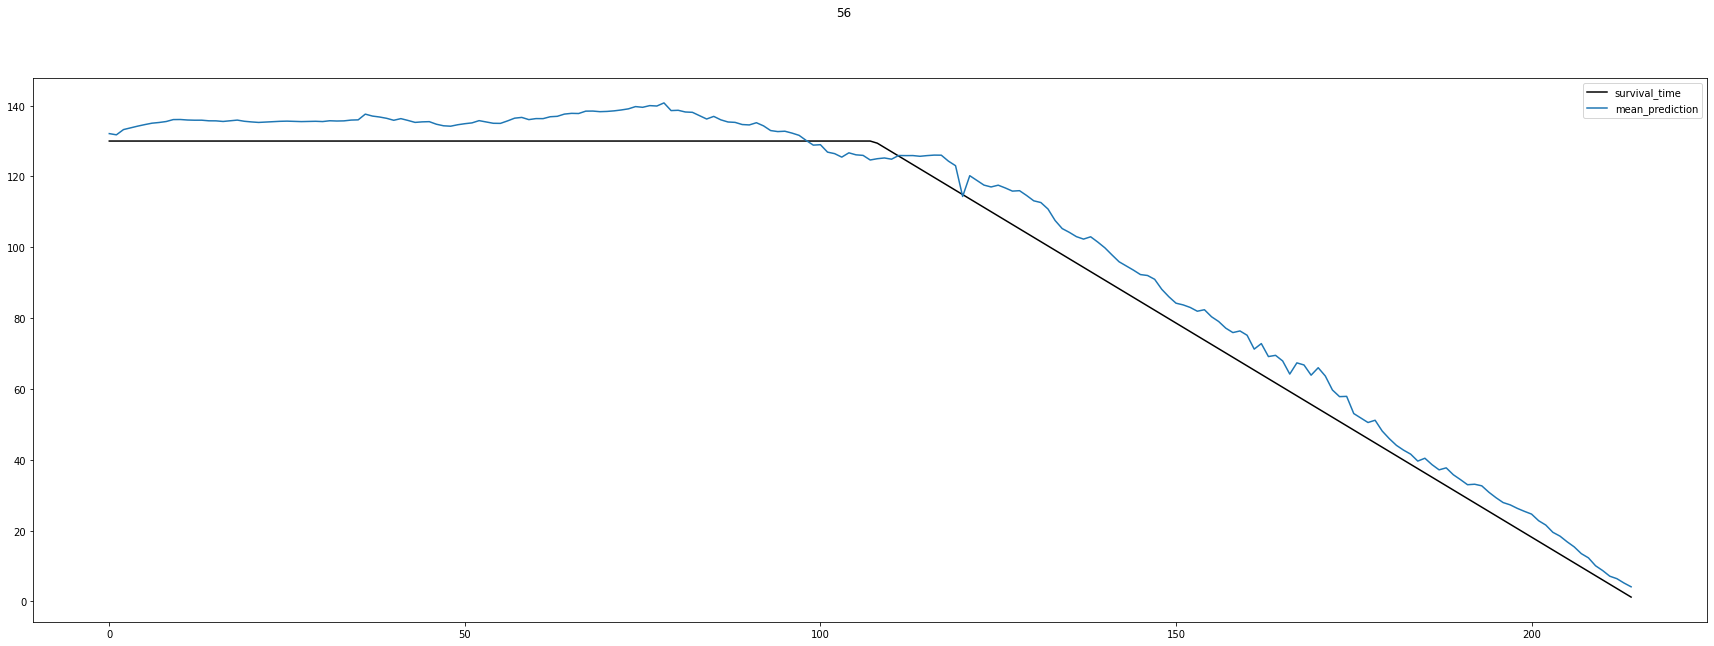

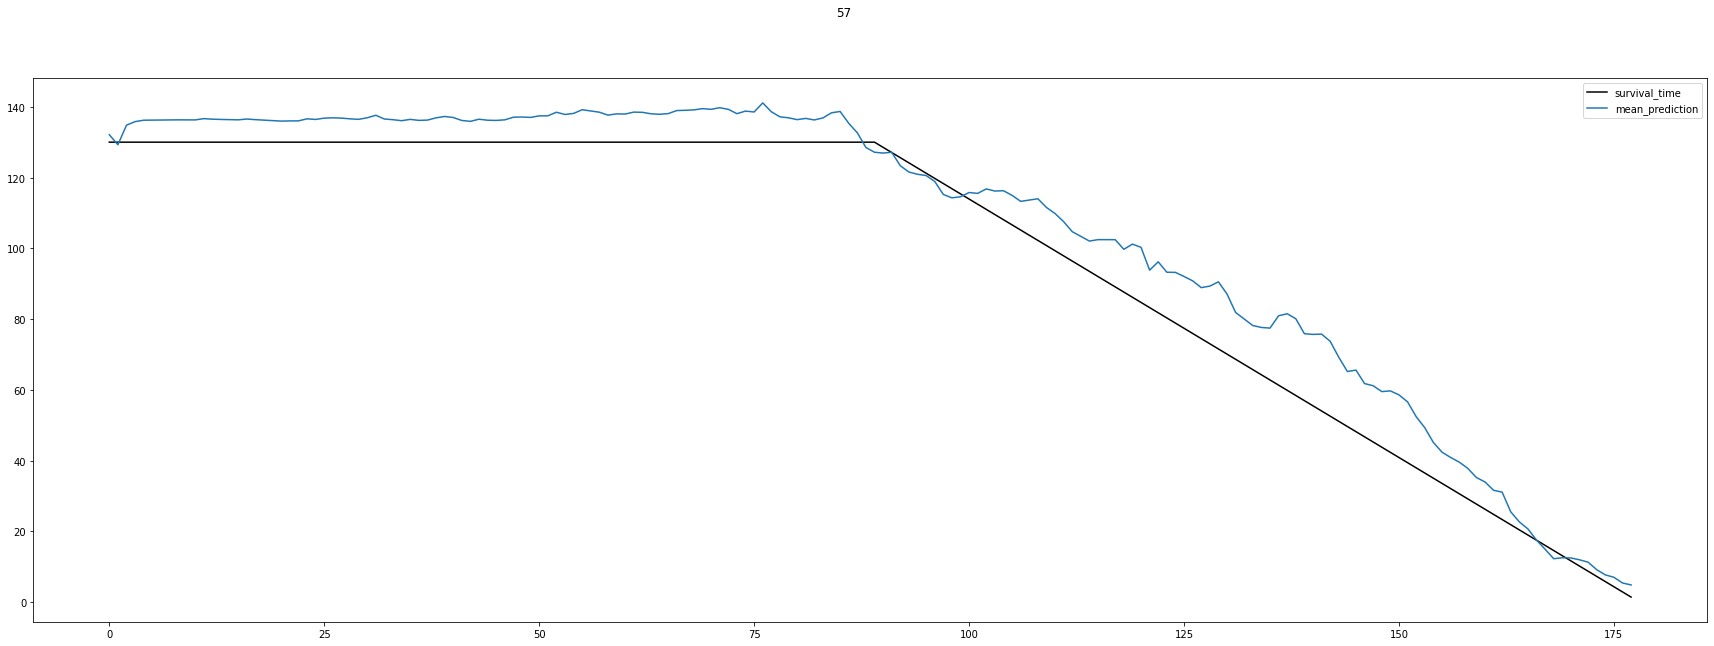

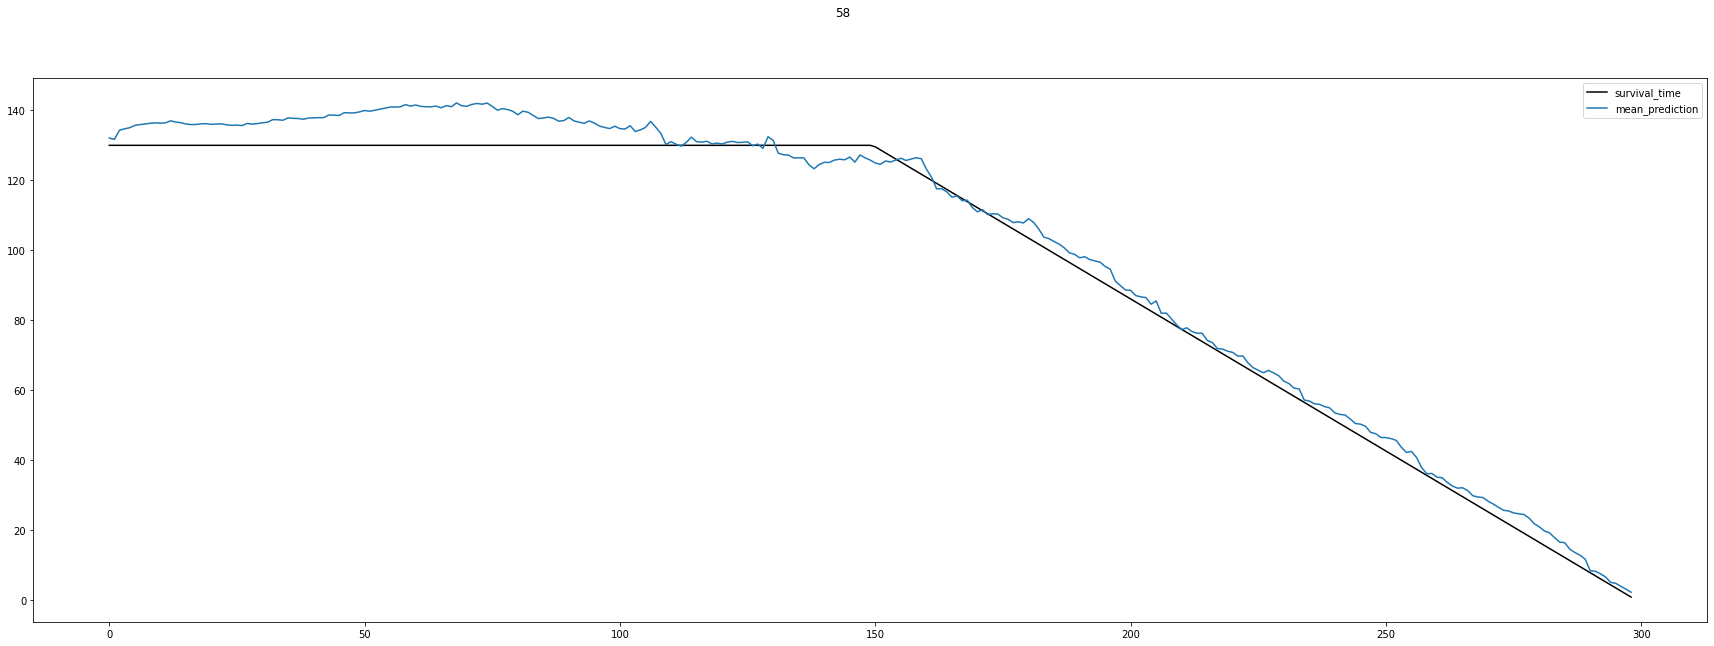

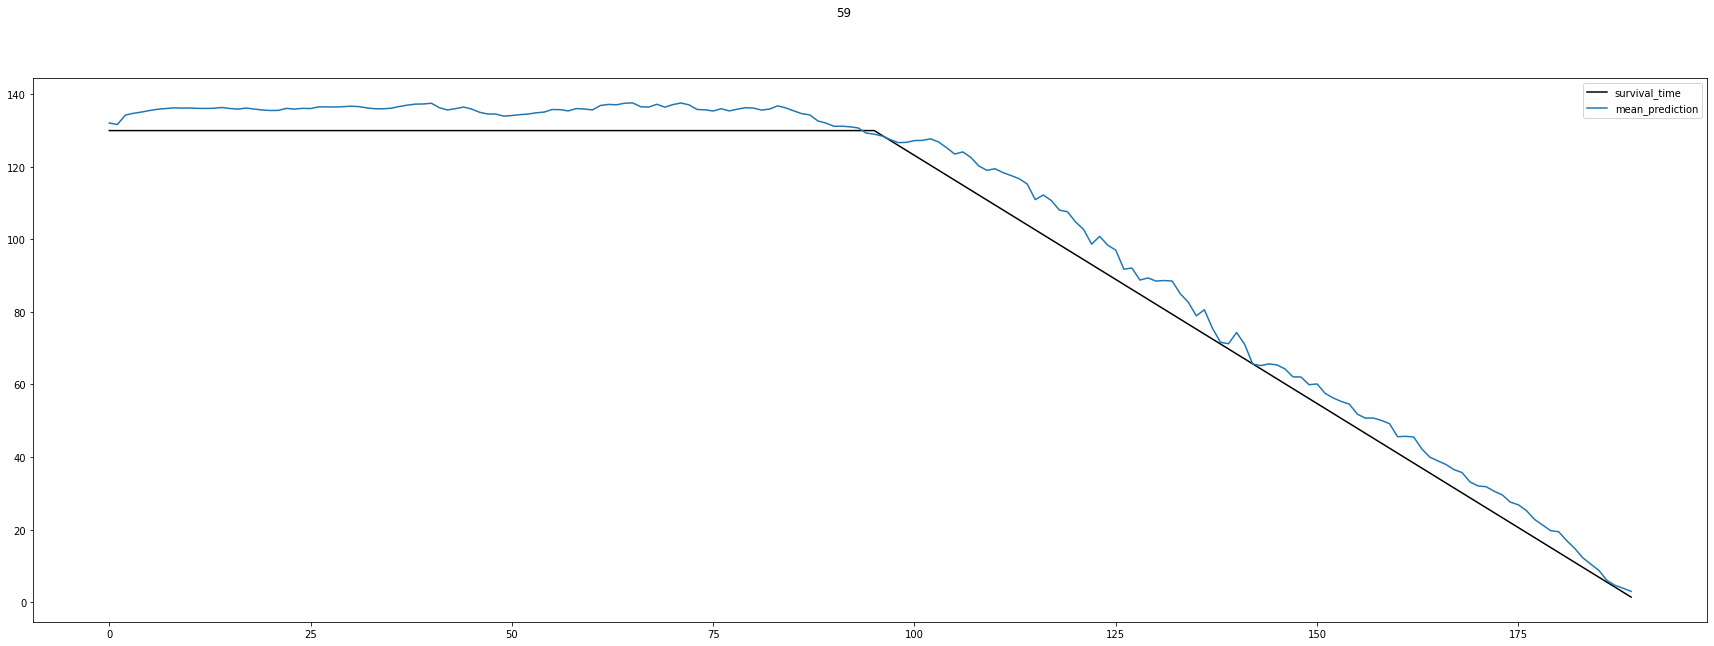

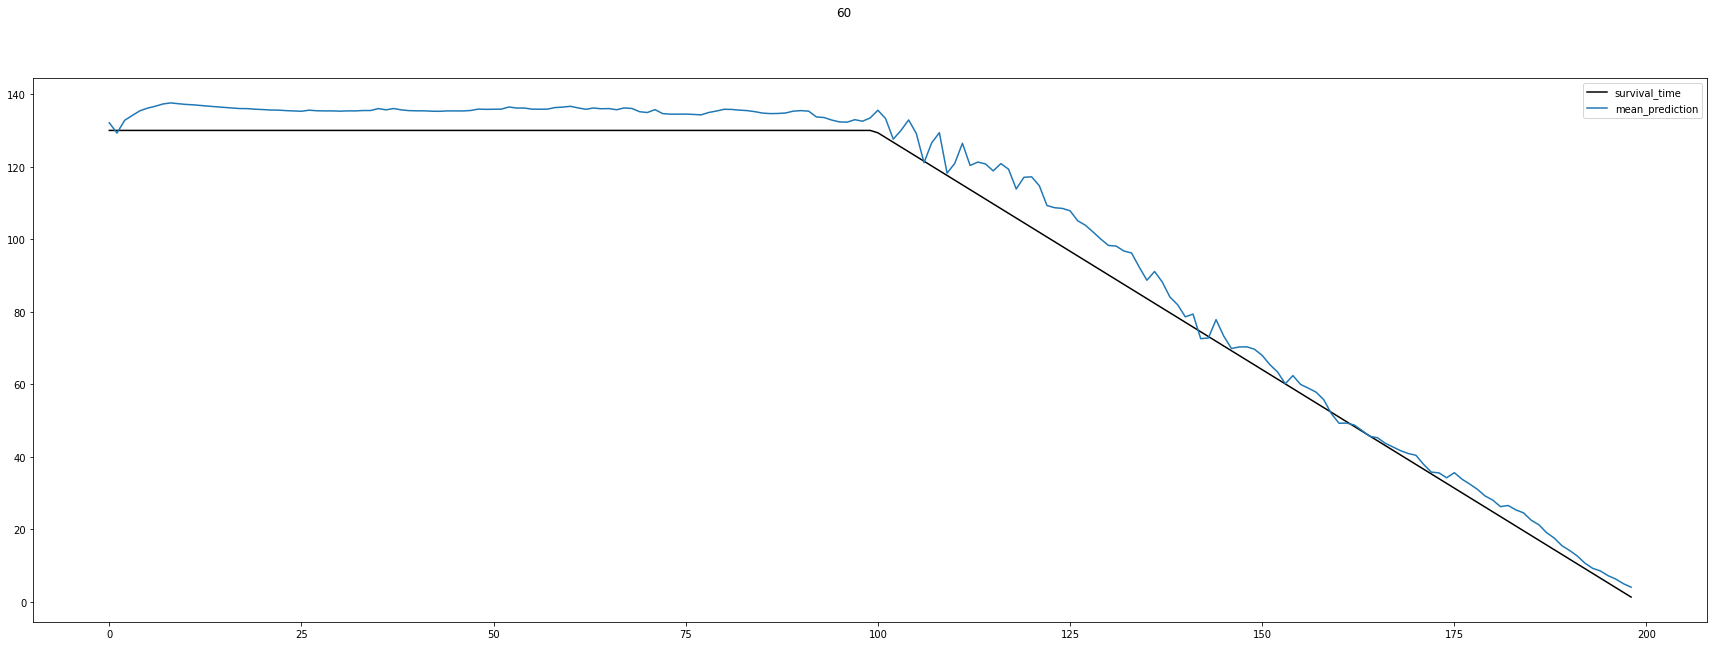

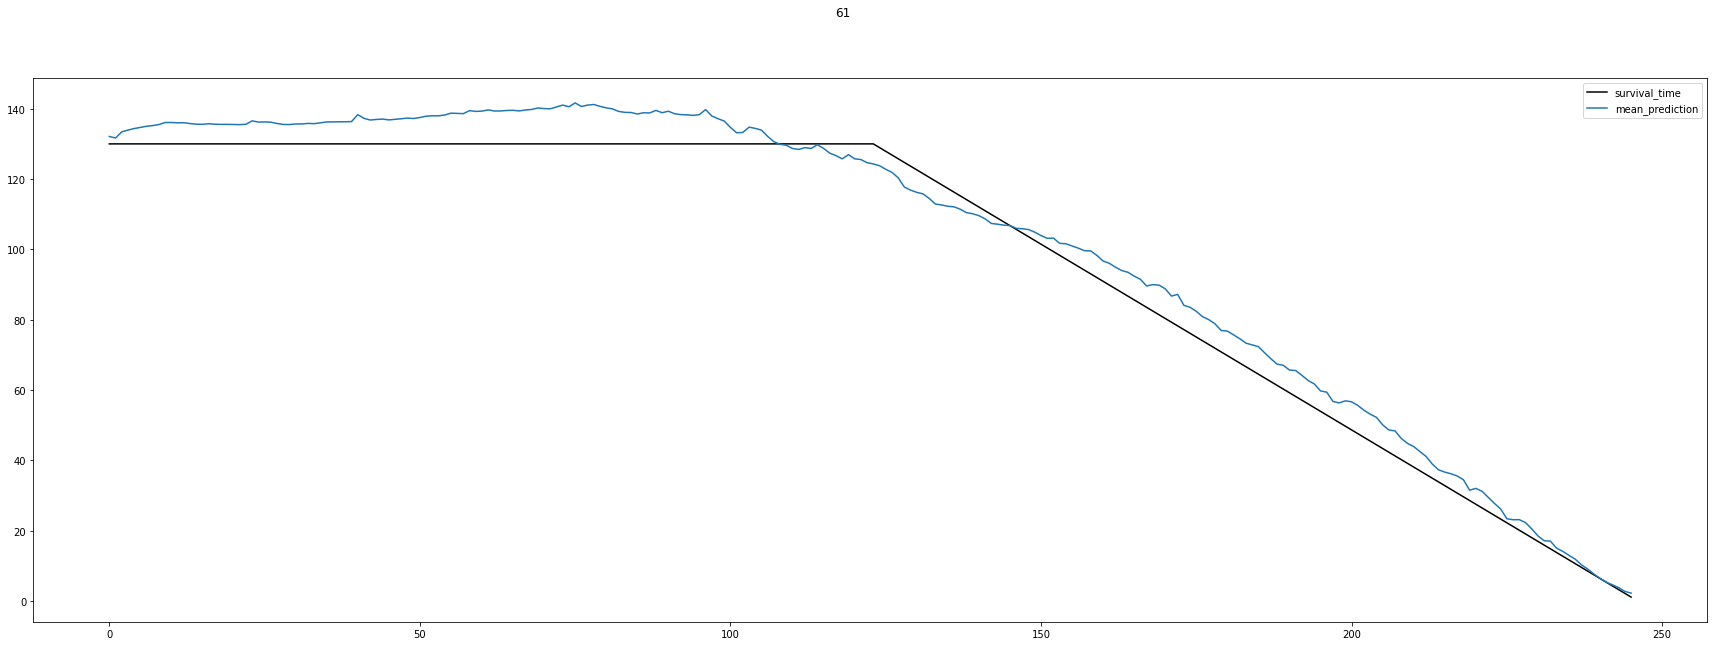

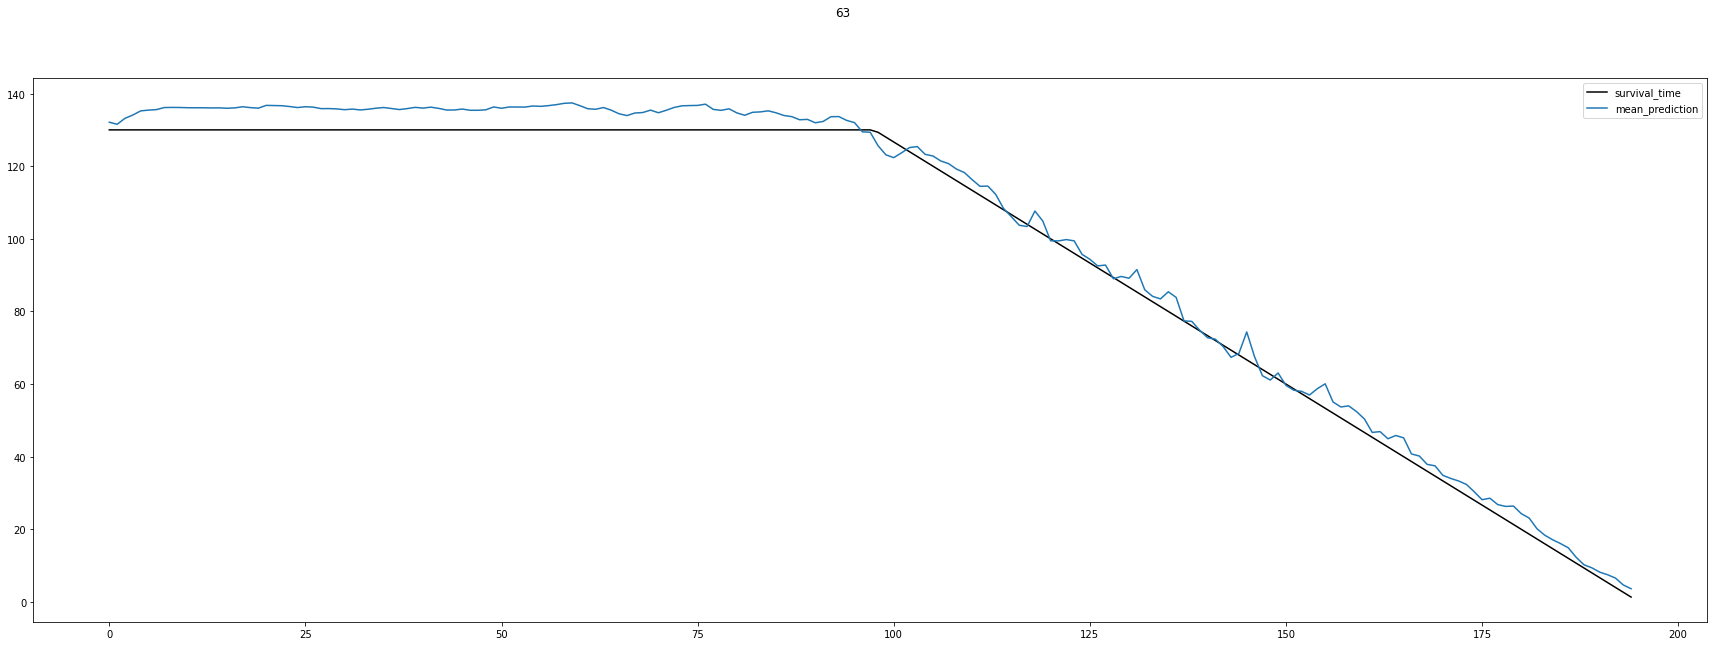

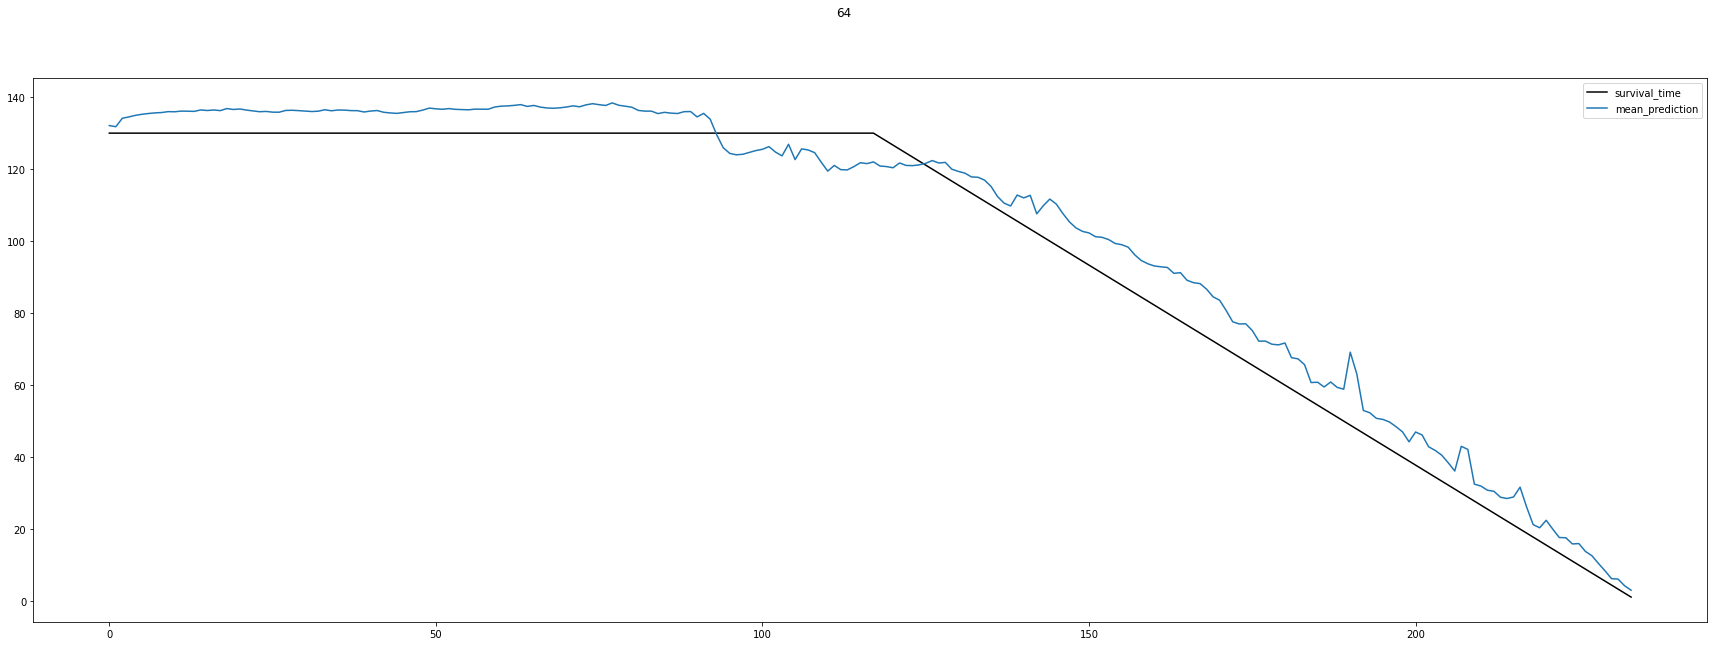

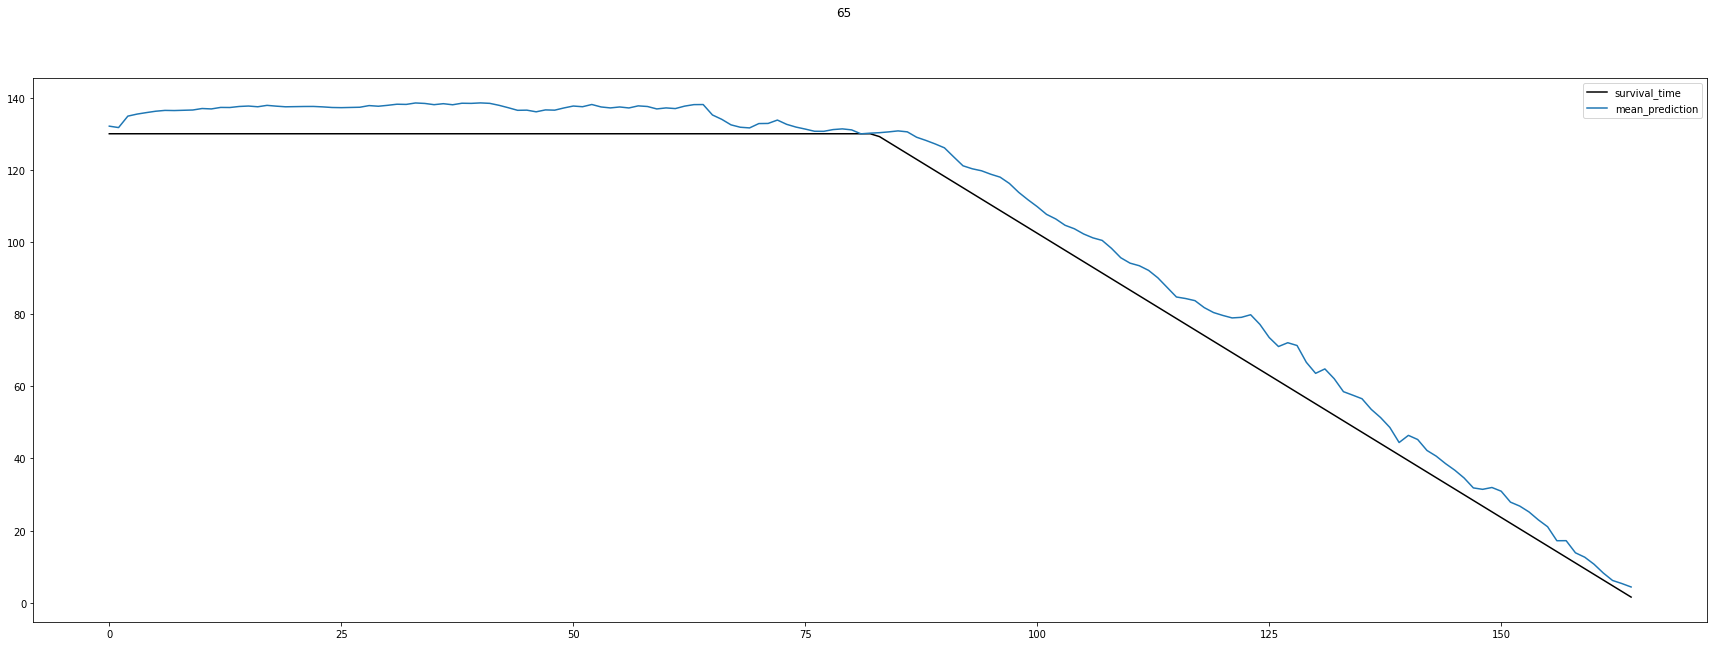

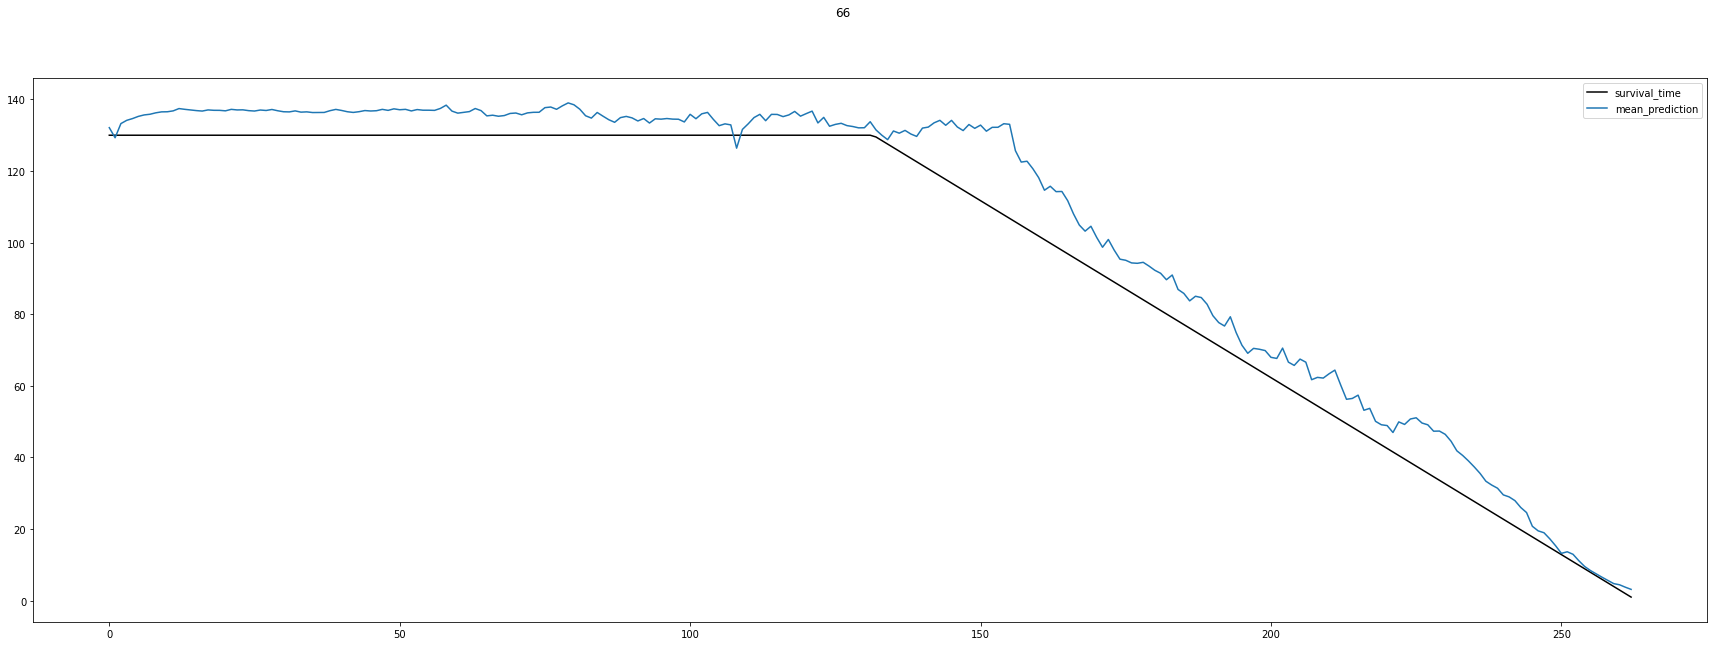

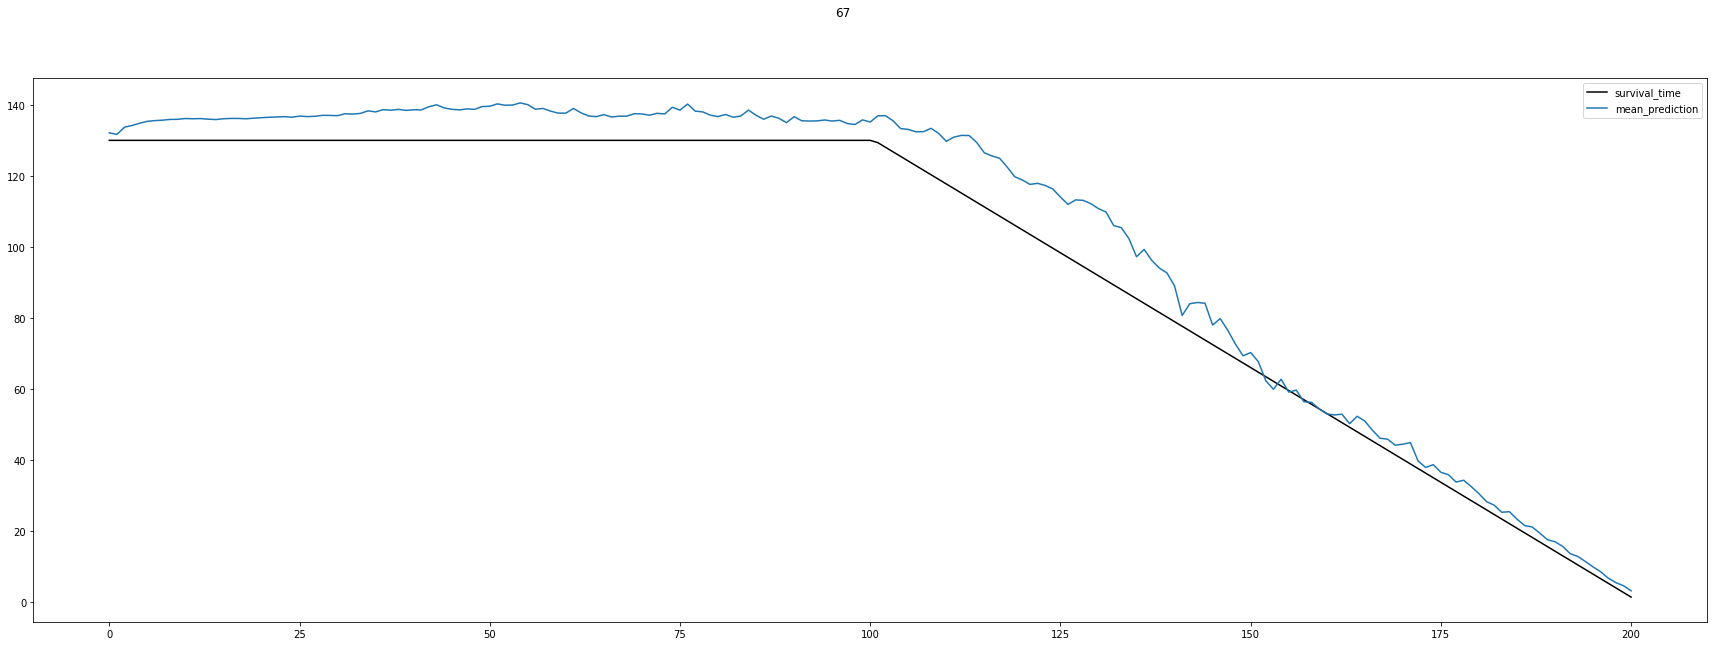

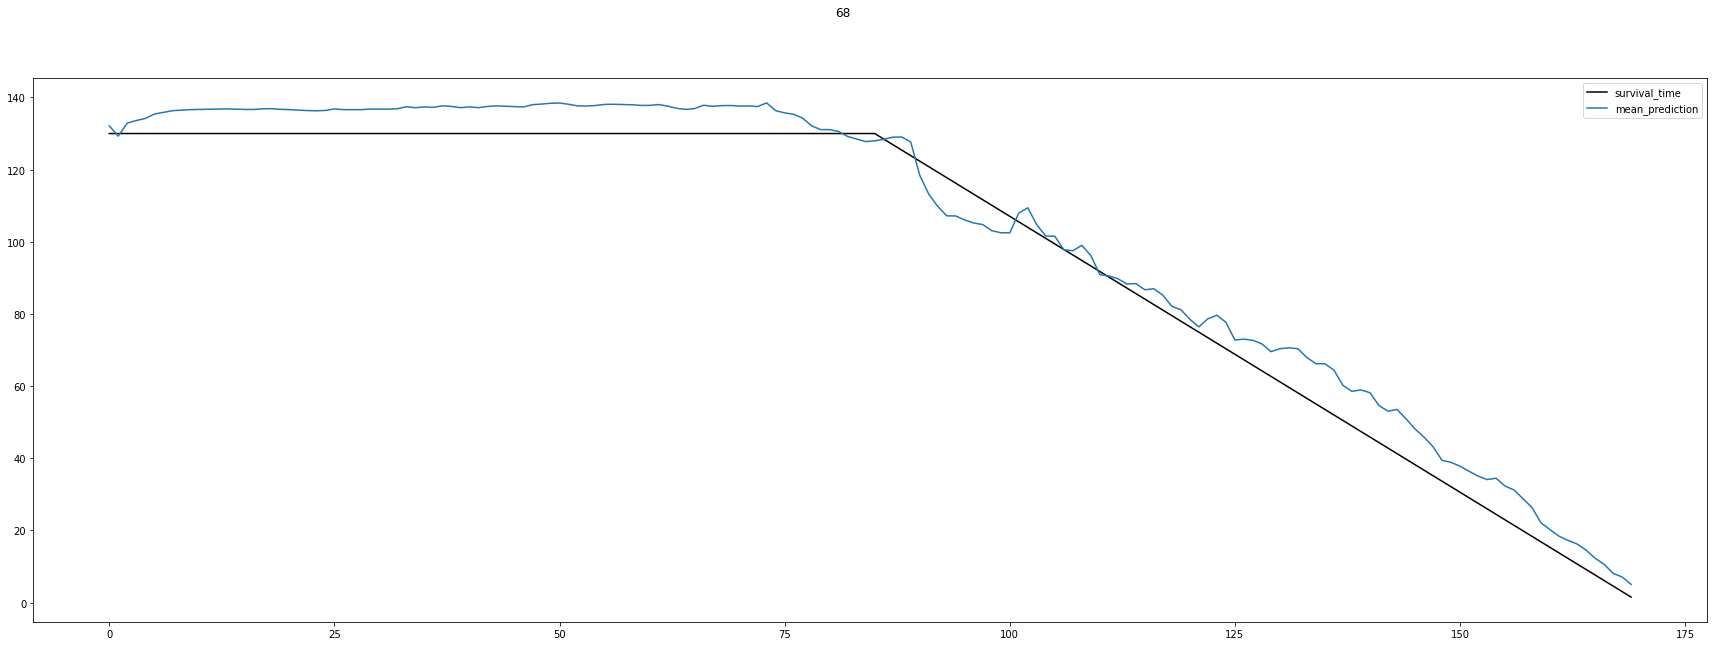

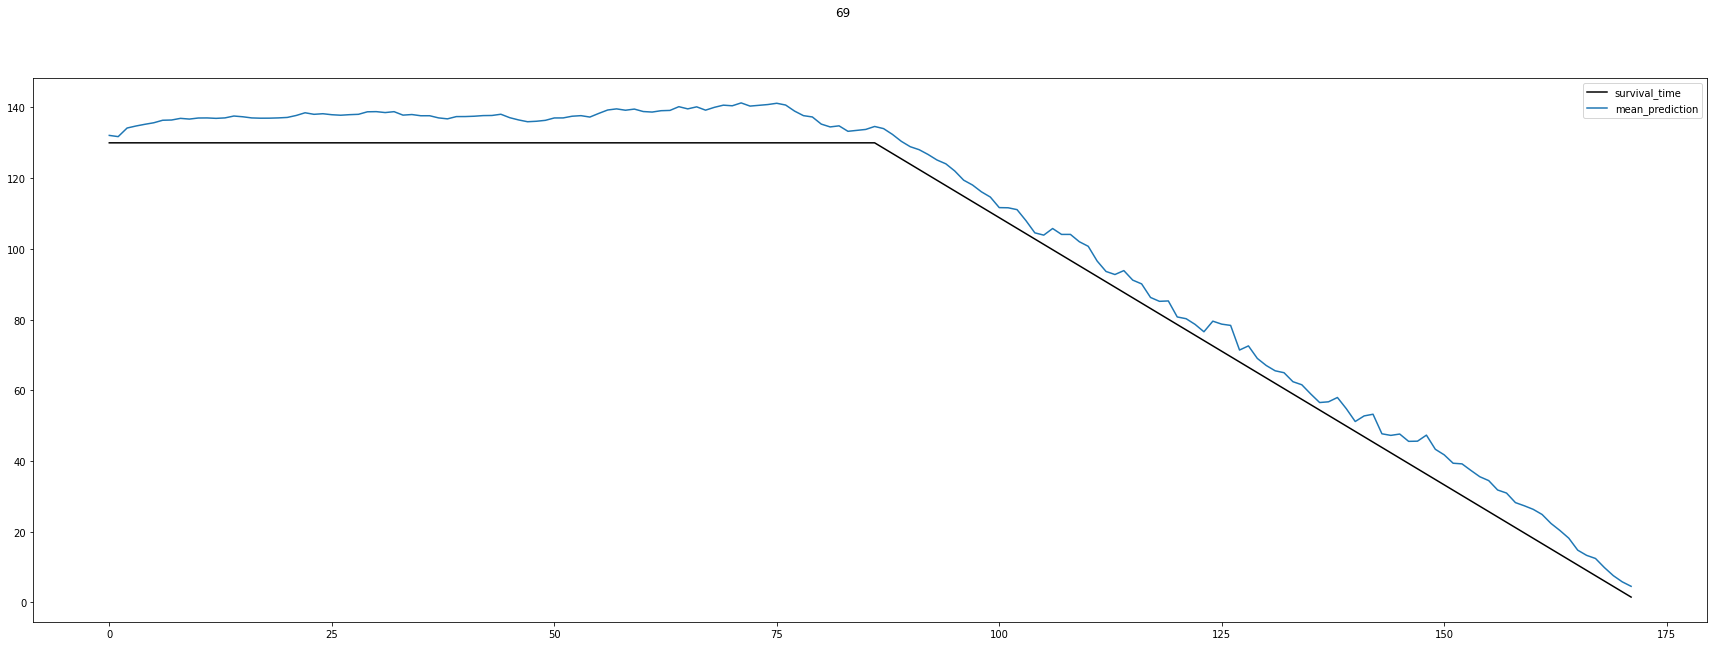

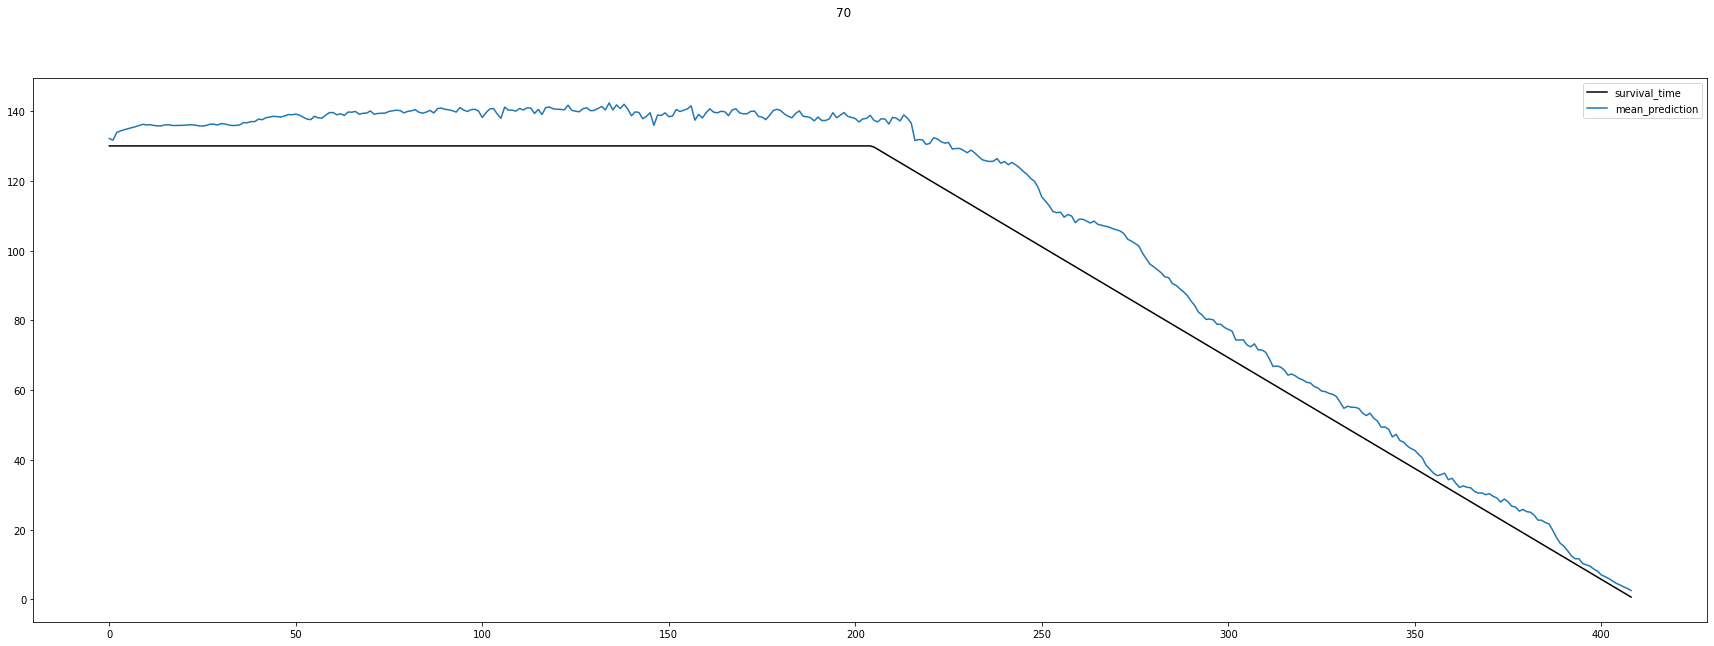

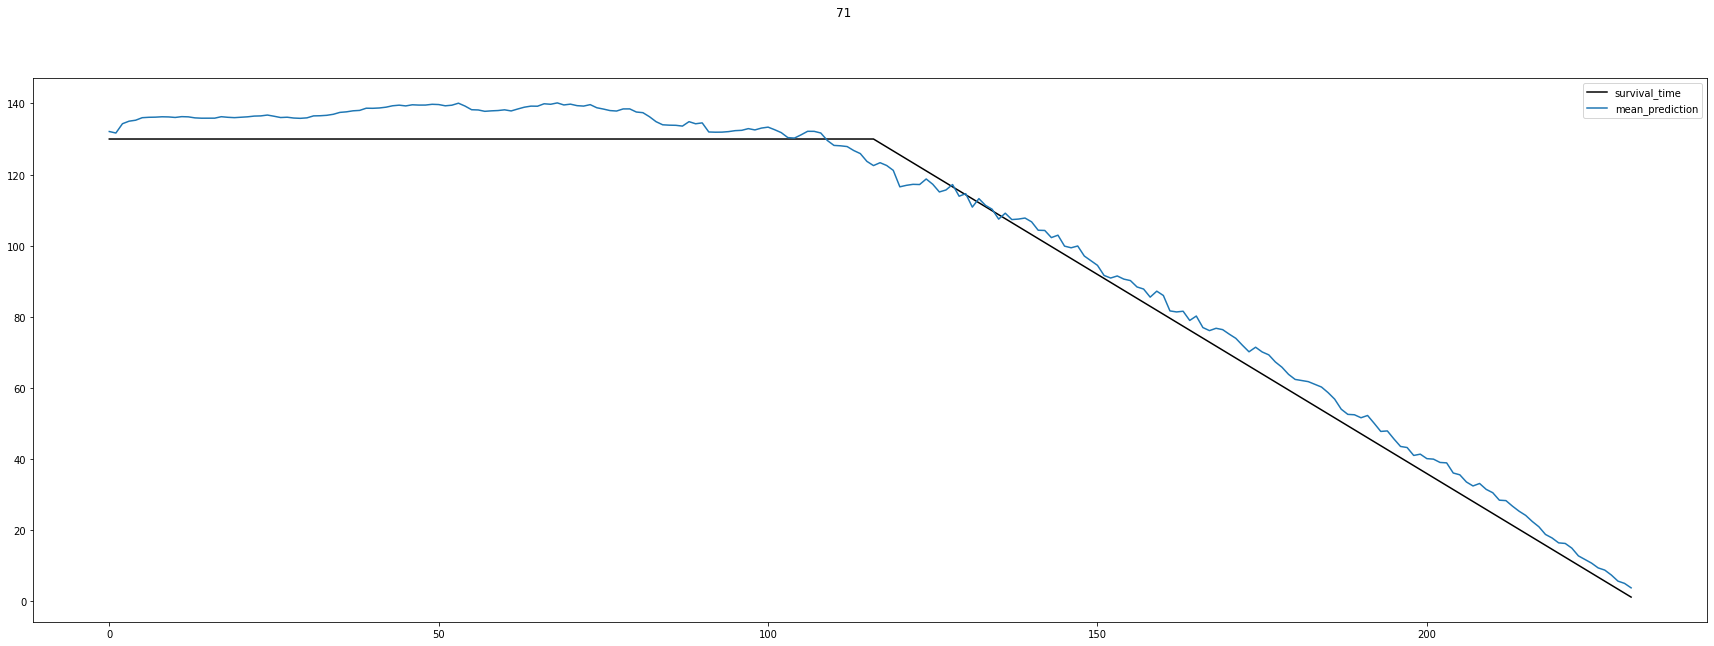

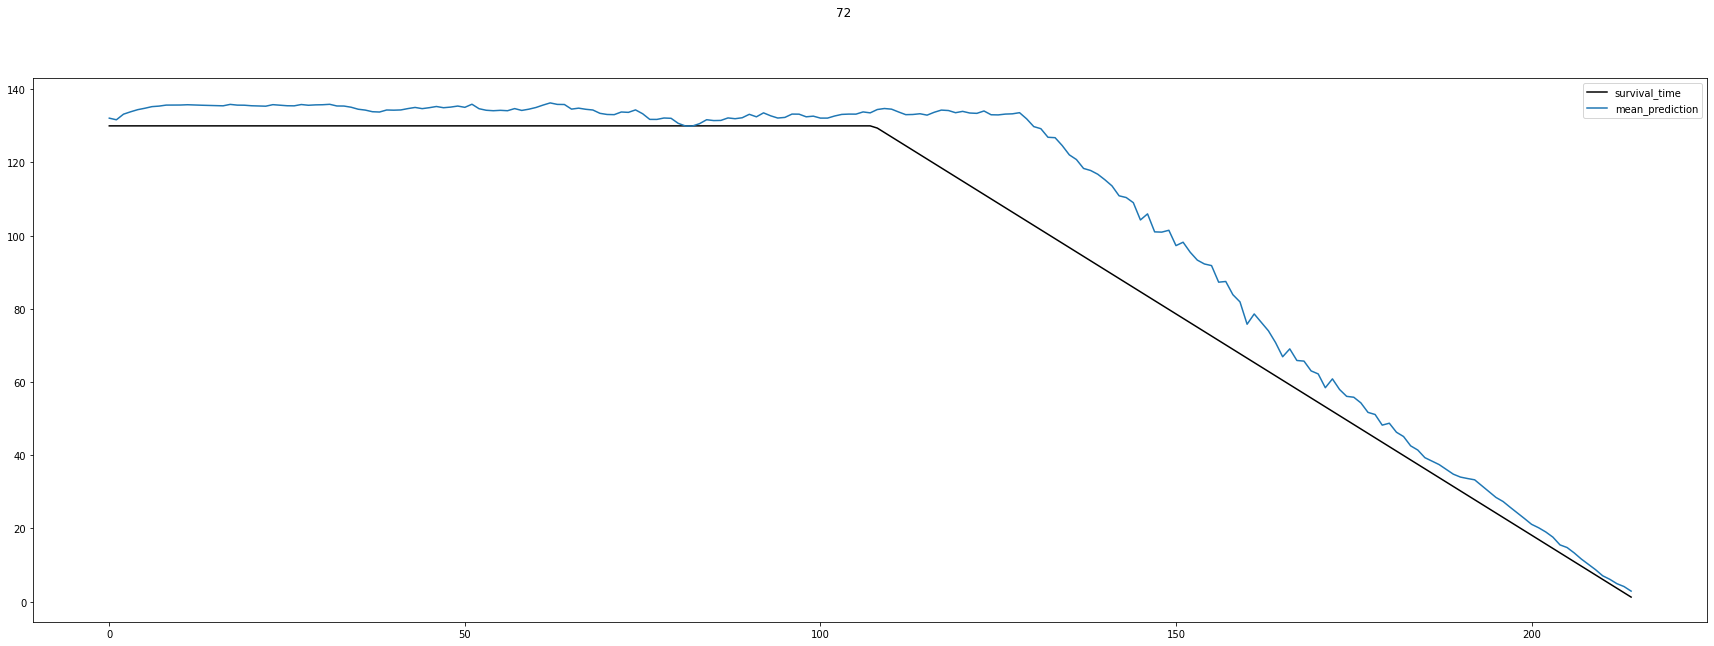

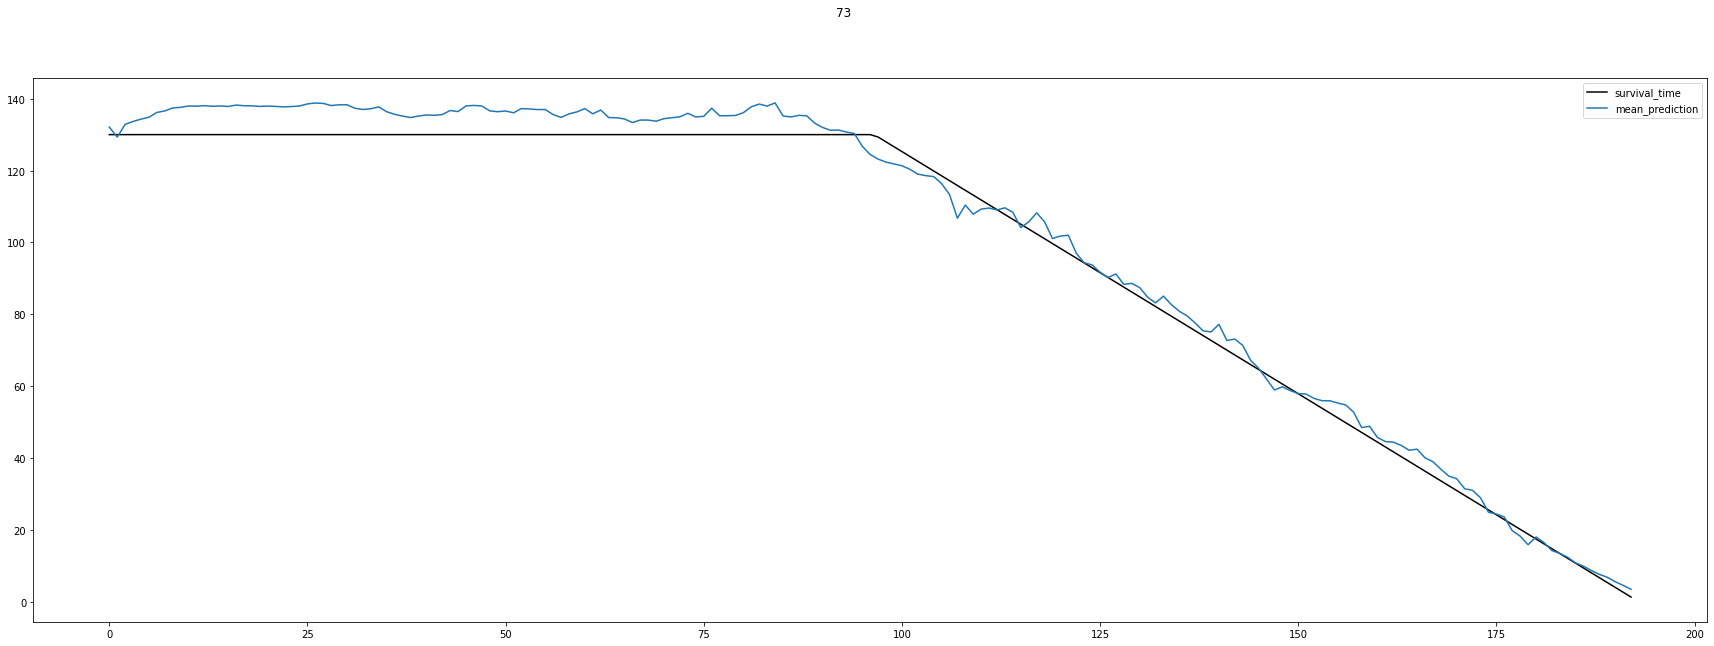

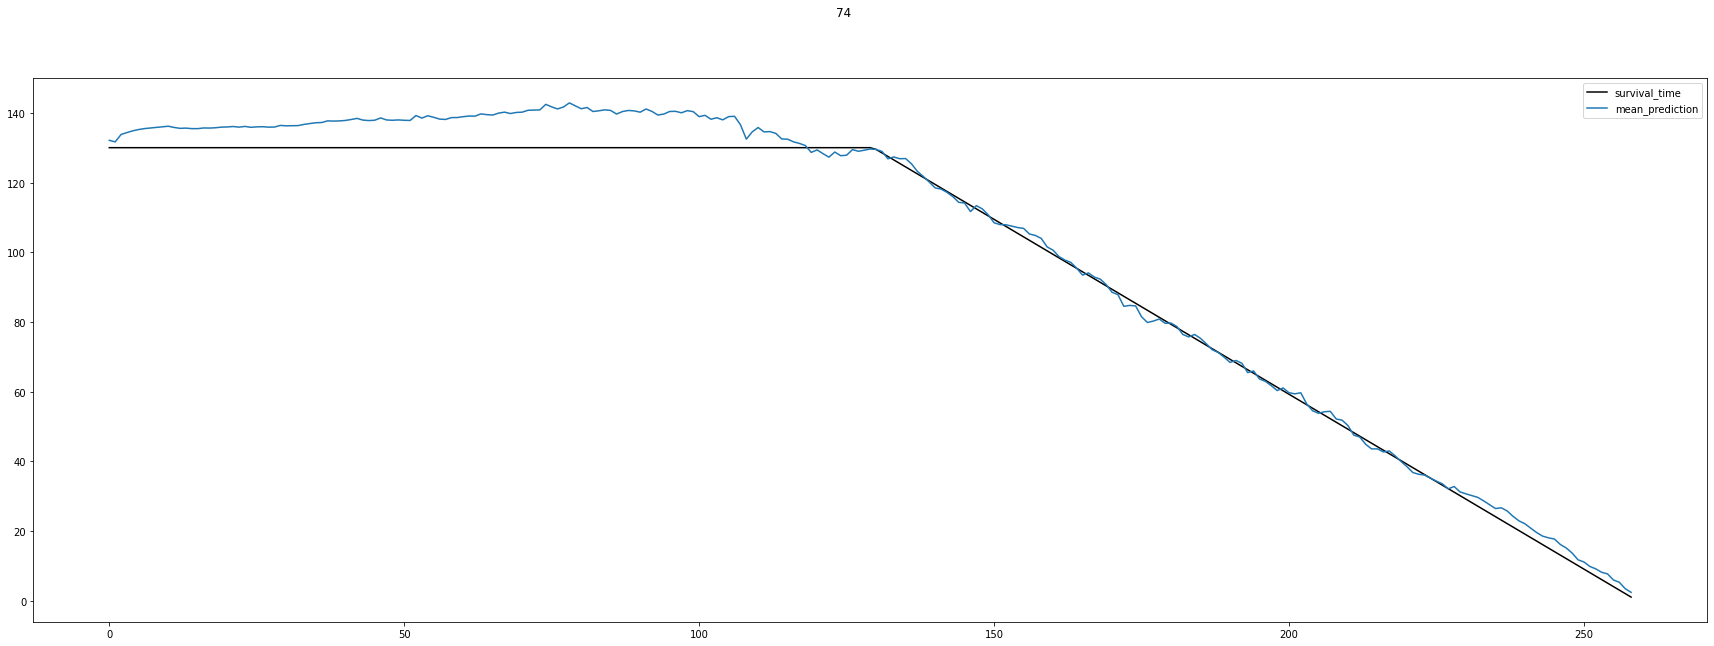

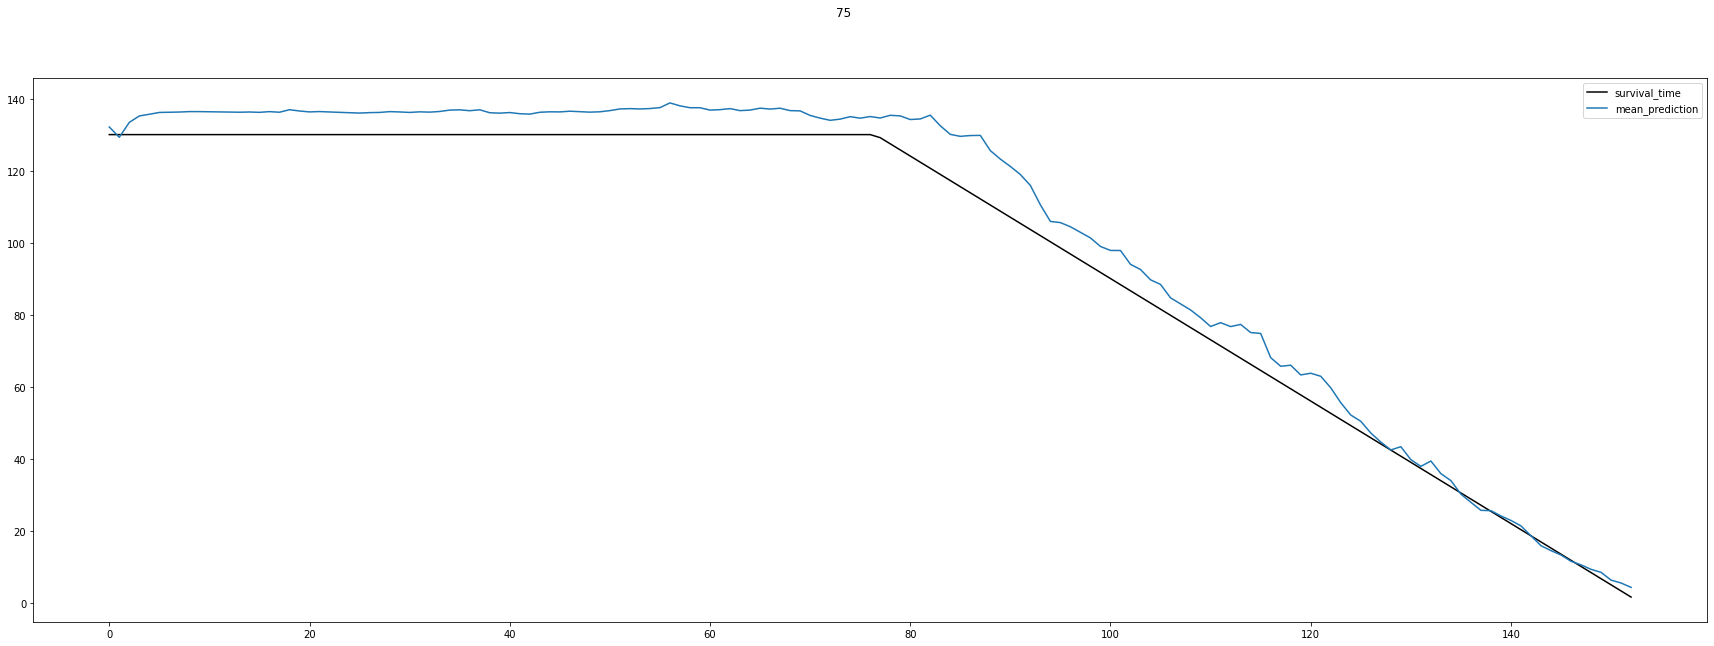

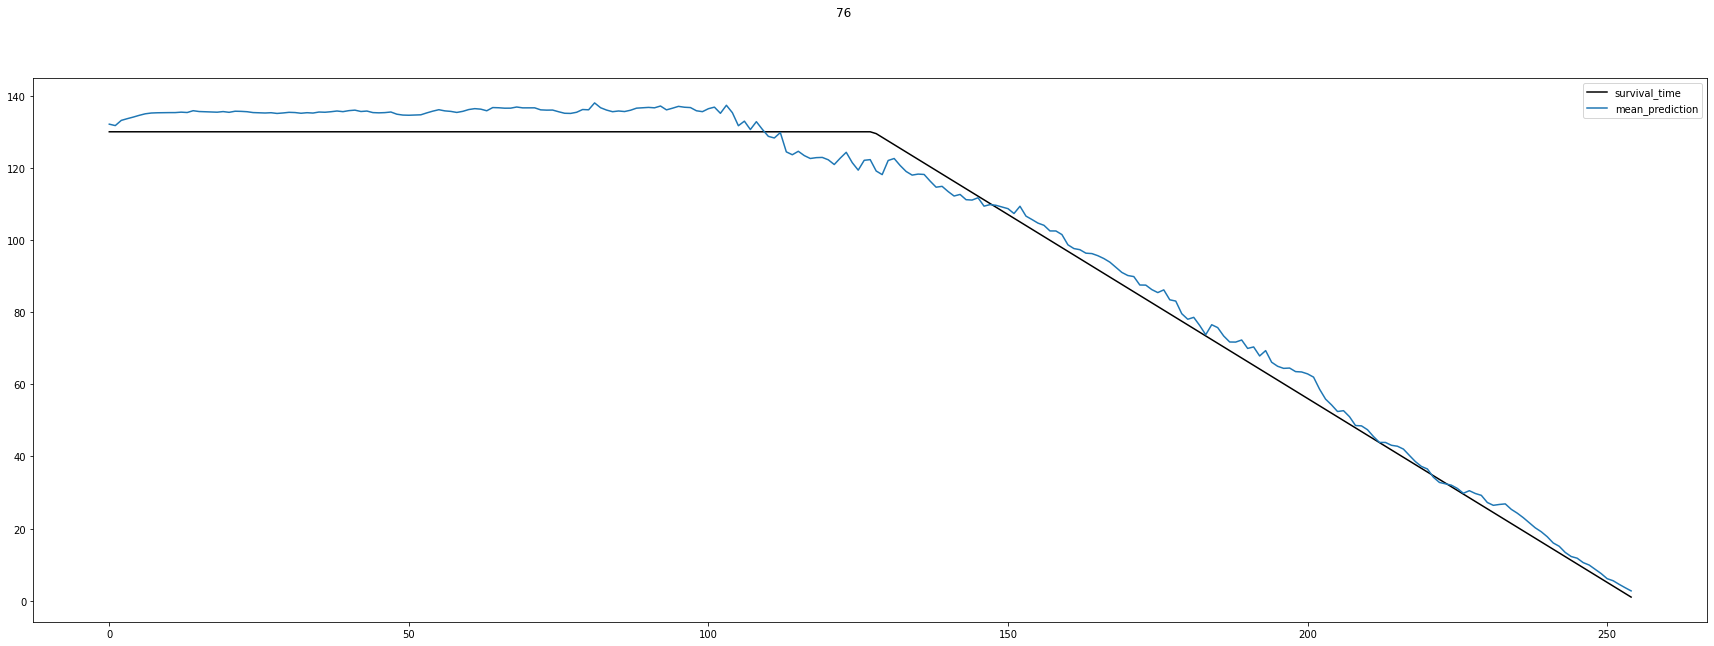

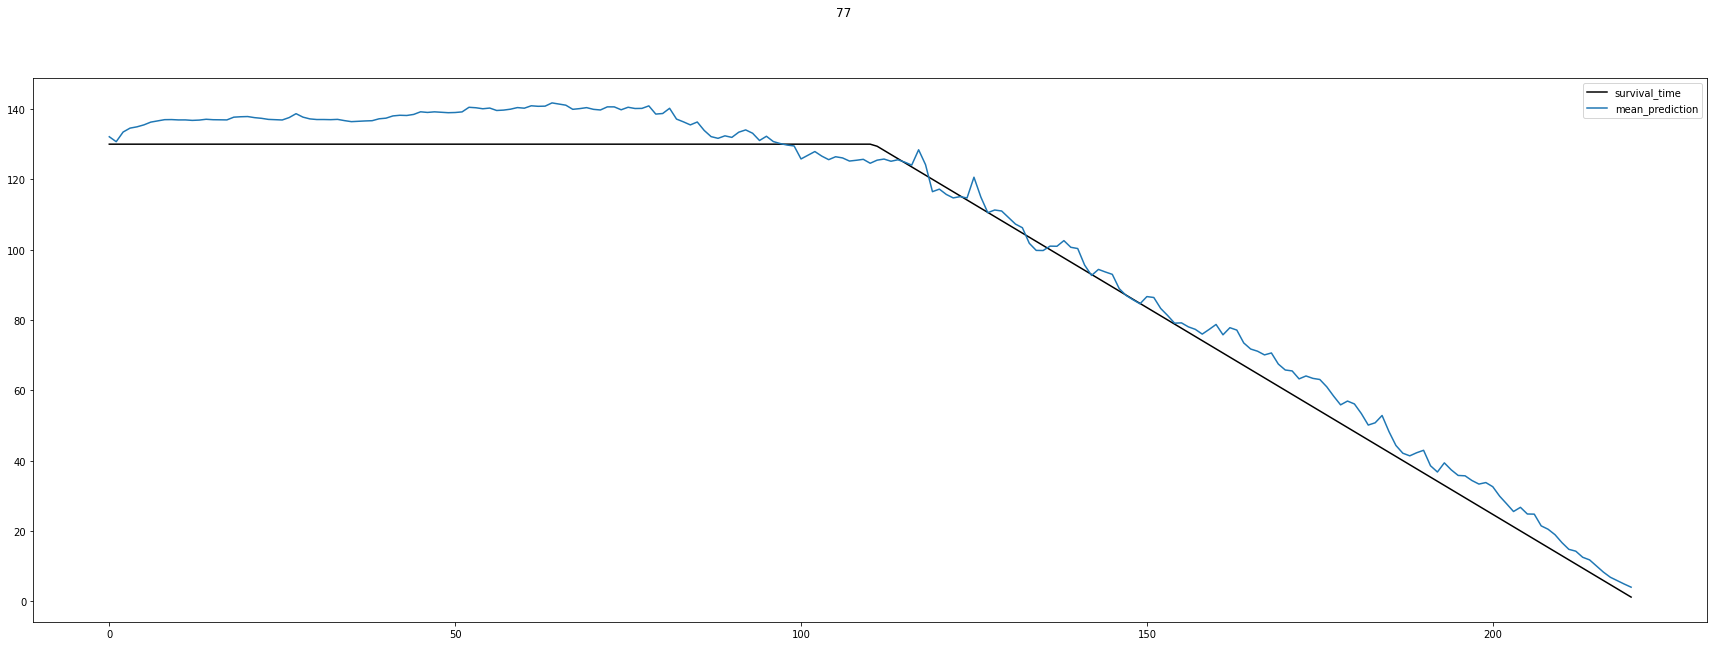

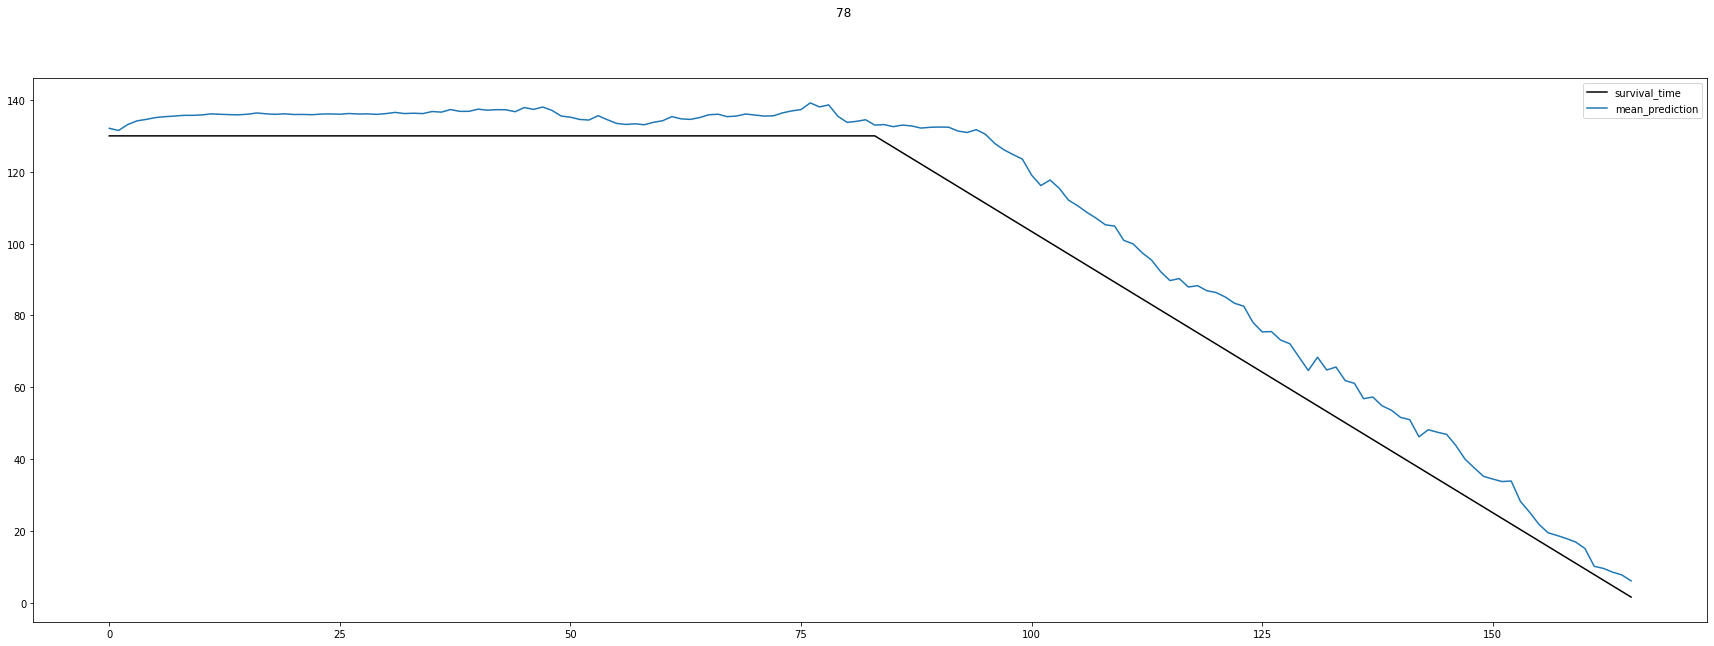

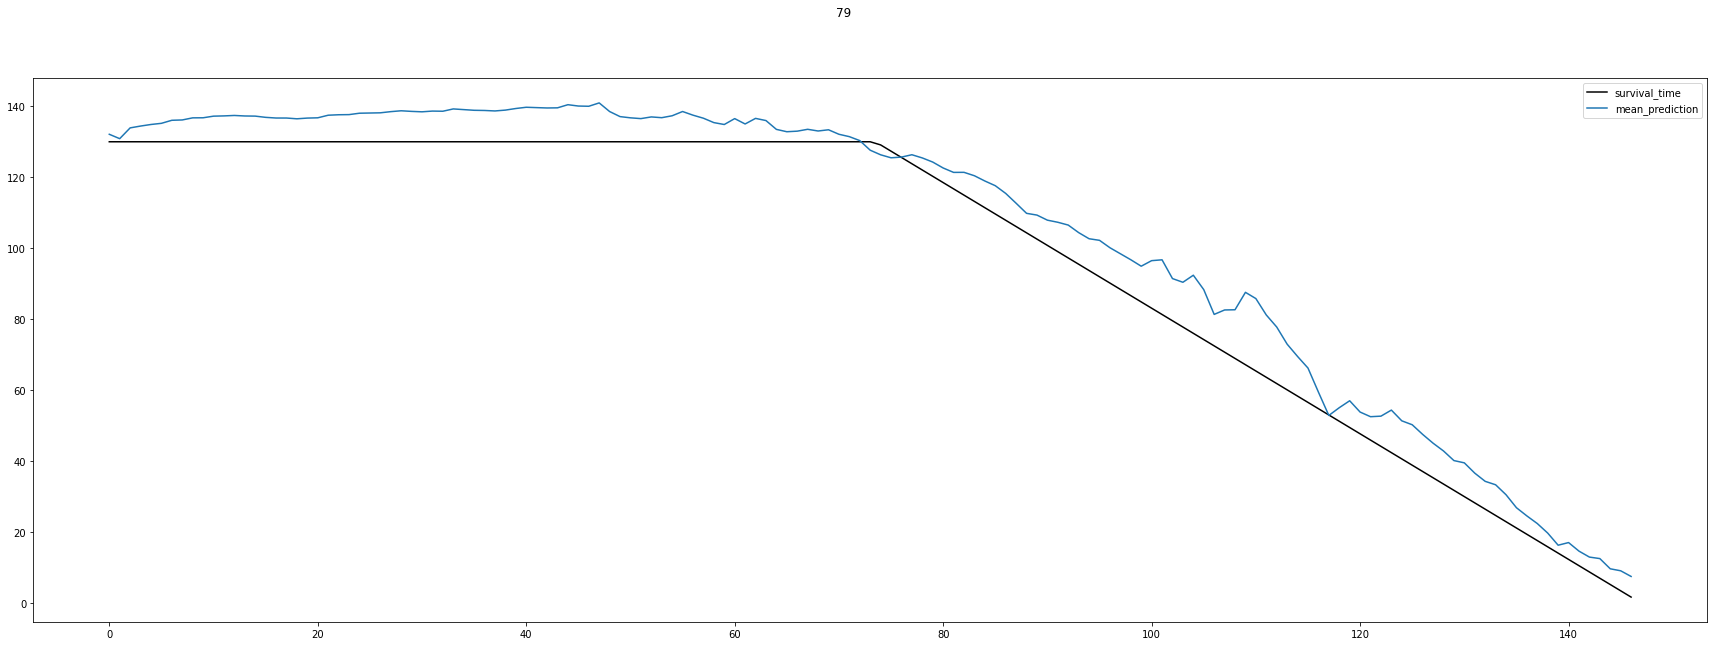

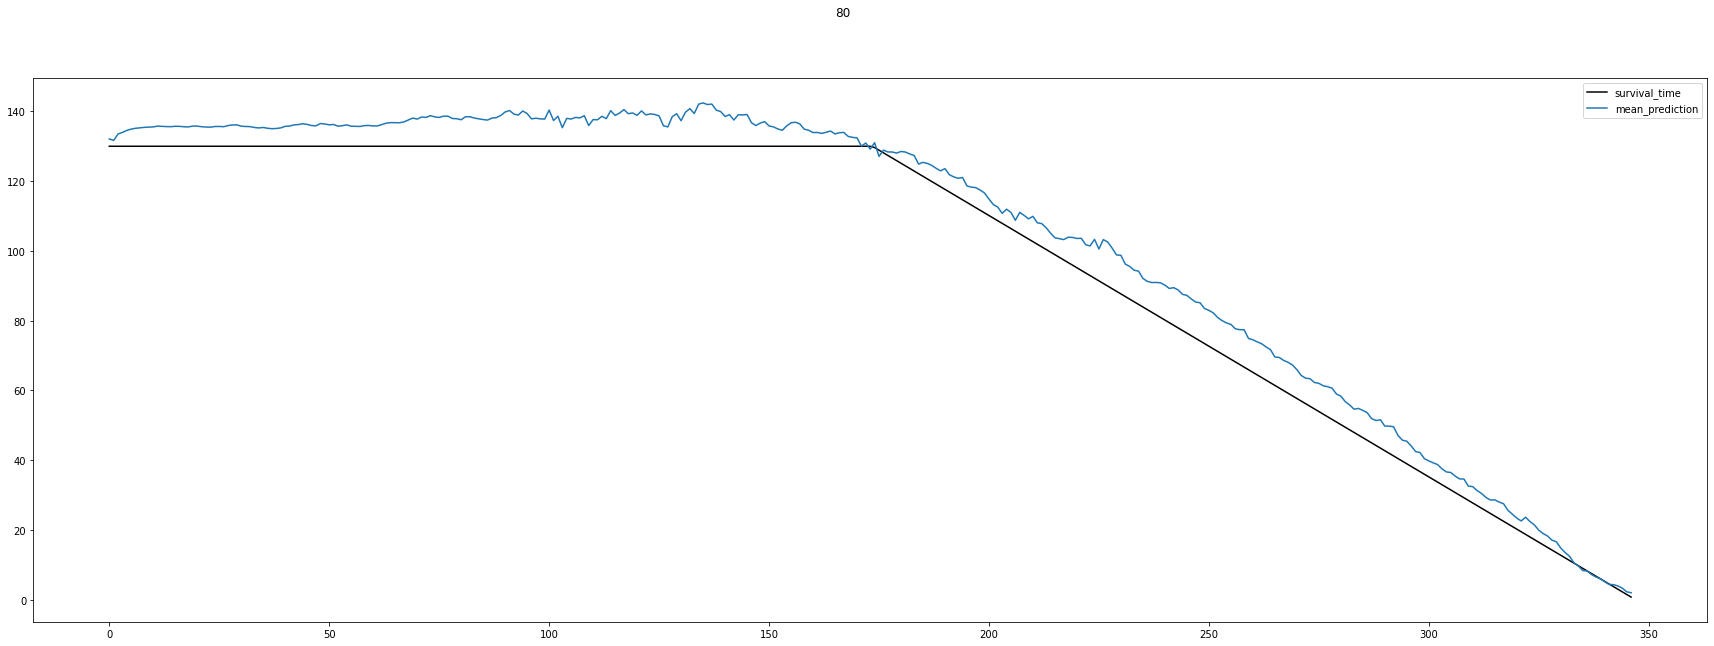

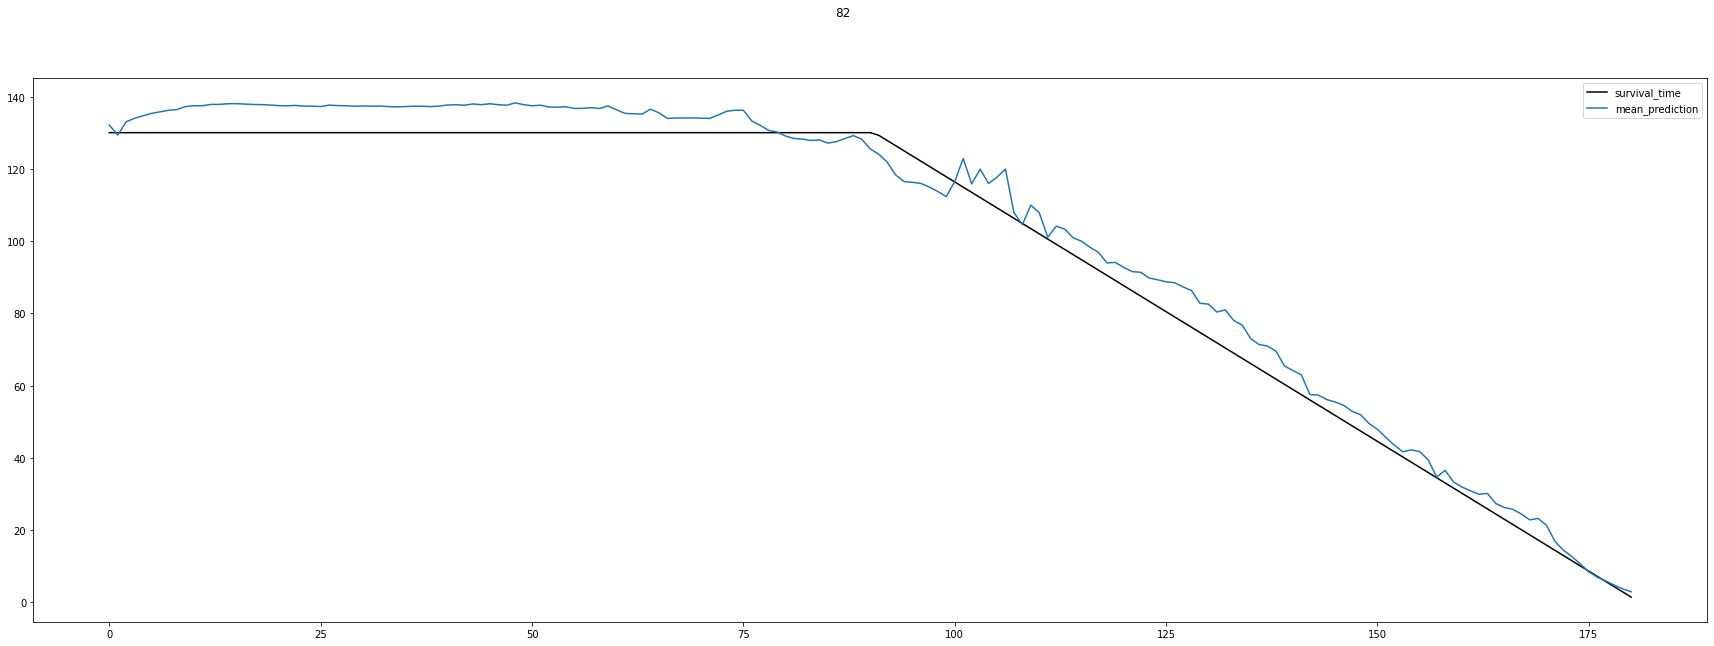

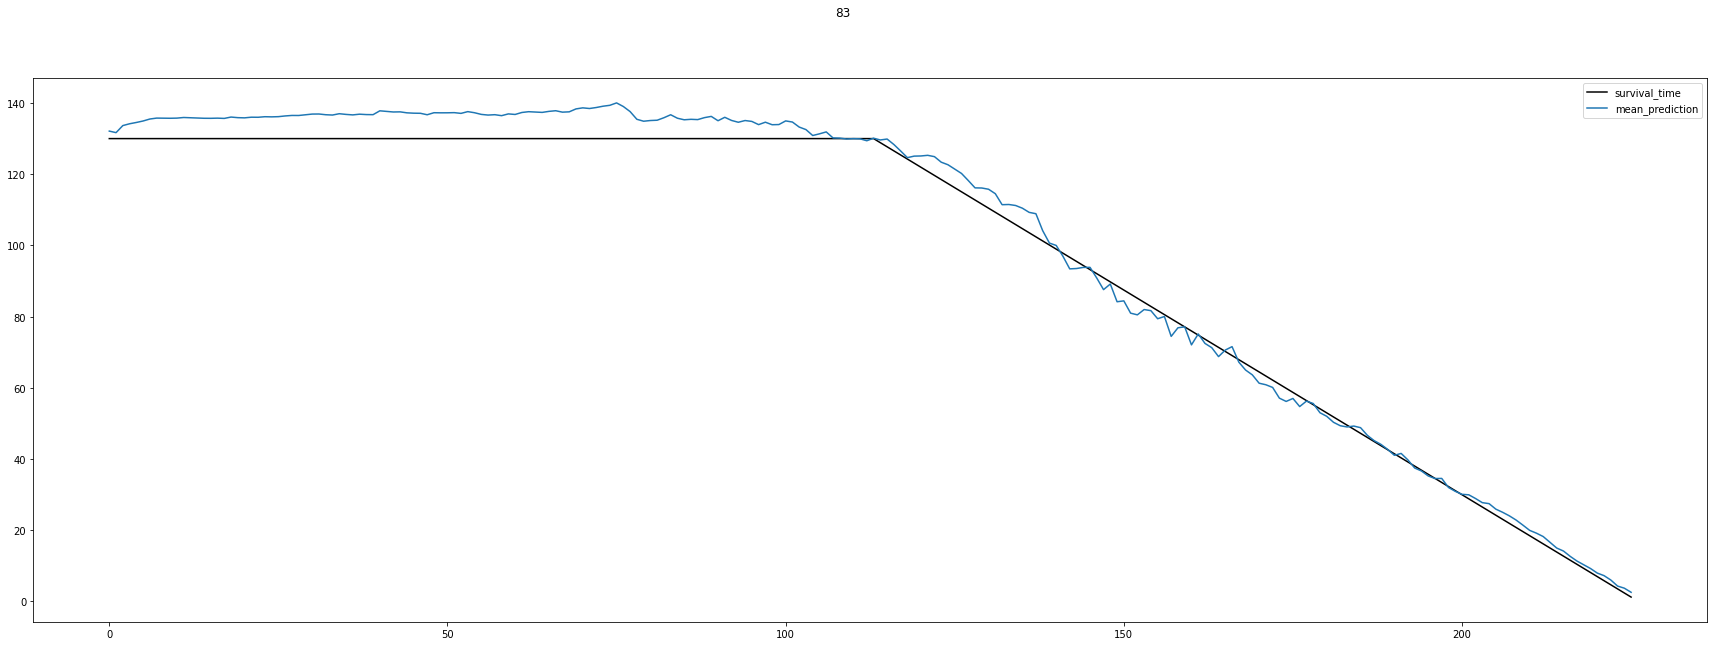

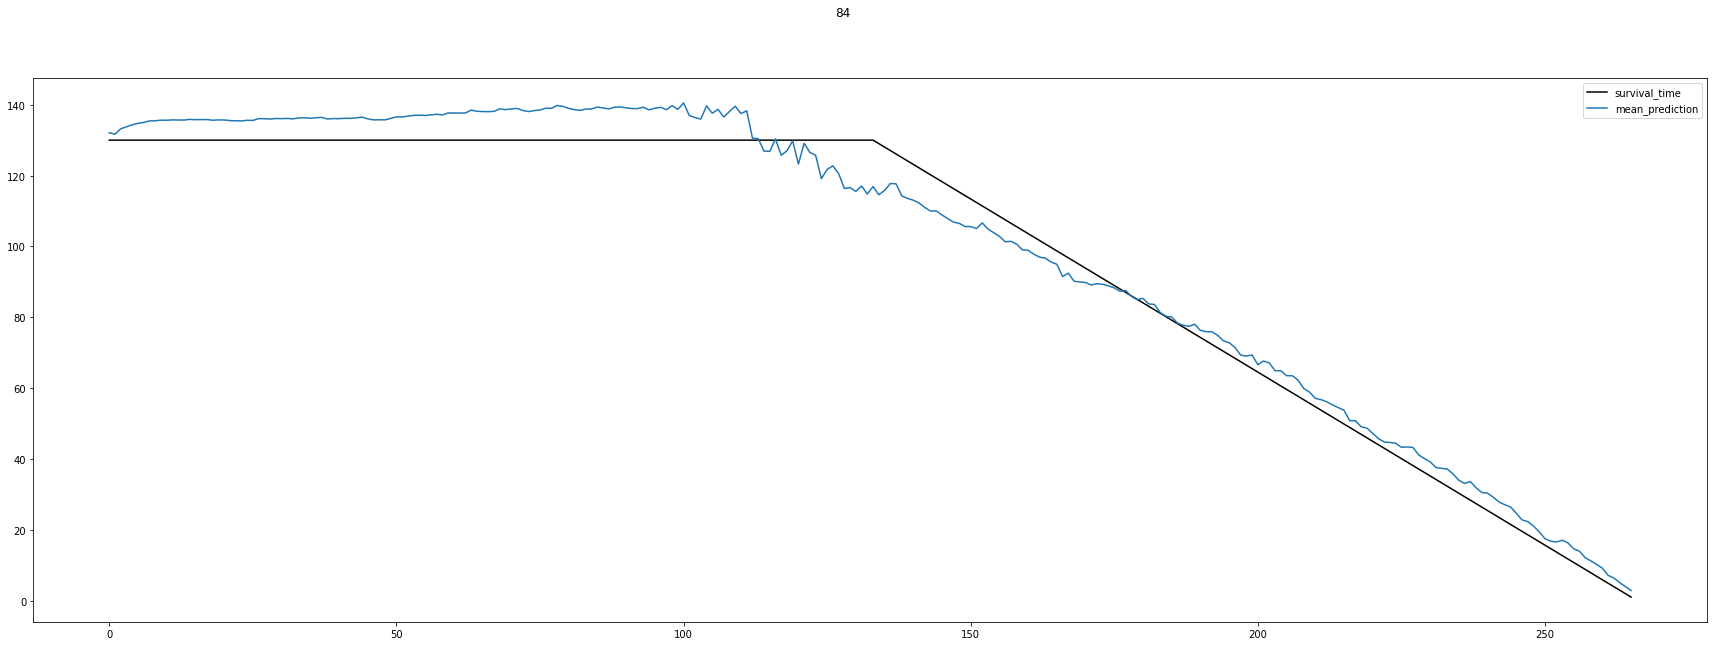

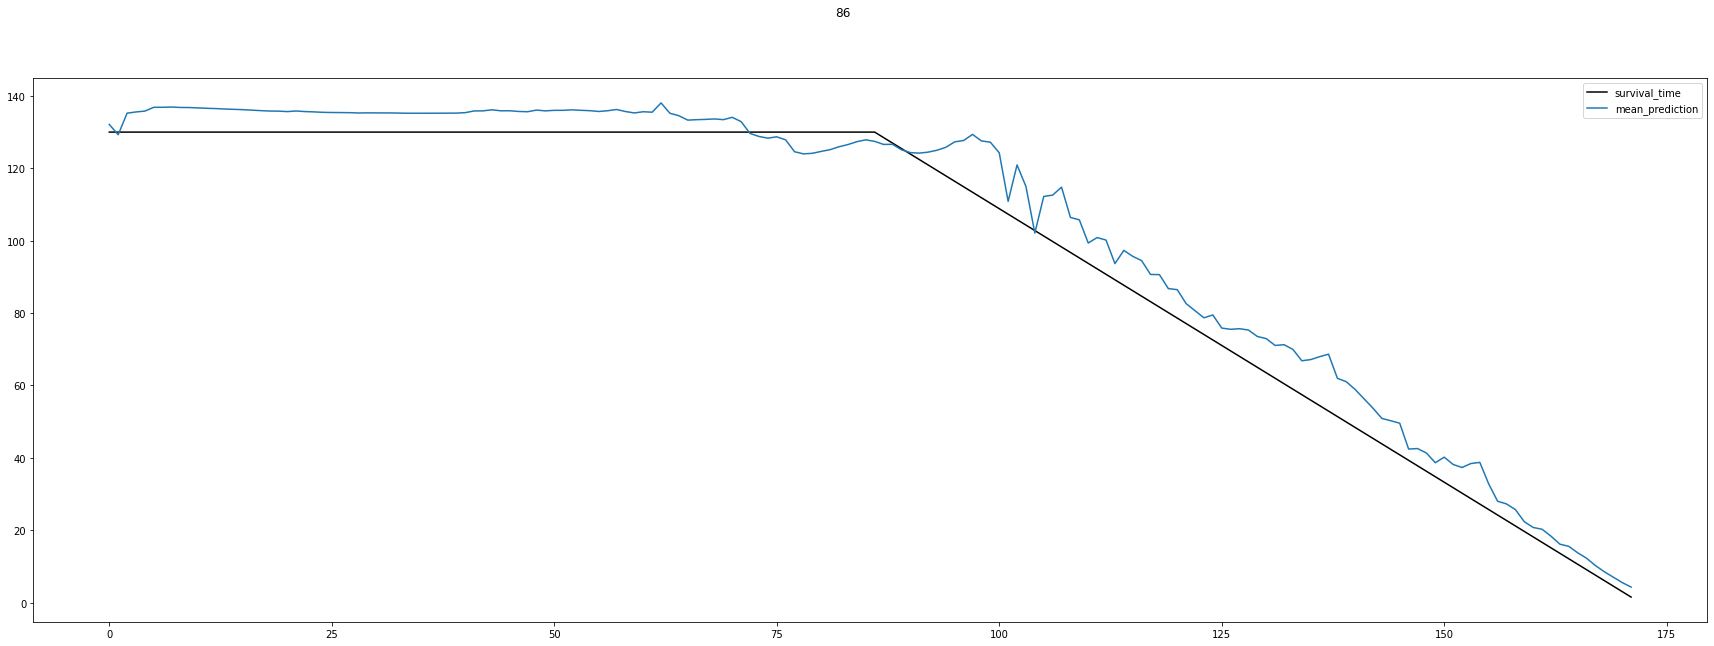

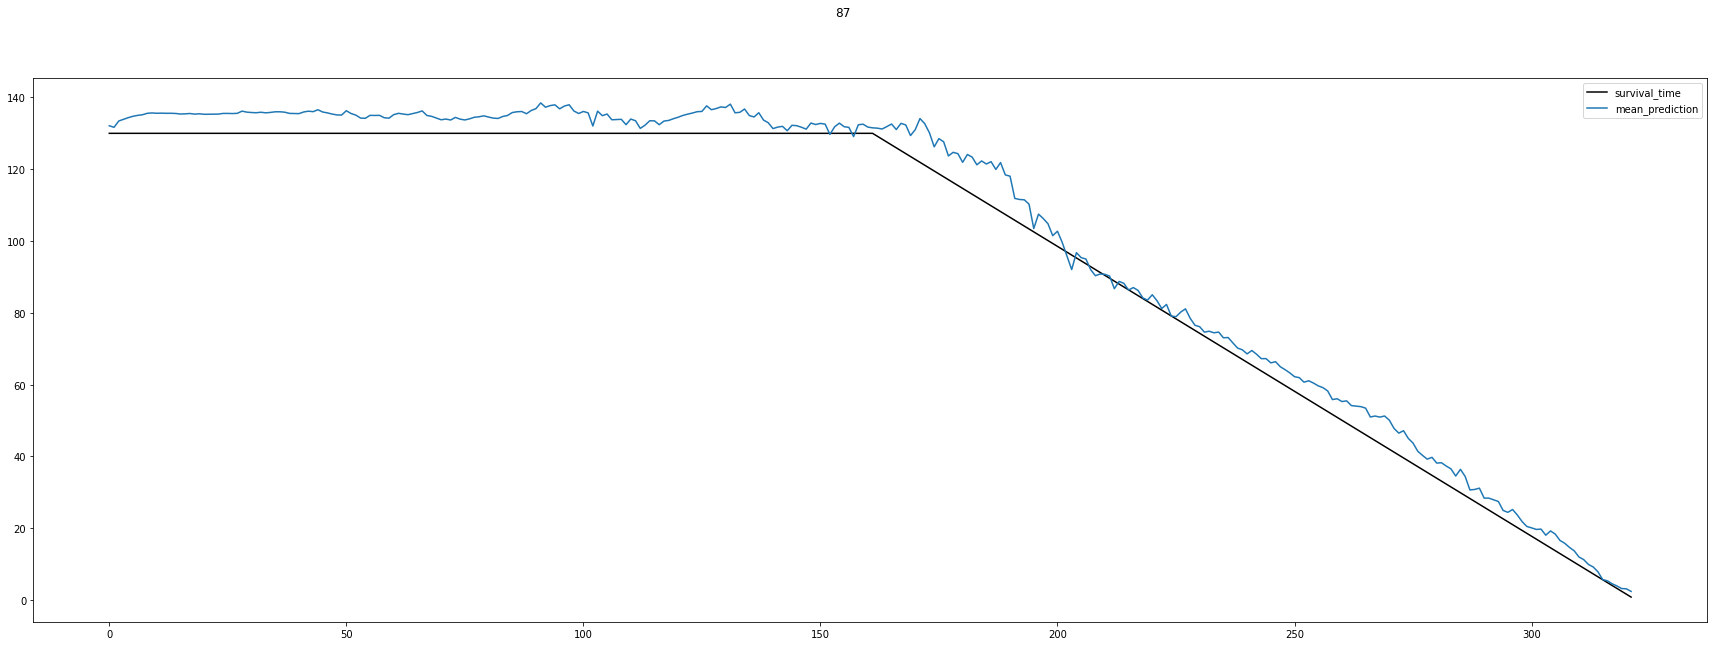

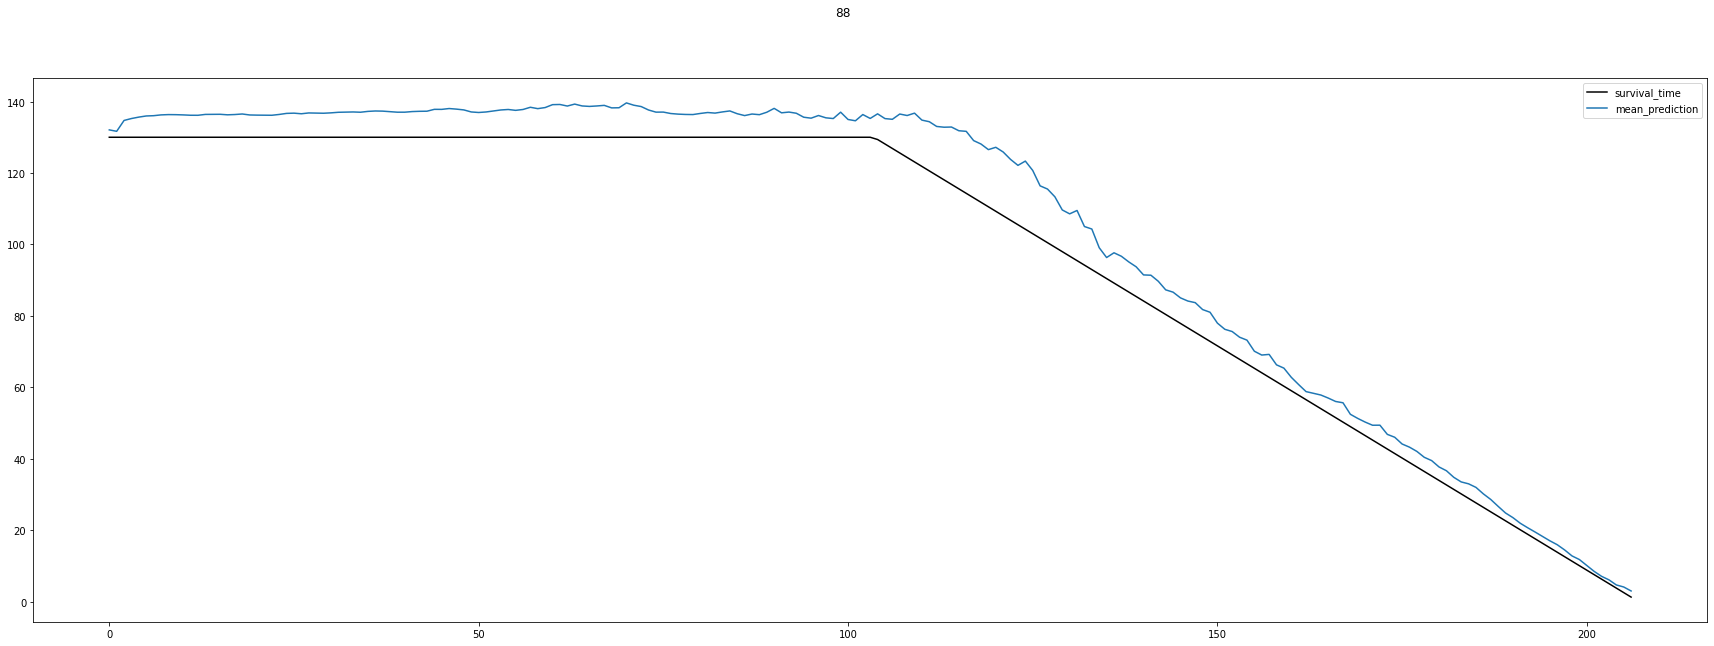

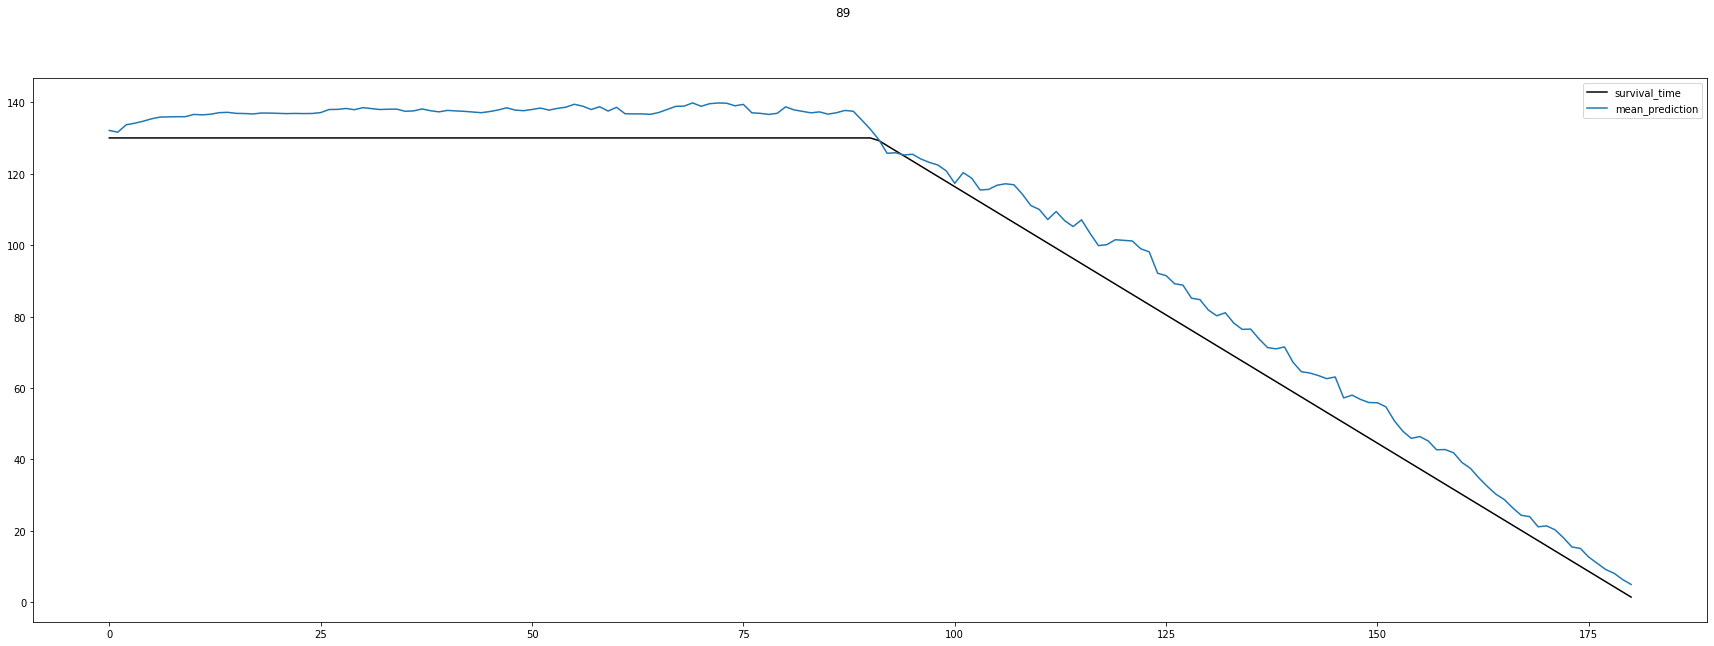

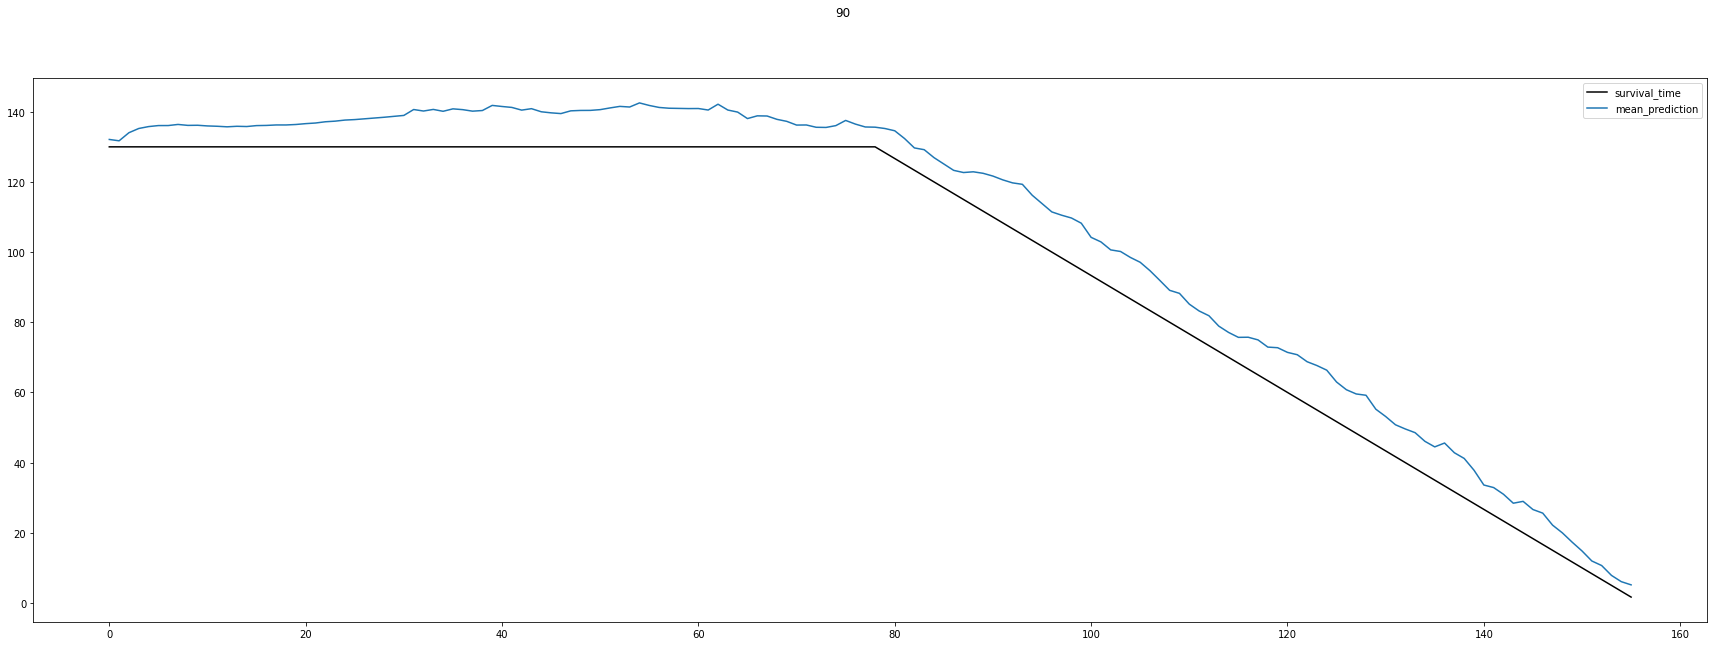

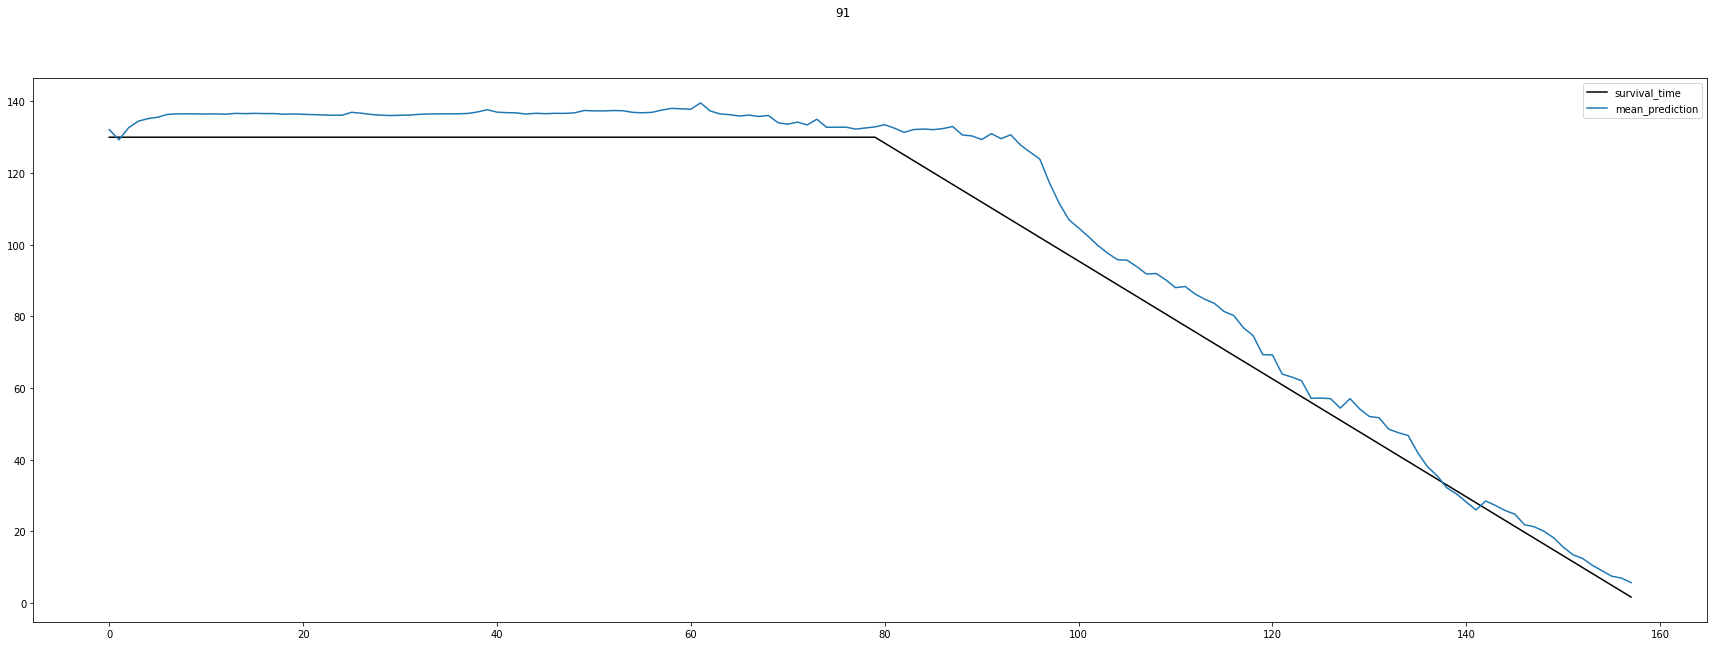

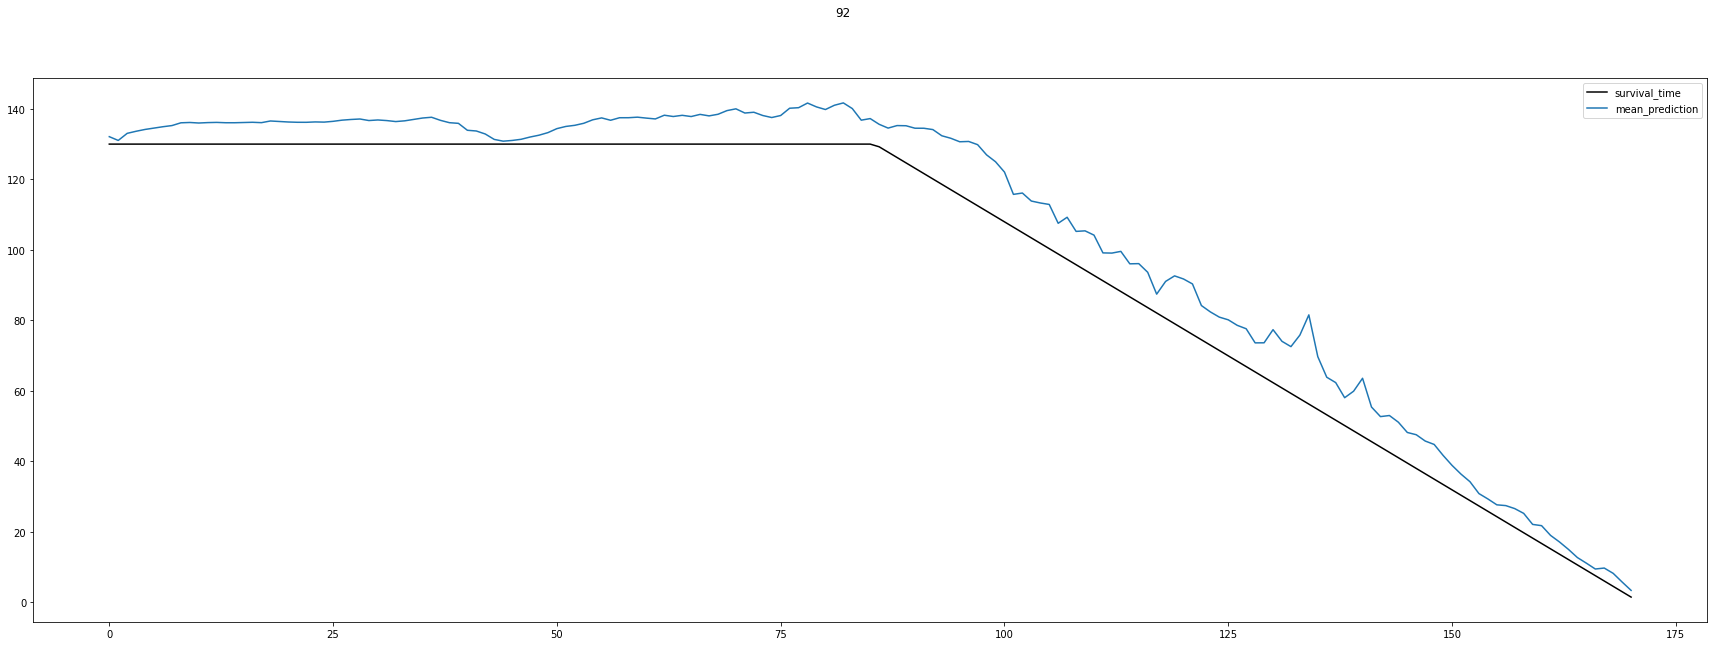

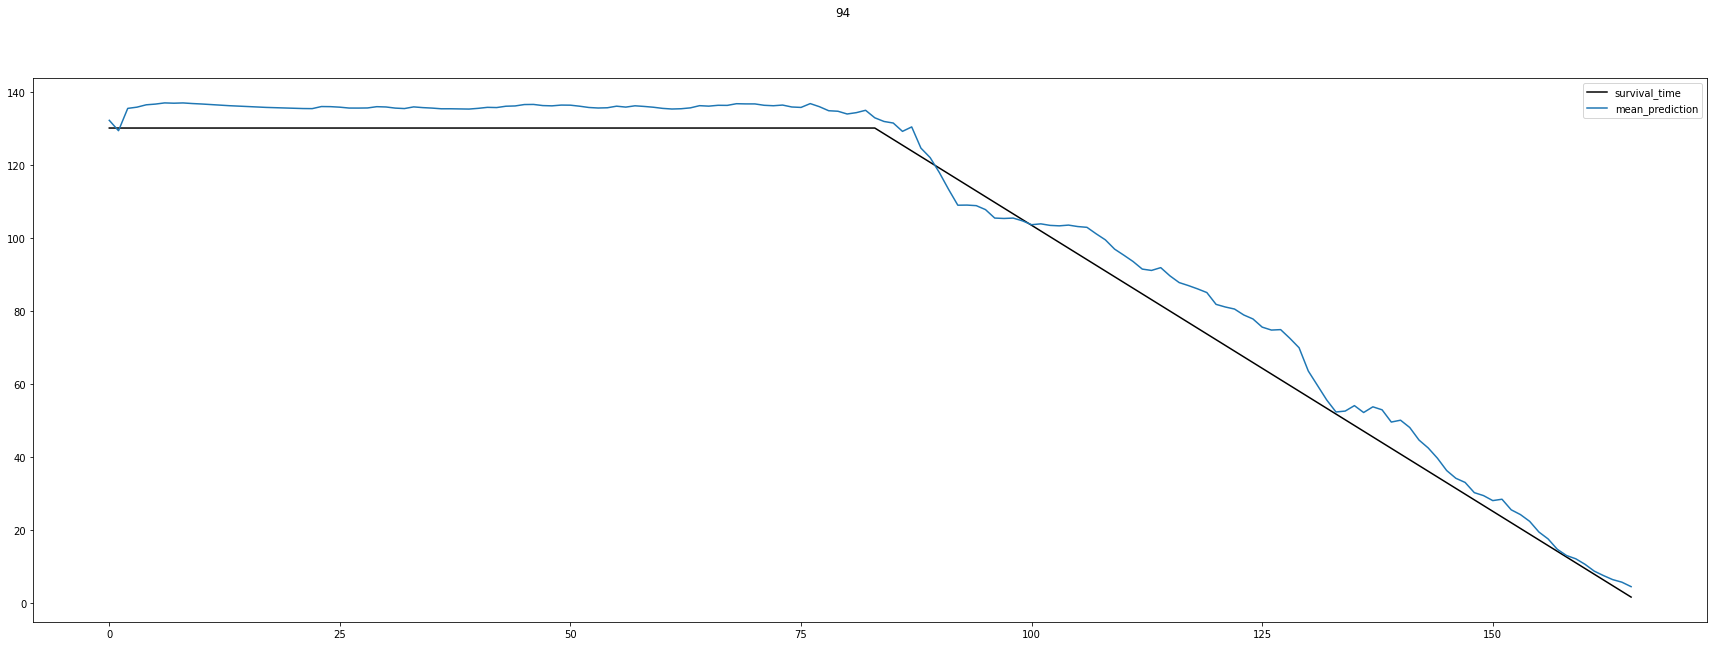

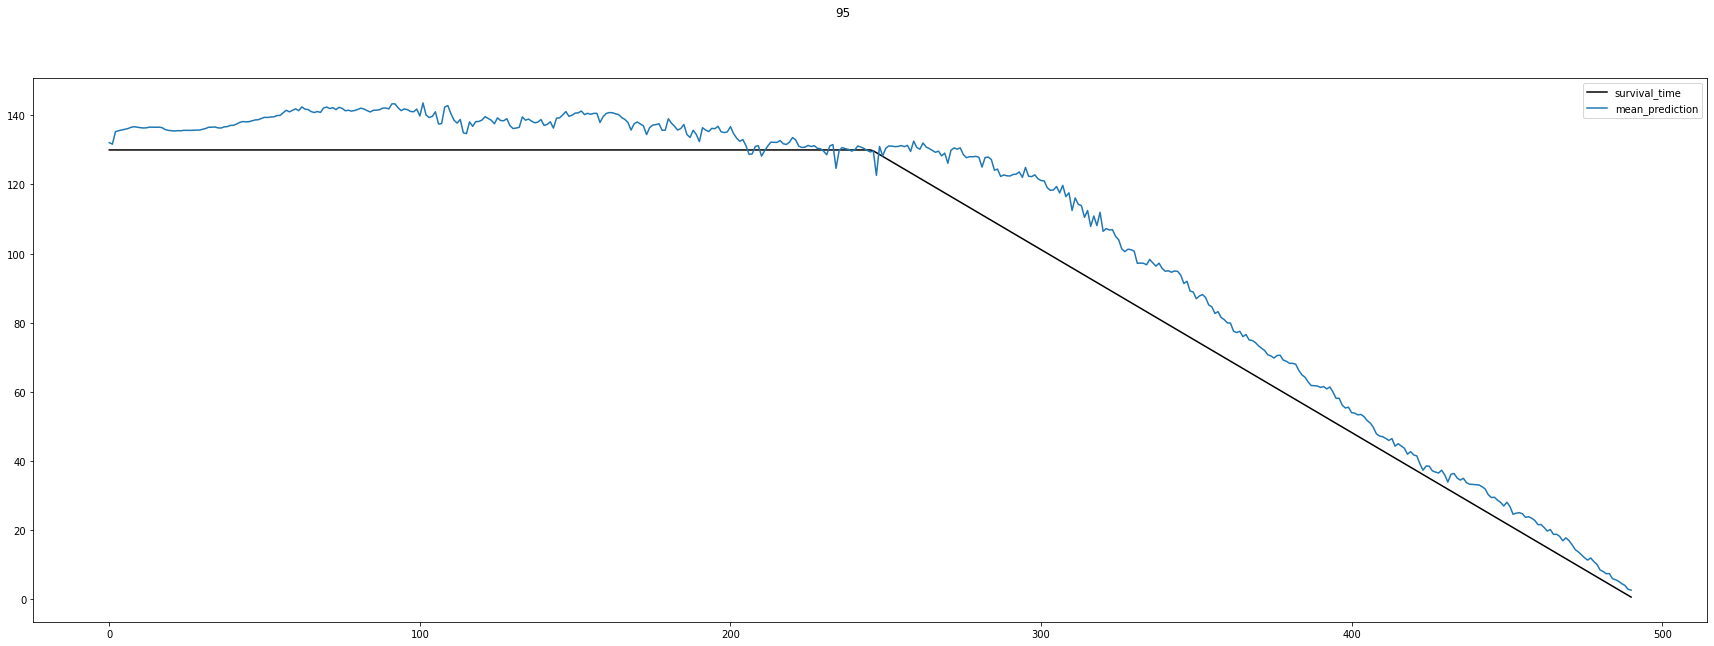

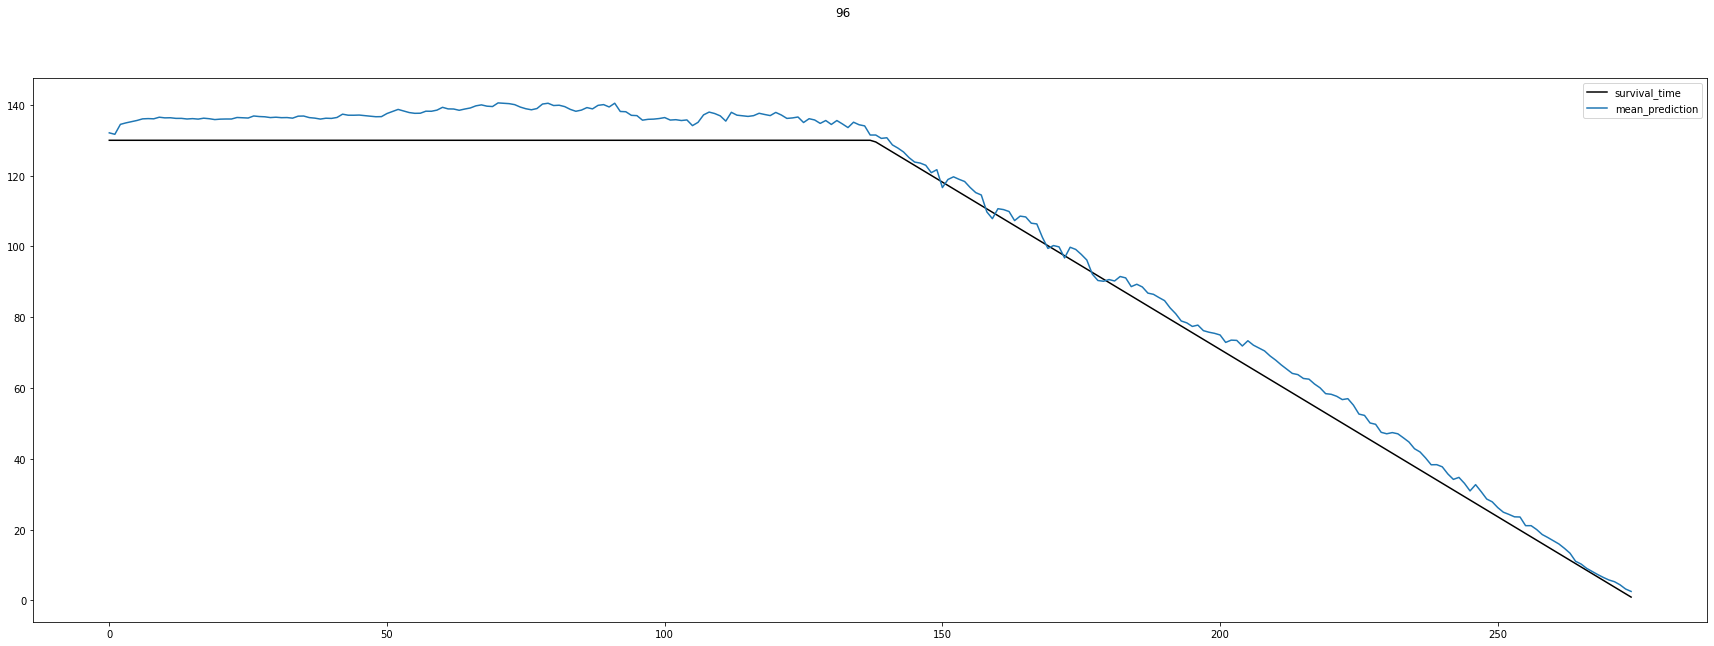

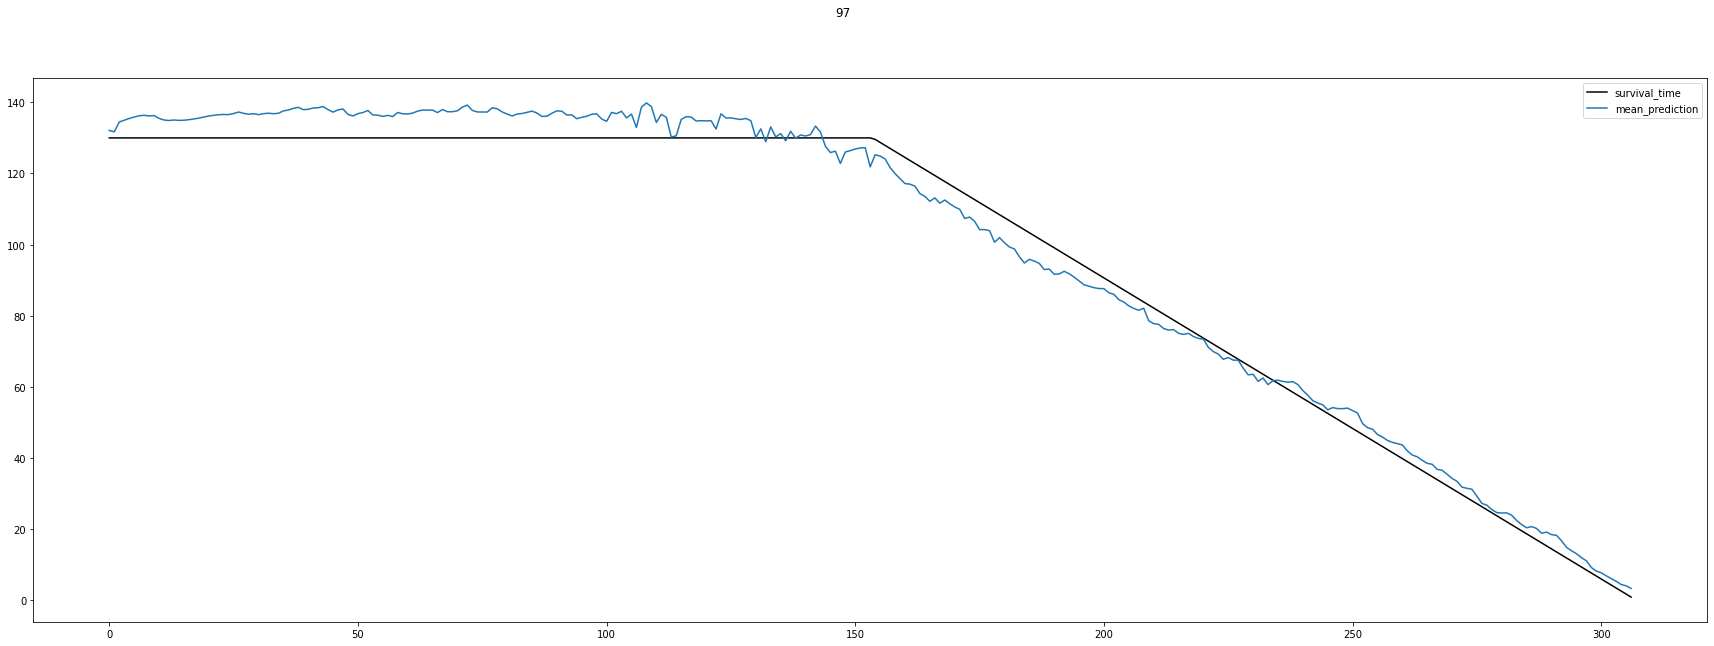

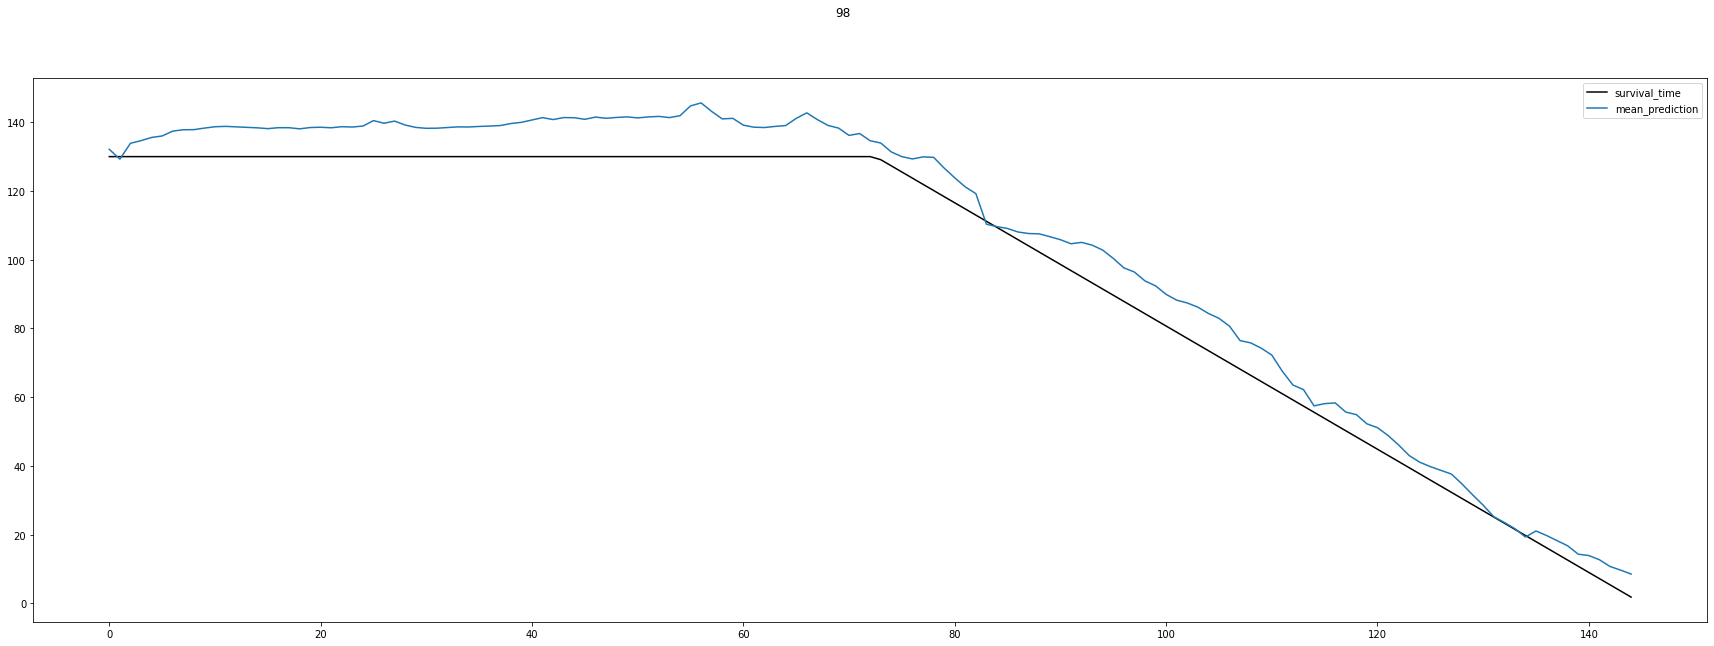

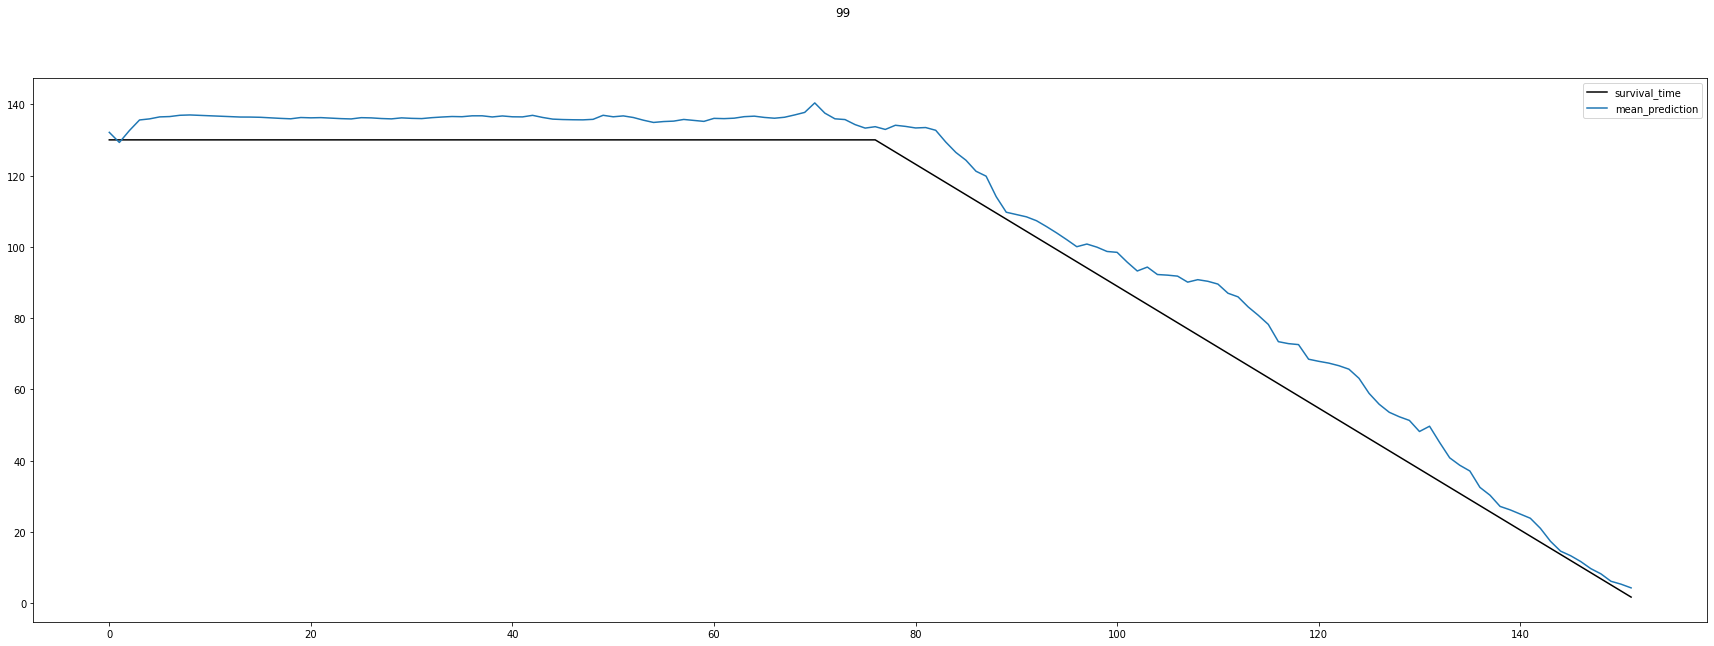

In [73]:
for unit_number, grp in train_results_df.groupby('unit_number'):
    plot_weibull_predictions(grp, unit_number)

***

# Training the entire model

In [78]:
def network(train_X, train_y, mask_value, epochs, batch_size, init_alpha):

    k.set_epsilon(1e-10)
    history = History()
    nan_terminator = callbacks.TerminateOnNaN()
    reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss')
    early_stopping = callbacks.EarlyStopping(patience=10)
#     tensorboard = callbacks.TensorBoard(log_dir = './logs_2D')

    n_features = train_X.shape[-1]

    # Start building our model
    model = Sequential()
    # Mask parts of the lookback period that are all _mask_value_ (i.e., unobserved) so they don't skew the model
    model.add(Masking(mask_value=mask_value, input_shape=(None, n_features)))
#     model.add(BatchNormalization())
    model.add(GRU(100, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(50, activation='tanh', return_sequences=True))
    model.add(BatchNormalization())
    model.add(GRU(20, activation='tanh', return_sequences=False))
    model.add(Dense(2))
    custom_activation = Activate()
    model.add(BatchNormalization())
    model.add(Activation(custom_activation))

    
    # Use the discrete log-likelihood for Weibull survival data as our loss function
    rmse = tf.keras.metrics.RootMeanSquaredError()

    model.compile(loss=CustomLoss(kind='continuous', reduce_loss=True), optimizer=Adam(lr=.01, clipvalue=0.5))#, metrics=['mse', rmse]) #CustomLoss(kind='mttf', reduce_loss=False)
    
    model.summary()
    
    model.fit(train_X, train_y,
              epochs=epochs,
              batch_size=batch_size,
              #validation_data=(test_X, test_y),
              verbose=1,
              callbacks=[nan_terminator, history, reduce_lr, early_stopping], # , tensorboard
              workers=32)
    

    return model, history

In [86]:
# parameters

try:
    del model
except NameError:
    pass
k.clear_session()

max_time = 100 
mask_value = -99

epochs = 10
batch_size = 64


scaler=pipeline.Pipeline(steps=[
     ('minmax', MinMaxScaler(feature_range=(-1, 1))),
     ('remove_constant', VarianceThreshold())])

train = train_x_orig.copy()
train = np.concatenate([train[['unit_number', 'time']], scaler.fit_transform(train[feature_cols])], axis=1)


train_x, train_y = build_data(units=train[:, 0], time=train[:, 1], x=train[:, 2:], max_time=max_time,
                              is_test=False, mask_value=mask_value, original_data=None, label='nonlinear')

print(train_x.shape)

# initialization
tte_mean_train = np.nanmean(train_y)#[:, 0]) # (uncomment when adding event)
mean_u = 1.0 #np.nanmean(train_y[:, 1]) # (uncomment when adding event)

# Initialization value for alpha-bias
init_alpha = -1.0 / np.log(1.0 - 1.0 / (tte_mean_train + 1.0))
init_alpha = init_alpha / mean_u
# print('tte_mean_train', tte_mean_train, 'init_alpha: ', init_alpha, 'mean uncensored train: ', mean_u)

print('train_x', train_x.shape, 'train_y', train_y.shape)

# training
model, history = network(train_x, train_y, mask_value, epochs, batch_size, init_alpha)

100%|██████████| 260/260 [00:06<00:00, 37.89it/s]


(53759, 100, 24)
train_x (53759, 100, 24) train_y (53759, 1)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, None, 24)          0         
_________________________________________________________________
gru (GRU)                    (None, None, 100)         37800     
_________________________________________________________________
batch_normalization (BatchNo (None, None, 100)         400       
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          22800     
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 50)          200       
_________________________________________________________________
gru_2 (GRU)                  (None, 20)                4320      
_____________________________________________________________

testing

In [87]:
test_or = test_x_orig.copy()
test_or = np.concatenate([test_or[['unit_number', 'time']], scaler.transform(test_or[feature_cols])], axis=1)


# Preparing data for the RNN (numpy arrays)
test_or, _ = build_data(units=test_or[:, 0], time=test_or[:, 1], x=test_or[:, 2:], max_time=max_time,
                   is_test=True, mask_value=mask_value, original_data=test_x_orig)

100%|██████████| 259/259 [00:00<00:00, 1053.33it/s]


In [88]:
test_predict = model.predict(test_or)
test_predict = np.resize(test_predict, (test_or.shape[0], 2))
test_result = np.concatenate((test_y_orig, test_predict), axis=1)
test_results_df = pd.DataFrame(test_result, columns=['T', 'alpha', 'beta'])
test_results_df['unit_number'] = np.arange(1, test_results_df.shape[0]+1)

test_results_df['predicted_mu'] = test_results_df[['alpha', 'beta']].apply(lambda row: weibull_mean(row[0], row[1]), axis=1)

In [89]:
test_results_df

T      alpha      beta  unit_number  predicted_mu
0     18.0   8.476152  0.999767            1      8.476989
1     79.0  50.146870  0.999815            2     50.150800
2    106.0  52.526764  0.999817            3     52.530834
3    110.0  43.044880  0.999811            4     43.048327
4     15.0  17.377296  0.999779            5     17.378917
..     ...        ...       ...          ...           ...
254  122.0  46.121876  0.999812          255     46.125548
255  191.0  64.204002  0.999824          256     64.208780
256   56.0  35.636826  0.999802          257     35.639811
257  131.0  57.953827  0.999820          258     57.958238
258   51.0  47.949512  0.999813          259     47.953302

[259 rows x 5 columns]

In [90]:
np.sqrt(mean_squared_error(test_results_df['predicted_mu'], test_results_df['T']))

54.204774498820925